In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from clust_huge_amp_learn_mu_d import *



## here we're running with the likelihood only 

In [2]:
%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Dropbox/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_89364/945457161.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/va

Loaded all components successfully!


In [3]:

# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=0, end_index=10000)

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Initialize model with subsetted data

del Y

In [5]:
# When initializing the model:
original_G = G_100k # Store the original G - proper tensor copy

# Now in your batch run, load and verify:
initial_psi = torch.load('/Users/sarahurbut/Dropbox/data_for_running/initial_psi_400k.pt')
initial_clusters = torch.load('/Users/sarahurbut/Dropbox/data_for_running/initial_clusters_400k.pt')

original_cluster_sizes = {}
unique, counts = np.unique(initial_clusters, return_counts=True)
for k, count in zip(unique, counts):
    original_cluster_sizes[k] = count
print("\nOriginal cluster sizes:")
for k, count in original_cluster_sizes.items():
    print(f"Cluster {k}: {count} diseases")


Original cluster sizes:
Cluster 0: 16 diseases
Cluster 1: 21 diseases
Cluster 2: 15 diseases
Cluster 3: 82 diseases
Cluster 4: 5 diseases
Cluster 5: 7 diseases
Cluster 6: 8 diseases
Cluster 7: 22 diseases
Cluster 8: 28 diseases
Cluster 9: 12 diseases
Cluster 10: 11 diseases
Cluster 11: 8 diseases
Cluster 12: 7 diseases
Cluster 13: 13 diseases
Cluster 14: 10 diseases
Cluster 15: 5 diseases
Cluster 16: 29 diseases
Cluster 17: 17 diseases
Cluster 18: 9 diseases
Cluster 19: 23 diseases


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_89364/2050531461.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/D

In [6]:
print("Initial psi stats:")
print(f"Shape: {initial_psi.shape}")
print(f"Range: [{initial_psi.min():.2f}, {initial_psi.max():.2f}]")
print(f"Number of positive values: {(initial_psi > 0).sum().item()}")



Initial psi stats:
Shape: torch.Size([20, 348])
Range: [-2.04, 1.33]
Number of positive values: 348


In [7]:
# Load references (signatures only, no healthy)
refs = torch.load('/Users/sarahurbut/Dropbox/data_for_running/reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:



/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_89364/1162222150.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('/Users/sarahurbut/Dropbox/

In [8]:

torch.manual_seed(7)
np.random.seed(4)
# Create model without healthy reference
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_100k.shape[1],
    init_sd_scaler=1e-1,
    G=G_100k, 
    Y=Y_100k,
    genetic_scale=1,
    W=0.0001,
    R=0,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
# Verify clusters match
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_learn_mu_d.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_learn_mu_d.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_learn_mu_d.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-18.4207, -18.4207, -17.3858, -16.3508, -16.3508])
Base value centered (first 5): tensor([-0.5458, -0.5458,  0.4891,  1.5240,  1.5240])
Base value centered mean: 3.23352810482902e-06
Gamma init for k=0 (first 5): tensor([ 0.0013,  0.0101,  0.0173,  0.0224, -0.0156])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-18.4207, -18.4207, -18.4207, -18.4207, -18.4207])
Base value centered

In [9]:
print(model.K_total)
print(model.K)
print(model.lrtpen)
print(model.gpweight)
print(model.lambda_amplitude)

21
20
0
0.0001
1


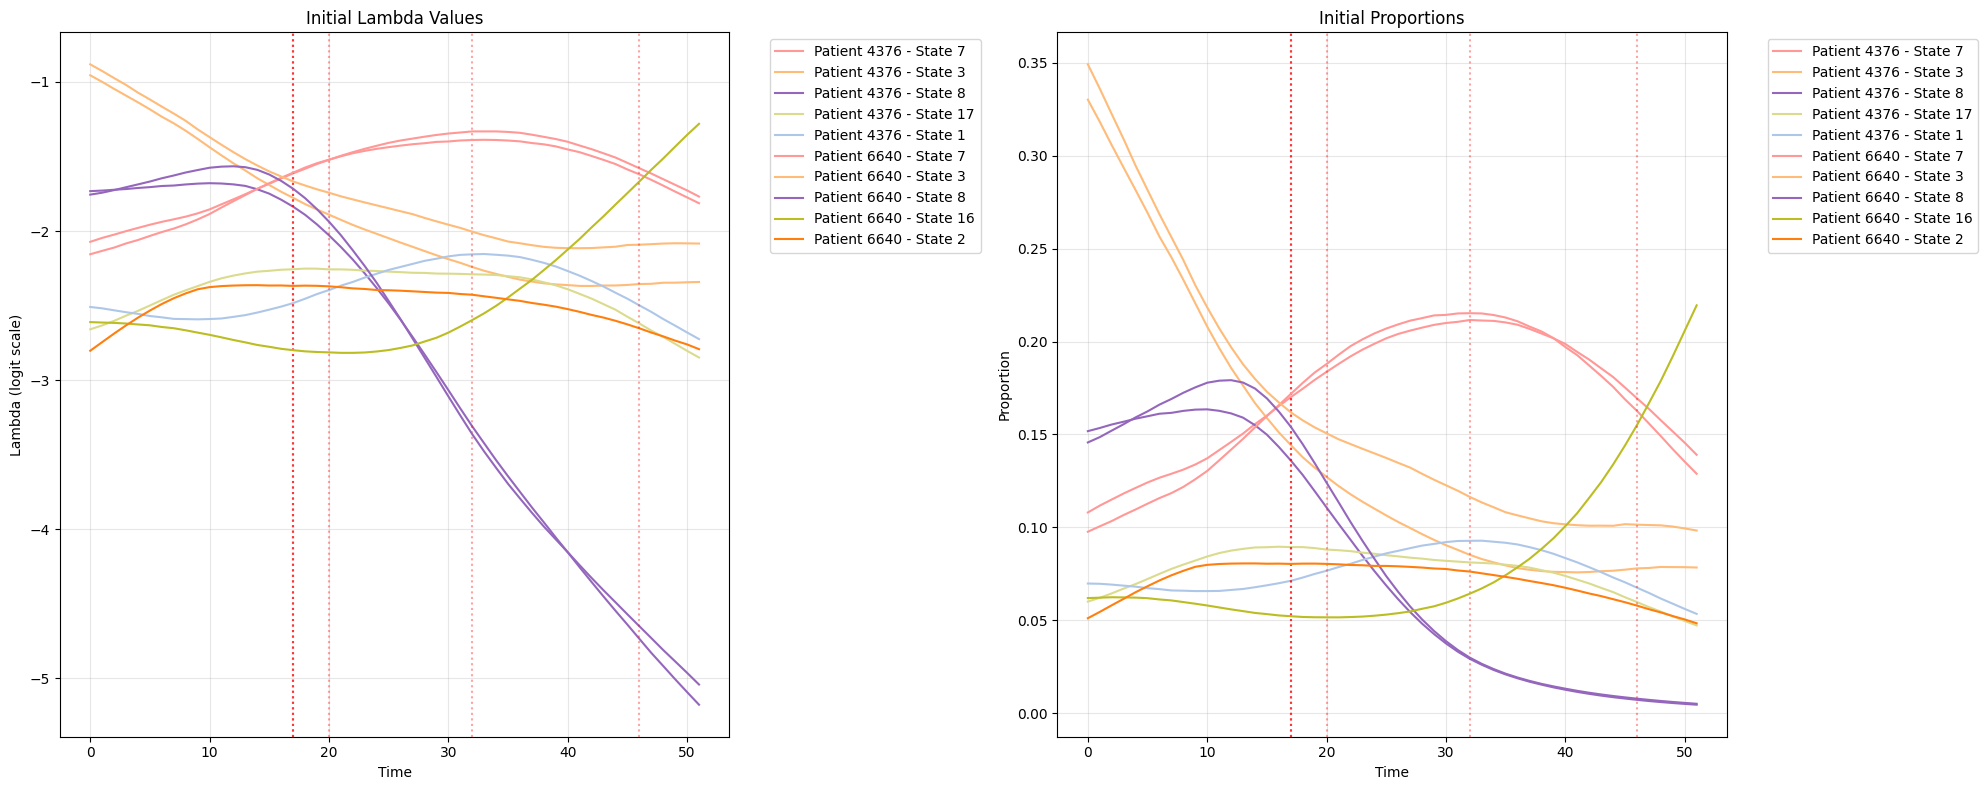


Genetic Effect Statistics for Sample Patients:

Patient 4376:
Mean shift: 0.063
Std of shifts: 0.139
Range of shifts: [-0.131, 0.461]

Top states and average proportions:
State 7: 0.172
State 3: 0.139
State 8: 0.080
State 17: 0.076
State 1: 0.076

Patient 6640:
Mean shift: 0.040
Std of shifts: 0.079
Range of shifts: [-0.164, 0.232]

Top states and average proportions:
State 7: 0.169
State 3: 0.161
State 8: 0.085
State 16: 0.082
State 2: 0.071


In [10]:
# Sample patients and set parameters
n_samples = 2
sample_patients = [4376, 6640]  # Use specific patients
n_top_states = 5  # Show only top 5 states per patient

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
time_points = np.arange(model.T)

# Get dominant states for these patients
lambda_patients = model.lambda_[sample_patients]  # [2, K, T]
patient_props = torch.softmax(lambda_patients, dim=1)  # [2, K, T]
mean_props = patient_props.mean(dim=-1)  # Average over time, now [2, K]
top_states = mean_props.topk(n_top_states, dim=-1).indices  # Get top states for each patient

# Color map for consistent colors across patients
colors = plt.cm.tab20(np.linspace(0, 1, model.K))

# Plot for each patient
for i, patient in enumerate(sample_patients):
    # Get diagnosis times for this patient
    diagnoses = model.Y[patient]  # Shape: [D, T]
    diagnosis_times = []
    for d in range(model.D):
        diag_time = torch.where(diagnoses[d])[0]
        if len(diag_time) > 0:
            diagnosis_times.append(diag_time[0].item())
            
    for j, k in enumerate(top_states[i]):
        k = k.item()  # Convert tensor to int
        color = colors[k]
        
        # Plot lambda values
        ax1.plot(time_points, model.lambda_[patient, k].detach(), '-', color=color,
                label=f'Patient {patient} - State {k}')
        
        # Plot proportions
        patient_props = torch.softmax(model.lambda_[patient].detach(), dim=0)[k]
        ax2.plot(time_points, patient_props, '-', color=color,
                label=f'Patient {patient} - State {k}')
    
    # Add vertical lines for diagnoses
    for t in diagnosis_times:
        ax1.axvline(x=t, color='red', alpha=0.2, linestyle=':')
        ax2.axvline(x=t, color='red', alpha=0.2, linestyle=':')

# Customize plots
ax1.set_title('Initial Lambda Values')
ax1.set_xlabel('Time')
ax1.set_ylabel('Lambda (logit scale)')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_title('Initial Proportions')
ax2.set_xlabel('Time')
ax2.set_ylabel('Proportion')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print genetic effects and top states
print("\nGenetic Effect Statistics for Sample Patients:")
for i, patient in enumerate(sample_patients):
    genetic_effects = model.genetic_scale * (model.G[patient] @ model.gamma).detach()
    print(f"\nPatient {patient}:")
    print(f"Mean shift: {genetic_effects.mean():.3f}")
    print(f"Std of shifts: {genetic_effects.std():.3f}")
    print(f"Range of shifts: [{genetic_effects.min():.3f}, {genetic_effects.max():.3f}]")
    
    # Print top states and their proportions
    patient_mean_props = mean_props[i]
    top_props, top_indices = patient_mean_props.topk(n_top_states)
    print("\nTop states and average proportions:")
    for state, prop in zip(top_indices, top_props):
        print(f"State {state.item()}: {prop:.3f}")

In [11]:
print(f"LRT penalty (R): {model.lrtpen}")
print(f"Lambda amplitude: {model.lambda_amplitude}")
print(f"GP Weight: {model.gpweight}")

LRT penalty (R): 0
Lambda amplitude: 1
GP Weight: 0.0001


In [12]:
initial_gamma = model.gamma.detach().clone()
initial_phi = model.phi.detach().clone()
initial_lambda = model.lambda_.detach().clone()
initial_psi = model.psi.detach().clone()



In [13]:
import cProfile
import pstats
from pstats import SortKey

# For the healthtoo version
profiler = cProfile.Profile()
profiler.enable()
history_new = model.fit(E_100k, num_epochs=200, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)
        

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_learn_mu_d.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


Kappa gradient: -5.413e+00

Epoch 0
Loss: 65.7955

Monitoring signature responses:

Disease 161 (signature 7, LR=32.38):
  Theta for diagnosed: 0.151 ± 0.038
  Theta for others: 0.147
  Proportion difference: 0.003

Disease 76 (signature 7, LR=30.81):
  Theta for diagnosed: 0.150 ± 0.039
  Theta for others: 0.147
  Proportion difference: 0.003

Disease 260 (signature 8, LR=30.45):
  Theta for diagnosed: 0.089 ± 0.074
  Theta for others: 0.087
  Proportion difference: 0.002

Disease 347 (signature 3, LR=29.51):
  Theta for diagnosed: 0.149 ± 0.070
  Theta for others: 0.150
  Proportion difference: -0.001

Disease 50 (signature 15, LR=28.94):
  Theta for diagnosed: 0.016 ± 0.006
  Theta for others: 0.014
  Proportion difference: 0.002
Kappa gradient: -4.684e+00

Epoch 1
Loss: 735.6302

Monitoring signature responses:

Disease 161 (signature 7, LR=32.41):
  Theta for diagnosed: 0.151 ± 0.036
  Theta for others: 0.147
  Proportion difference: 0.003

Disease 76 (signature 7, LR=30.82):
  Th

In [14]:
model.kappa

Parameter containing:
tensor([3.2106], requires_grad=True)

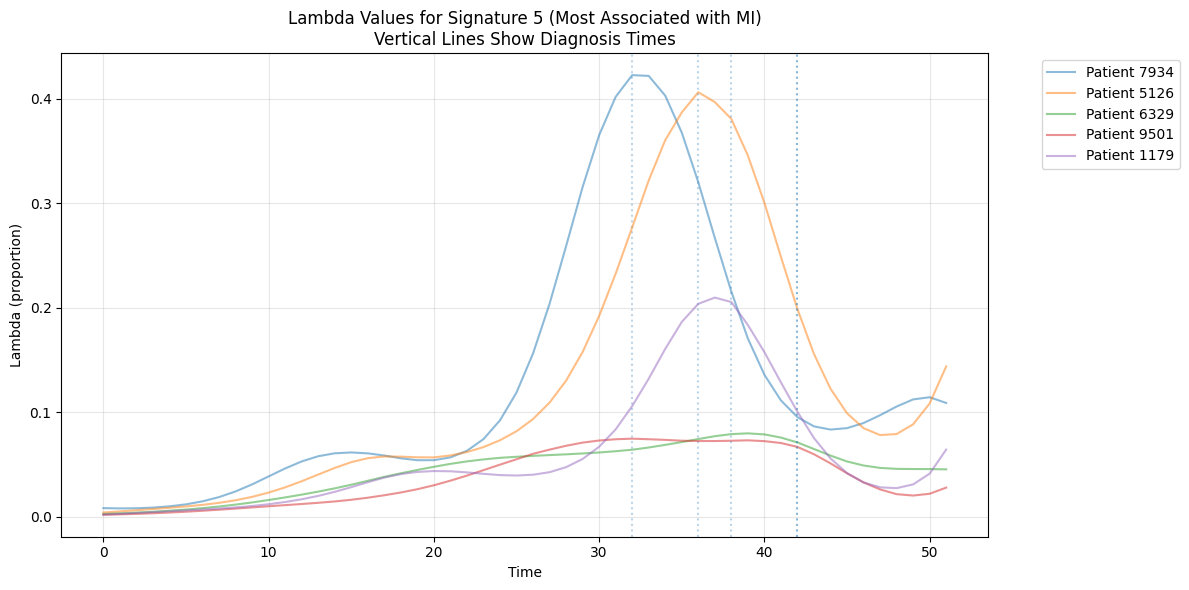

In [15]:
def plot_disease_lambda_alignment(model):
    """
    Plot lambda values aligned with disease occurrences for selected patients
    """
    # Find patients with specific diseases and their diagnosis times
    disease_idx = 112  # MI
    patients_with_disease = []
    diagnosis_times = []
    
    for patient in range(model.Y.shape[0]):
        diag_time = torch.where(model.Y[patient, disease_idx])[0]
        if len(diag_time) > 0:
            patients_with_disease.append(patient)
            diagnosis_times.append(diag_time[0].item())
    
    # Sample a few patients
    n_samples = min(5, len(patients_with_disease))
    sample_indices = np.random.choice(len(patients_with_disease), n_samples, replace=False)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    time_points = np.arange(model.T)
    
    # Find signature that most strongly associates with this disease
    psi_disease = model.psi[:, disease_idx].detach()
    sig_idx = torch.argmax(psi_disease).item()
    
    # Plot for each sampled patient
    for idx in sample_indices:
        patient = patients_with_disease[idx]
        diag_time = diagnosis_times[idx]
        
        # Plot lambda (detached)
        lambda_values = torch.softmax(model.lambda_[patient].detach(), dim=0)[sig_idx]
        ax.plot(time_points, lambda_values.numpy(),
                alpha=0.5, label=f'Patient {patient}')
        
        # Mark diagnosis time
        ax.axvline(x=diag_time, linestyle=':', alpha=0.3)
    
    ax.set_title(f'Lambda Values for Signature {sig_idx} (Most Associated with MI)\nVertical Lines Show Diagnosis Times')
    ax.set_xlabel('Time')
    ax.set_ylabel('Lambda (proportion)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_disease_lambda_alignment(model)

In [16]:
def plot_training_evolution(history_tuple):
    losses, gradient_history = history_tuple
    
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    plt.yscale('log')
    plt.legend()
    
    # Plot lambda gradients
    plt.subplot(1, 3, 2)
    lambda_norms = [torch.norm(g).item() for g in gradient_history['lambda_grad']]
    plt.plot(lambda_norms, label='Lambda gradients')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient norm')
    plt.title('Lambda Gradient Evolution')
    plt.legend()
    
    # Plot phi gradients
    plt.subplot(1, 3, 3)
    phi_norms = [torch.norm(g).item() for g in gradient_history['phi_grad']]
    plt.plot(phi_norms, label='Phi gradients')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient norm')
    plt.title('Phi Gradient Evolution')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [61]:
def plot_mu_d_vs_prevalence(self, num_diseases=10, random_seed=42):
    """
    Plot the learned mu_d values against the initial prevalence values
    for a sample of diseases.
    
    Parameters:
    -----------
    num_diseases : int
        Number of diseases to sample for visualization
    random_seed : int
        Random seed for reproducible sampling
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # Sample diseases (either randomly or select specific ones of interest)
    if num_diseases < self.D:
        disease_indices = np.random.choice(self.D, size=num_diseases, replace=False)
    else:
        disease_indices = np.arange(self.D)
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Plot initial vs. learned mu_d values
    initial_mu = self.logit_prev_t.detach().numpy()
    learned_mu = self.mu_d.detach().numpy()
    
    for d in disease_indices:
        disease_name = f"Disease {d}" if self.disease_names is None else self.disease_names[d]
        axes[0, 0].plot(initial_mu[d], learned_mu[d], 'o-', alpha=0.7, label=disease_name)
    
    axes[0, 0].set_title("Initial vs. Learned μ_d Values")
    axes[0, 0].set_xlabel("Initial μ_d (logit prevalence)")
    axes[0, 0].set_ylabel("Learned μ_d")
    axes[0, 0].plot([initial_mu.min(), initial_mu.max()], 
                   [initial_mu.min(), initial_mu.max()], 'k--', alpha=0.5)
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Plot difference between initial and learned mu_d
    for d in disease_indices:
        disease_name = f"Disease {d}" if self.disease_names is None else self.disease_names[d]
        axes[0, 1].plot(np.arange(self.T), learned_mu[d] - initial_mu[d], 'o-', alpha=0.7, label=disease_name)
    
    axes[0, 1].set_title("Difference: Learned - Initial μ_d")
    axes[0, 1].set_xlabel("Time")
    axes[0, 1].set_ylabel("Difference")
    axes[0, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Plot initial vs. learned prevalence
    initial_prev = self.prevalence_t.detach().numpy()
    learned_prev = 1 / (1 + np.exp(-learned_mu))  # sigmoid of learned mu
    
    for d in disease_indices:
        disease_name = f"Disease {d}" if self.disease_names is None else self.disease_names[d]
        axes[1, 0].plot(initial_prev[d], learned_prev[d], 'o-', alpha=0.7, label=disease_name)
    
    axes[1, 0].set_title("Initial vs. Learned Prevalence")
    axes[1, 0].set_xlabel("Initial Prevalence")
    axes[1, 0].set_ylabel("Learned Prevalence")
    axes[1, 0].plot([0, initial_prev.max()], [0, initial_prev.max()], 'k--', alpha=0.5)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Histogram of changes
    all_diffs = (learned_mu - initial_mu).flatten()
    sns.histplot(all_diffs, kde=True, ax=axes[1, 1])
    axes[1, 1].set_title("Distribution of μ_d Changes")
    axes[1, 1].set_xlabel("Learned - Initial μ_d")
    axes[1, 1].axvline(x=0, color='r', linestyle='--')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add overall statistics
    mean_diff = np.mean(all_diffs)
    median_diff = np.median(all_diffs)
    std_diff = np.std(all_diffs)
    max_abs_diff = np.max(np.abs(all_diffs))
    
    stats_text = (
        f"Mean difference: {mean_diff:.4f}\n"
        f"Median difference: {median_diff:.4f}\n"
        f"Std deviation: {std_diff:.4f}\n"
        f"Max absolute difference: {max_abs_diff:.4f}"
    )
    axes[1, 1].text(0.05, 0.95, stats_text, transform=axes[1, 1].transAxes,
                   verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [68]:
model.mu_d

Parameter containing:
tensor([[-10.9808, -10.9518, -10.8722,  ...,  -9.1304,  -9.1597,  -9.1969],
        [-12.8193, -12.7675, -12.6469,  ...,  -9.0350,  -9.0644,  -9.1065],
        [-14.9932, -14.8982, -14.6992,  ...,  -8.0298,  -8.0262,  -8.0410],
        ...,
        [-11.2182, -11.1956, -11.1316,  ...,  -7.4935,  -7.4893,  -7.5338],
        [-15.5449, -15.4174, -15.1899,  ...,  -6.6813,  -6.7085,  -6.7906],
        [-13.7783, -13.6828, -13.4823,  ...,  -8.8938,  -8.9444,  -8.9698]],
       requires_grad=True)

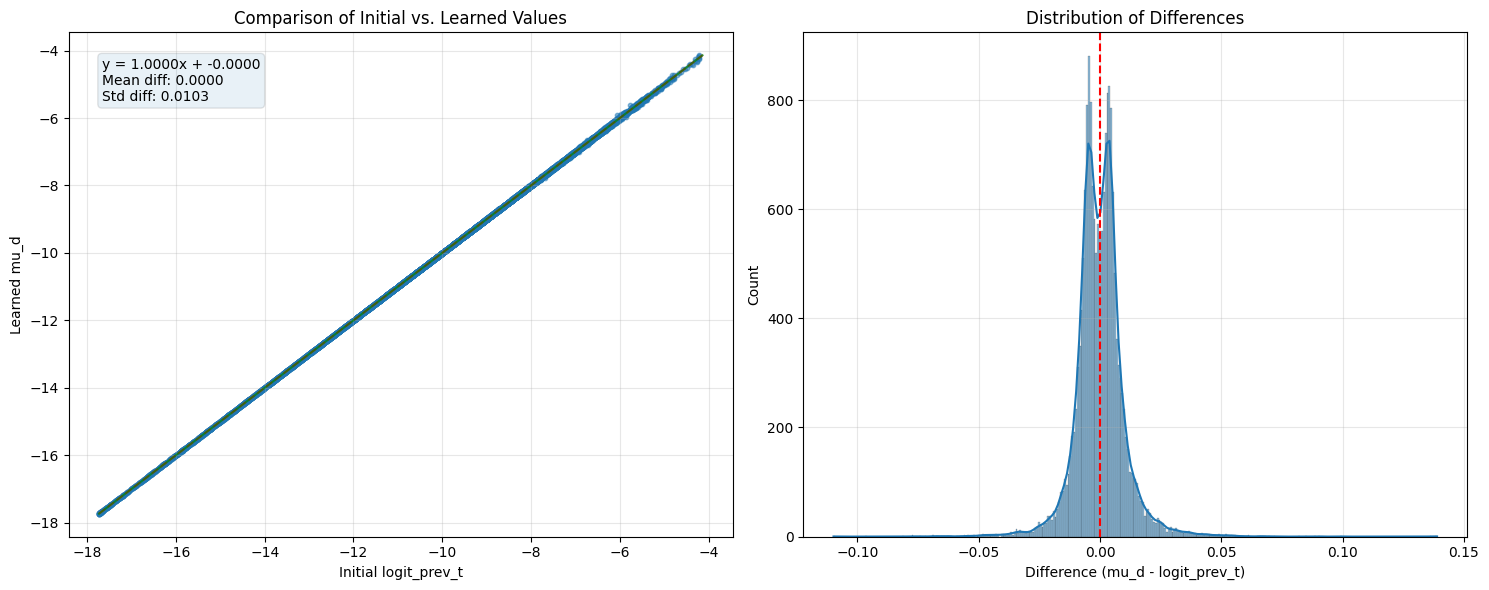

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_mu_d_vs_logit_prev(model, sample_size=None):
    """
    Plot the learned mu_d values against the initial logit_prev_t values.
    
    Parameters:
    -----------
    model : your model object
    sample_size : int or None
        Number of random points to sample (None = use all)
    """
    # Convert to numpy for easier handling
    mu_d = model.mu_d.detach().cpu().numpy()
    logit_prev = model.logit_prev_t.detach().cpu().numpy()
    
    # Flatten arrays for scatter plot
    mu_d_flat = mu_d.flatten()
    logit_prev_flat = logit_prev.flatten()
    
    # Sample if requested
    if sample_size is not None and sample_size < len(mu_d_flat):
        indices = np.random.choice(len(mu_d_flat), sample_size, replace=False)
        mu_d_flat = mu_d_flat[indices]
        logit_prev_flat = logit_prev_flat[indices]
    
    # Calculate differences
    differences = mu_d_flat - logit_prev_flat
    mean_diff = np.mean(differences)
    std_diff = np.std(differences)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot
    ax1.scatter(logit_prev_flat, mu_d_flat, alpha=0.5, s=10)
    
    # Add diagonal line (y=x)
    min_val = min(mu_d_flat.min(), logit_prev_flat.min())
    max_val = max(mu_d_flat.max(), logit_prev_flat.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)
    
    # Add regression line
    z = np.polyfit(logit_prev_flat, mu_d_flat, 1)
    p = np.poly1d(z)
    ax1.plot([min_val, max_val], [p(min_val), p(max_val)], 'g-', alpha=0.7)
    
    # Add labels and title
    ax1.set_xlabel('Initial logit_prev_t')
    ax1.set_ylabel('Learned mu_d')
    ax1.set_title('Comparison of Initial vs. Learned Values')
    ax1.grid(True, alpha=0.3)
    
    # Add text with regression equation and stats
    equation = f"y = {z[0]:.4f}x + {z[1]:.4f}"
    stats = f"Mean diff: {mean_diff:.4f}\nStd diff: {std_diff:.4f}"
    ax1.text(0.05, 0.95, equation + "\n" + stats, 
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', alpha=0.1))
    
    # Histogram of differences
    sns.histplot(differences, kde=True, ax=ax2)
    ax2.axvline(x=0, color='r', linestyle='--')
    ax2.set_xlabel('Difference (mu_d - logit_prev_t)')
    ax2.set_title('Distribution of Differences')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Call the function
fig = plot_mu_d_vs_logit_prev(model)
plt.show()

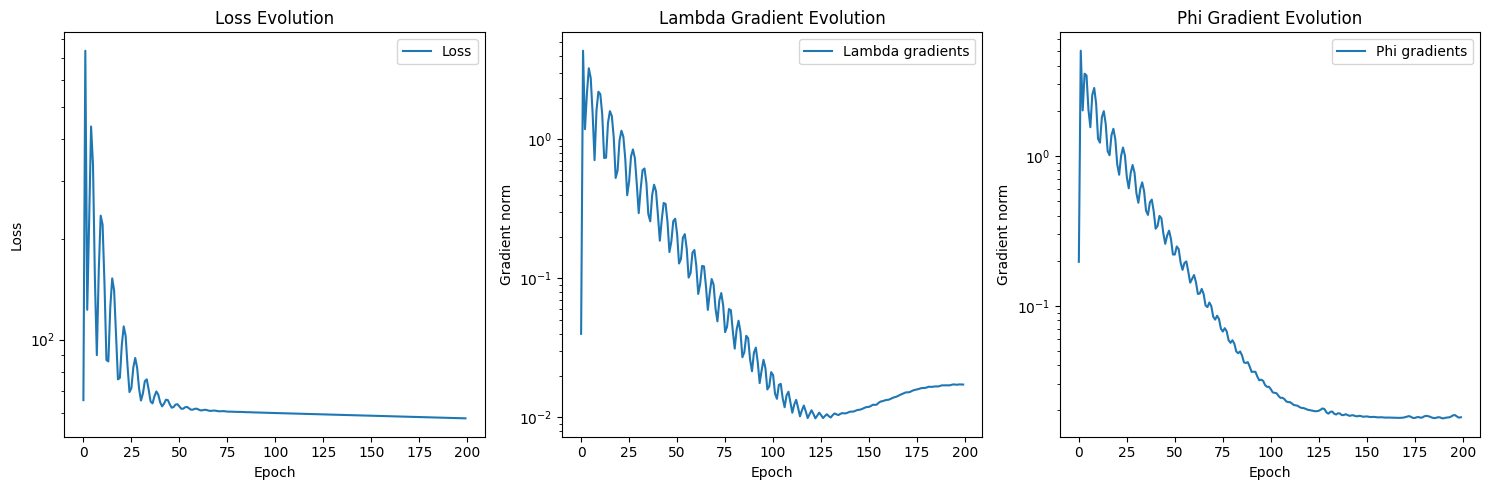

In [17]:
plot_training_evolution(history_new)

In [19]:
## do the cluster assignemtns still map?

final_psi=model.psi
# Get the signature with maximum psi for each disease
max_psi_indices = torch.argmax(final_psi, dim=0)  # Shape: [D]

# Compare with cluster assignments
matches = 0
total = len(model.clusters)

print("Comparing max psi signatures with cluster assignments:")
for k in range(model.K):
    # Find diseases assigned to cluster k
    cluster_diseases = np.where(model.clusters == k)[0]
    # Find diseases where k has maximum psi
    max_psi_diseases = np.where(max_psi_indices == k)[0]
    
    overlap = set(cluster_diseases) & set(max_psi_diseases)
    
    print(f"\nCluster {k}:")
    print(f"Number of diseases in cluster: {len(cluster_diseases)}")
    print(f"Number of diseases where this signature has max psi: {len(max_psi_diseases)}")
    print(f"Overlap: {len(overlap)}")
    
    matches += len(overlap)

print(f"\nOverall agreement: {matches}/{total} diseases ({matches/total*100:.1f}%)")

Comparing max psi signatures with cluster assignments:

Cluster 0:
Number of diseases in cluster: 16
Number of diseases where this signature has max psi: 16
Overlap: 16

Cluster 1:
Number of diseases in cluster: 21
Number of diseases where this signature has max psi: 21
Overlap: 21

Cluster 2:
Number of diseases in cluster: 15
Number of diseases where this signature has max psi: 15
Overlap: 15

Cluster 3:
Number of diseases in cluster: 82
Number of diseases where this signature has max psi: 82
Overlap: 82

Cluster 4:
Number of diseases in cluster: 5
Number of diseases where this signature has max psi: 5
Overlap: 5

Cluster 5:
Number of diseases in cluster: 7
Number of diseases where this signature has max psi: 7
Overlap: 7

Cluster 6:
Number of diseases in cluster: 8
Number of diseases where this signature has max psi: 8
Overlap: 8

Cluster 7:
Number of diseases in cluster: 22
Number of diseases where this signature has max psi: 22
Overlap: 22

Cluster 8:
Number of diseases in cluster:

In [20]:
model.psi[:,112]

tensor([-2.0744, -2.0684, -2.0157, -2.1993, -1.9056, -0.5444, -2.0778, -2.0651,
        -2.0312, -2.0689, -2.0418, -2.0117, -2.0422, -1.9691, -1.8849, -1.9685,
        -2.3275, -2.1696, -1.9741, -2.1327, -4.9033],
       grad_fn=<SelectBackward0>)

In [21]:
final_lambda = model.lambda_.detach().clone()
diff = torch.abs(final_lambda - initial_lambda)

print(f"Lambda changes with lr=1e-2:")
print(f"Mean absolute change: {torch.mean(diff):.3e}")
print(f"Max absolute change: {torch.max(diff):.3e}")
print(f"Std of changes: {torch.std(diff):.3e}")

Lambda changes with lr=1e-2:
Mean absolute change: 6.011e-02
Max absolute change: 7.091e+00
Std of changes: 1.515e-01


In [22]:
final_psi= model.psi.detach().clone()
diff = torch.abs(final_psi - initial_psi)

print(f"Psi changes with lr=1e-2:")
print(f"Mean absolute change: {torch.mean(diff):.3e}")
print(f"Max absolute change: {torch.max(diff):.3e}")
print(f"Std of changes: {torch.std(diff):.3e}")

Psi changes with lr=1e-2:
Mean absolute change: 9.397e-02
Max absolute change: 2.618e+00
Std of changes: 1.810e-01


In [23]:
final_phi= model.phi.detach().clone()
diff = torch.abs(final_phi - initial_phi)

print(f"Phi changes with lr=1e-2:")
print(f"Mean absolute change: {torch.mean(diff):.3e}")
print(f"Max absolute change: {torch.max(diff):.3e}")
print(f"Std of changes: {torch.std(diff):.3e}")

Phi changes with lr=1e-2:
Mean absolute change: 1.220e-02
Max absolute change: 1.156e+00
Std of changes: 3.355e-02


In [24]:
final_psi.shape

torch.Size([21, 348])

In [25]:
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")


Clusters match exactly: True


In [26]:
model.clusters[17]

np.int32(19)

In [27]:
def plot_theta_differences():
    diseases = [112, 67, 127, 10, 17,114]
    signatures = [5, 7, 0, 17, 19,5]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (d, sig) in enumerate(zip(diseases, signatures)):
        ax = axes[i]
        
        # Get diagnosis times
        diagnosis_mask = model.Y[:, d, :].bool()
        diagnosed = torch.where(diagnosis_mask)[0]
        
        # Get thetas
        pi, theta, phi_prob = model.forward()
        
        # Plot distributions
        diagnosed_theta = theta[diagnosis_mask, sig].detach().numpy()
        others_theta = theta[~diagnosis_mask, sig].detach().numpy()
        
        ax.hist(diagnosed_theta, alpha=0.5, label='At diagnosis', density=True)
        ax.hist(others_theta, alpha=0.5, label='Others', density=True)
        
        ax.set_title(f'Disease {d} (sig {sig})')
        ax.set_xlabel('Theta')
        ax.set_ylabel('Density')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

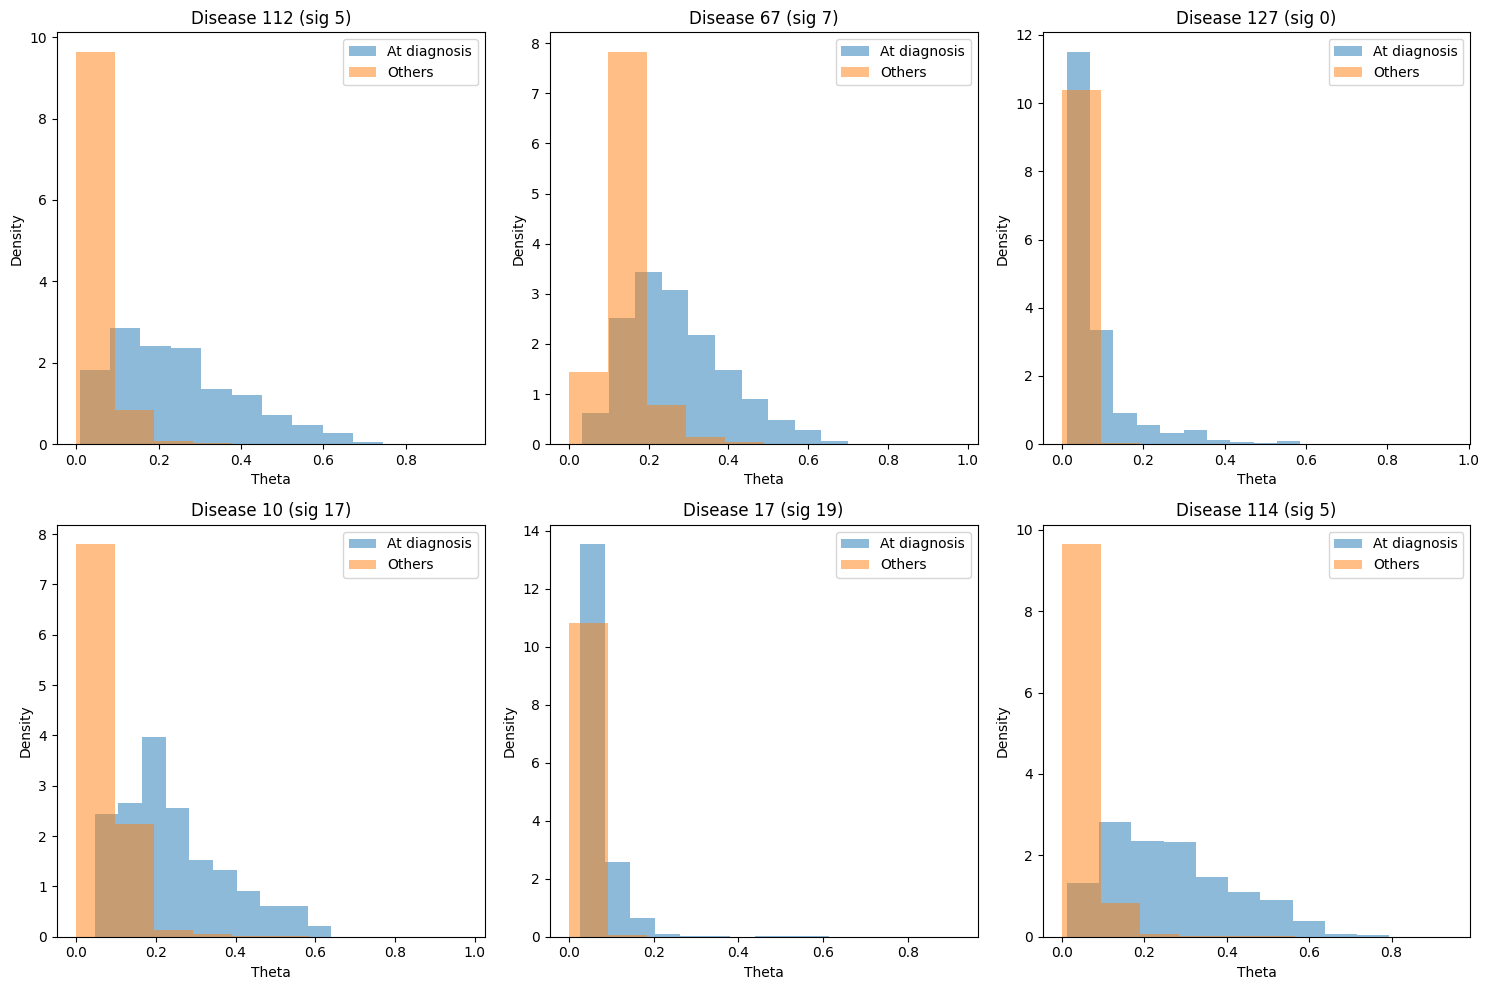

In [28]:
plot_theta_differences()

In [29]:
model.gpweight

0.0001

In [31]:
# Get μ_dt from checkpoint and predictions
mu_dt = model.prevalence_t  # Shape: (348, 52)
model.mu_d


Parameter containing:
tensor([[-10.9808, -10.9518, -10.8722,  ...,  -9.1304,  -9.1597,  -9.1969],
        [-12.8193, -12.7675, -12.6469,  ...,  -9.0350,  -9.0644,  -9.1065],
        [-14.9932, -14.8982, -14.6992,  ...,  -8.0298,  -8.0262,  -8.0410],
        ...,
        [-11.2182, -11.1956, -11.1316,  ...,  -7.4935,  -7.4893,  -7.5338],
        [-15.5449, -15.4174, -15.1899,  ...,  -6.6813,  -6.7085,  -6.7906],
        [-13.7783, -13.6828, -13.4823,  ...,  -8.8938,  -8.9444,  -8.9698]],
       requires_grad=True)

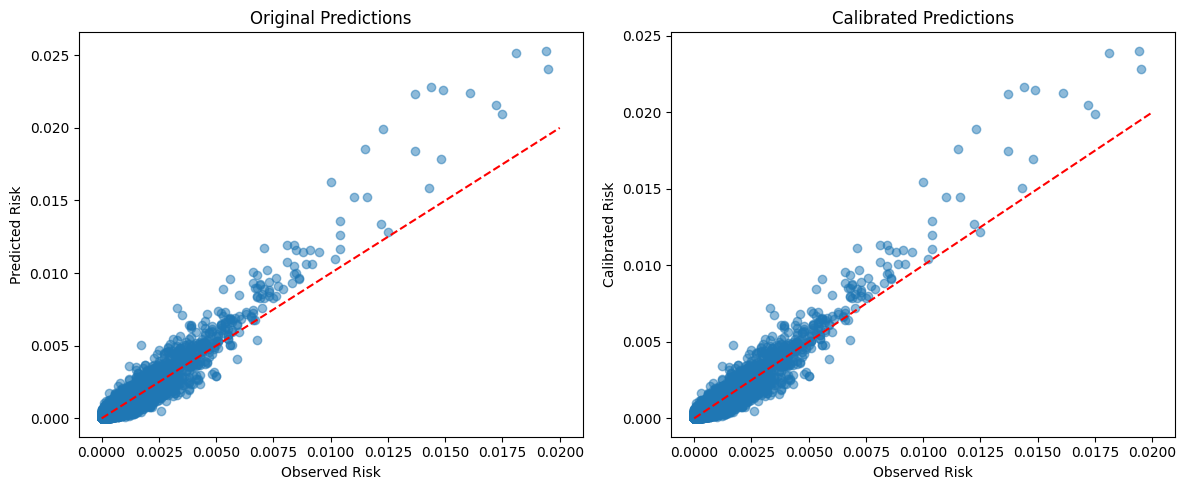

Mean observed risk: 0.000438
Mean predicted risk (original): 0.000461
Mean predicted risk (calibrated): 0.000438
Calibration scale factor: 0.949


In [32]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()
#observed_risk=mu_dt_flat
# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


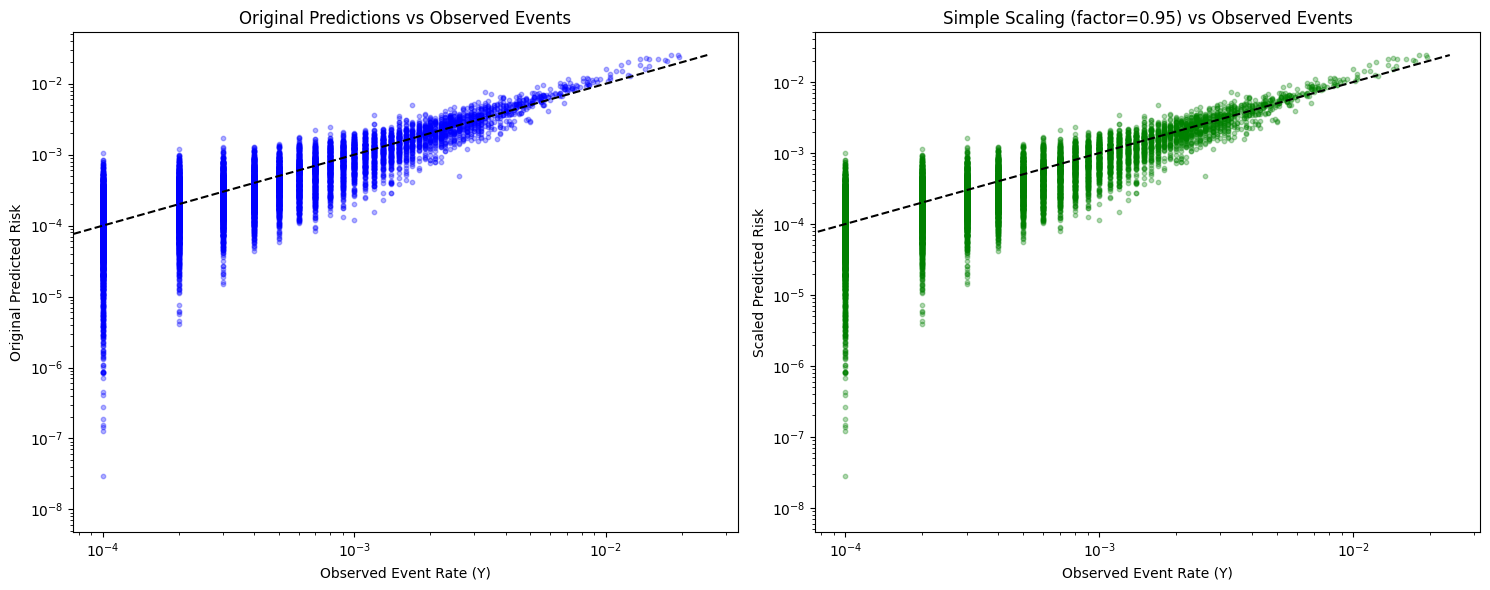

Scale factor: 0.949


In [33]:
# Get predictions
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
predicted_risk_2d = pi_pred.cpu().detach().numpy().mean(axis=0)  # average across individuals

# Get raw observations and calculate scale factor
Y_np = model.Y.cpu().detach().numpy()
Y_mean_2d = Y_np.mean(axis=0)  # average across individuals
scale_factor = Y_mean_2d.mean() / predicted_risk_2d.mean()
scaled_risk_2d = predicted_risk_2d * scale_factor

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original predictions vs raw observations
ax1.scatter(Y_mean_2d.flatten(), predicted_risk_2d.flatten(), 
           alpha=0.3, color='blue', s=10)
ax1.plot([0, max(Y_mean_2d.max(), predicted_risk_2d.max())], 
         [0, max(Y_mean_2d.max(), predicted_risk_2d.max())], 
         'k--', label='x=y')
ax1.set_xlabel('Observed Event Rate (Y)')
ax1.set_ylabel('Original Predicted Risk')
ax1.set_title('Original Predictions vs Observed Events')
ax1.set_xscale('log')
ax1.set_yscale('log')

# Scaled predictions vs raw observations
ax2.scatter(Y_mean_2d.flatten(), scaled_risk_2d.flatten(), 
           alpha=0.3, color='green', s=10)
ax2.plot([0, max(Y_mean_2d.max(), scaled_risk_2d.max())], 
         [0, max(Y_mean_2d.max(), scaled_risk_2d.max())], 
         'k--', label='x=y')
ax2.set_xlabel('Observed Event Rate (Y)')
ax2.set_ylabel('Scaled Predicted Risk')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f}) vs Observed Events')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"Scale factor: {scale_factor:.3f}")

In [34]:

ss_res = np.sum((observed_risk - predicted_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")

R^2: 0.857


In [35]:
def apply_loess_calibration(predicted_risks, observed_risks):
    # Fit LOESS calibration curve
    calibrated_risks = lowess(
        observed_risks, 
        predicted_risks,
        frac=0.3,  # Can tune this parameter
        return_sorted=False
    )
    
    # Apply to predictions
    pi_calibrated = np.zeros_like(pi)
    for d in range(model.D):
        for t in range(model.T):
            risks = pi[:, d, t]
            pi_calibrated[:, d, t] = lowess(
                observed_risks,  # Use same calibration curve
                risks,
                frac=0.3
            )
    
    return pi_calibrated

In [36]:
    calibrated_risks = lowess(
        observed_risk, 
        predicted_risk,
        frac=0.3,  # Can tune this parameter
        return_sorted=False
    )

In [37]:
def plot_signature_temporal_patterns(model, disease_names, plot_dir, n_top=10, selected_signatures=None):
    """Show temporal patterns of top diseases for each signature"""
    phi = model.phi.detach().numpy()
    prevalence_logit = model.logit_prev_t.detach().numpy()
    import os
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    phi_avg = phi_centered.mean(axis=2)
    
    if selected_signatures is None:
        selected_signatures = range(phi_avg.shape[0])
    
    n_sigs = len(selected_signatures)
    fig, axes = plt.subplots(n_sigs, 1, figsize=(15, 5*n_sigs))
    if n_sigs == 1:
        axes = [axes]
    
    for i, k in enumerate(selected_signatures):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        ax = axes[i]
        for idx in top_indices:
            temporal_pattern = phi[k, idx, :]
            disease_name = disease_names[idx]
            ax.plot(temporal_pattern, label=disease_name)
        
        ax.set_title(f'Signature {k} - Top Disease Temporal Patterns')
        ax.set_xlabel('Time')
        ax.set_ylabel('Phi Value')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'temporal_patterns_withkappa.png'))
    plt.close('all') 

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sarahurbut/Dropbox (Personal)/temporal_patterns_withkappa.png'

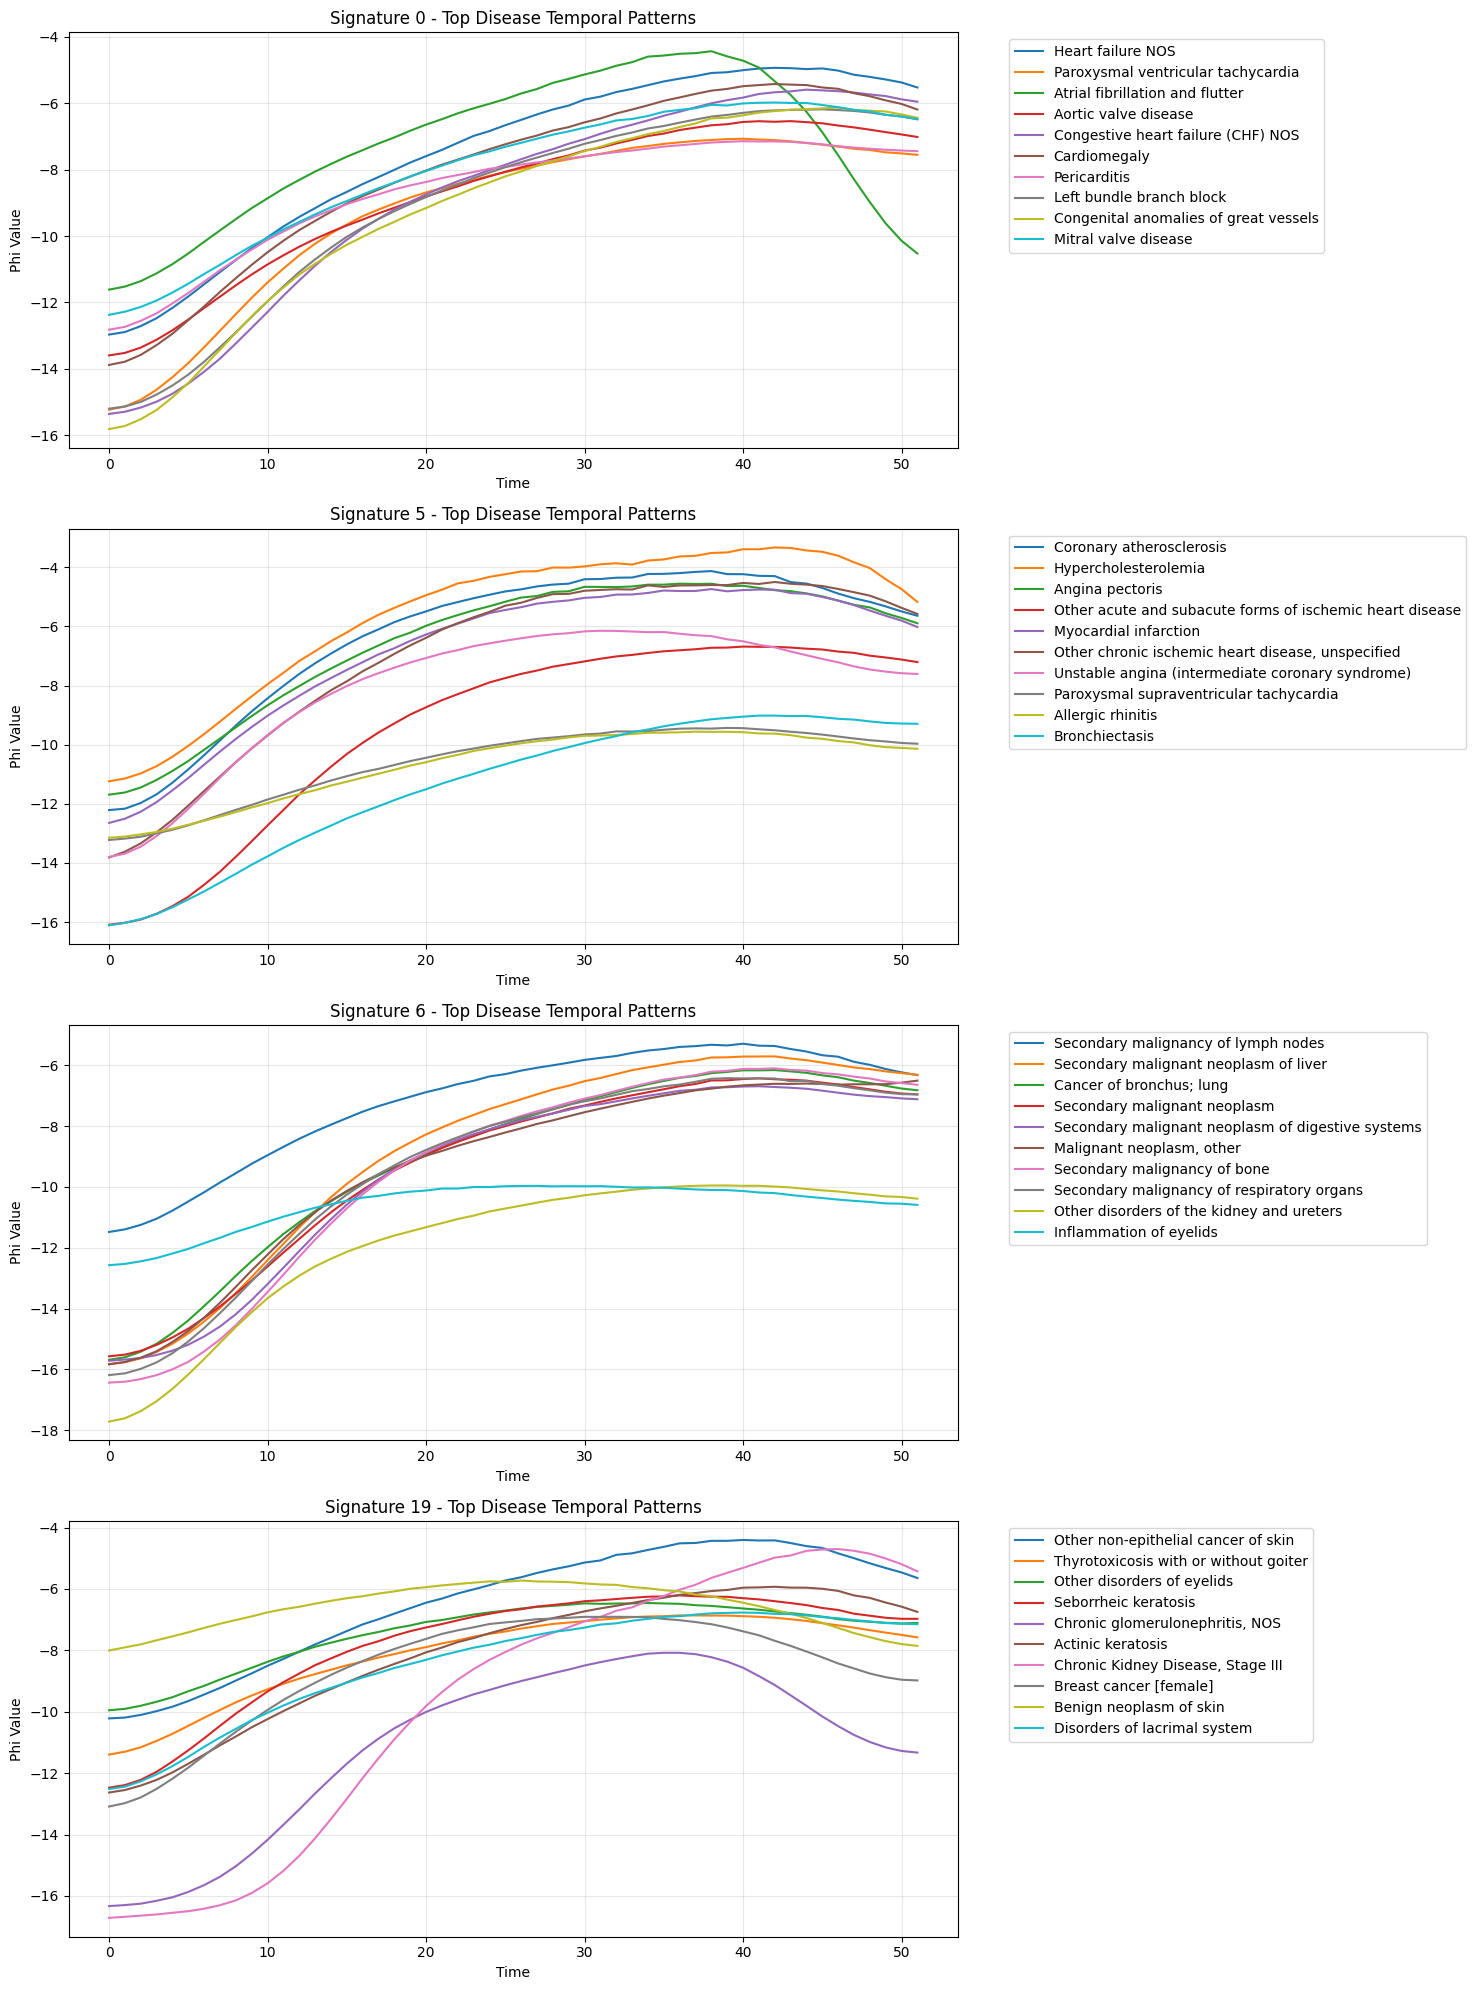

In [38]:
plot_signature_temporal_patterns(model, essentials['disease_names'],'/Users/sarahurbut/Dropbox (Personal)/', n_top=10, selected_signatures=[0,5,6,19])

In [39]:
def plot_signature_top_diseases_centered(model, disease_names, n_top=10):
    """
    Show top diseases for each signature, centered relative to prevalence
    """
    # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # For each signature, get top diseases
    for k in range(phi_avg.shape[0]):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        print(f"\nTop {n_top} diseases in Signature {k} (relative to baseline):")
        for idx in top_indices:
            avg_effect = scores[idx]
            temporal_std = np.std(phi_centered[k, idx, :])
            # Convert to odds ratio for interpretability
            odds_ratio = np.exp(avg_effect)
            print(f"{disease_names[idx]}: effect={avg_effect:.3f} (OR={odds_ratio:.2f}), std={temporal_std:.3f}")

# Run visualization
plot_signature_top_diseases_centered(model, essentials['disease_names'])


Top 10 diseases in Signature 0 (relative to baseline):
Heart failure NOS: effect=1.277 (OR=3.59), std=0.165
Paroxysmal ventricular tachycardia: effect=1.236 (OR=3.44), std=0.073
Atrial fibrillation and flutter: effect=1.233 (OR=3.43), std=0.308
Aortic valve disease: effect=1.216 (OR=3.37), std=0.078
Congestive heart failure (CHF) NOS: effect=1.110 (OR=3.04), std=0.128
Cardiomegaly: effect=1.085 (OR=2.96), std=0.149
Pericarditis: effect=1.078 (OR=2.94), std=0.101
Left bundle branch block: effect=1.051 (OR=2.86), std=0.055
Congenital anomalies of great vessels: effect=1.036 (OR=2.82), std=0.068
Mitral valve disease: effect=1.027 (OR=2.79), std=0.127

Top 10 diseases in Signature 1 (relative to baseline):
Enthesopathy: effect=1.231 (OR=3.43), std=0.131
Hallux valgus (Bunion): effect=1.206 (OR=3.34), std=0.062
Other disorders of synovium, tendon, and bursa: effect=1.181 (OR=3.26), std=0.034
Peripheral enthesopathies and allied syndromes: effect=1.162 (OR=3.20), std=0.058
Pain in joint: ef

In [40]:
mean_phi=model.phi.detach().cpu().numpy()

In [41]:
initial_psi[:,112]

tensor([-1.9906, -2.0008, -2.0034, -2.0126, -1.9857,  0.8679, -1.9930, -2.0030,
        -2.0053, -2.0097, -1.9918, -1.9775, -2.0165, -1.9968, -1.9910, -2.0046,
        -1.9988, -1.9991, -1.9921, -1.9857, -5.0022])

In [42]:
model.psi[:,112]

tensor([-2.0744, -2.0684, -2.0157, -2.1993, -1.9056, -0.5444, -2.0778, -2.0651,
        -2.0312, -2.0689, -2.0418, -2.0117, -2.0422, -1.9691, -1.8849, -1.9685,
        -2.3275, -2.1696, -1.9741, -2.1327, -4.9033],
       grad_fn=<SelectBackward0>)

In [43]:
model.K=21

In [44]:
model.kappa

Parameter containing:
tensor([3.2106], requires_grad=True)

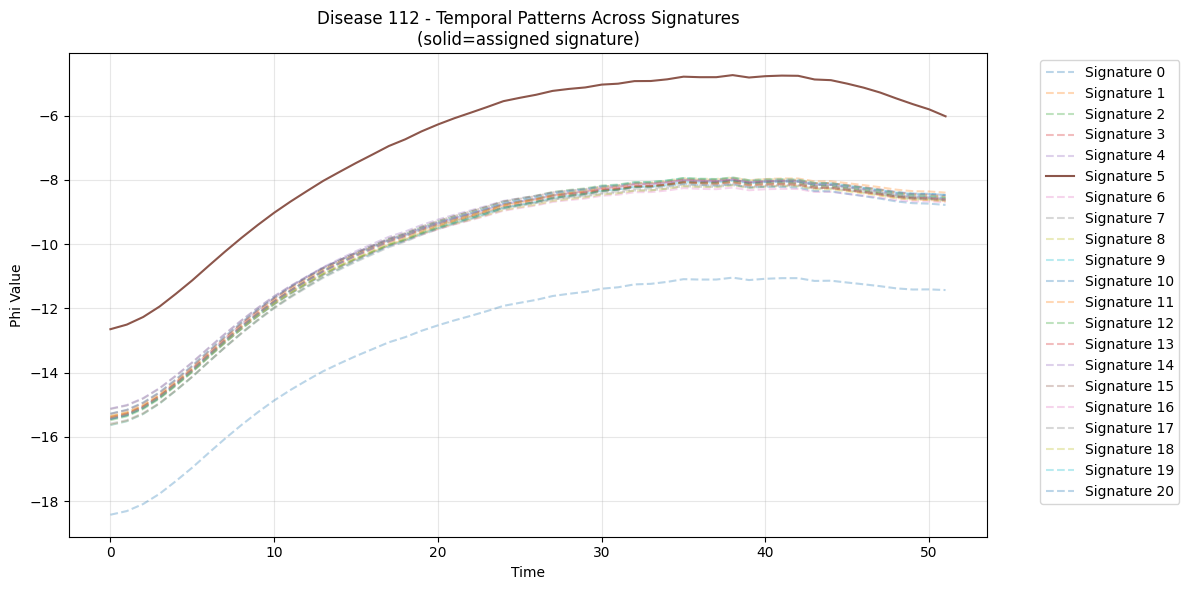


Psi values for disease 112:
Signature 0: -2.074
Signature 1: -2.068
Signature 2: -2.016
Signature 3: -2.199
Signature 4: -1.906
Signature 5: -0.544
Signature 6: -2.078
Signature 7: -2.065
Signature 8: -2.031
Signature 9: -2.069
Signature 10: -2.042
Signature 11: -2.012
Signature 12: -2.042
Signature 13: -1.969
Signature 14: -1.885
Signature 15: -1.968
Signature 16: -2.327
Signature 17: -2.170
Signature 18: -1.974
Signature 19: -2.133
Signature 20: -4.903


In [45]:
def plot_disease_signature_patterns(model, disease_idx=112):
    plt.figure(figsize=(12, 6))
    time_points = np.arange(model.T)
    
    # Get phi values for this disease across all signatures
    phi_disease = model.phi[:, disease_idx].detach()  # [K, T]
    psi_disease = model.psi[:, disease_idx].detach()  # [K]
    
    # Plot phi trajectories
    for k in range(model.K):
        # Make the assigned signature (highest psi) stand out
        is_assigned = (psi_disease[k] == psi_disease.max())
        alpha = 1.0 if is_assigned else 0.3
        linestyle = '-' if is_assigned else '--'
        
        plt.plot(time_points, phi_disease[k], 
                label=f'Signature {k}', 
                alpha=alpha,
                linestyle=linestyle)
    
    plt.title(f'Disease {disease_idx} - Temporal Patterns Across Signatures\n(solid=assigned signature)')
    plt.xlabel('Time')
    plt.ylabel('Phi Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print psi values
    print(f"\nPsi values for disease {disease_idx}:")
    for k in range(model.K):
        print(f"Signature {k}: {psi_disease[k]:.3f}")

# Call the function for MI (disease 112)
plot_disease_signature_patterns(model, disease_idx=112)

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_learn_mu_d.py:543: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


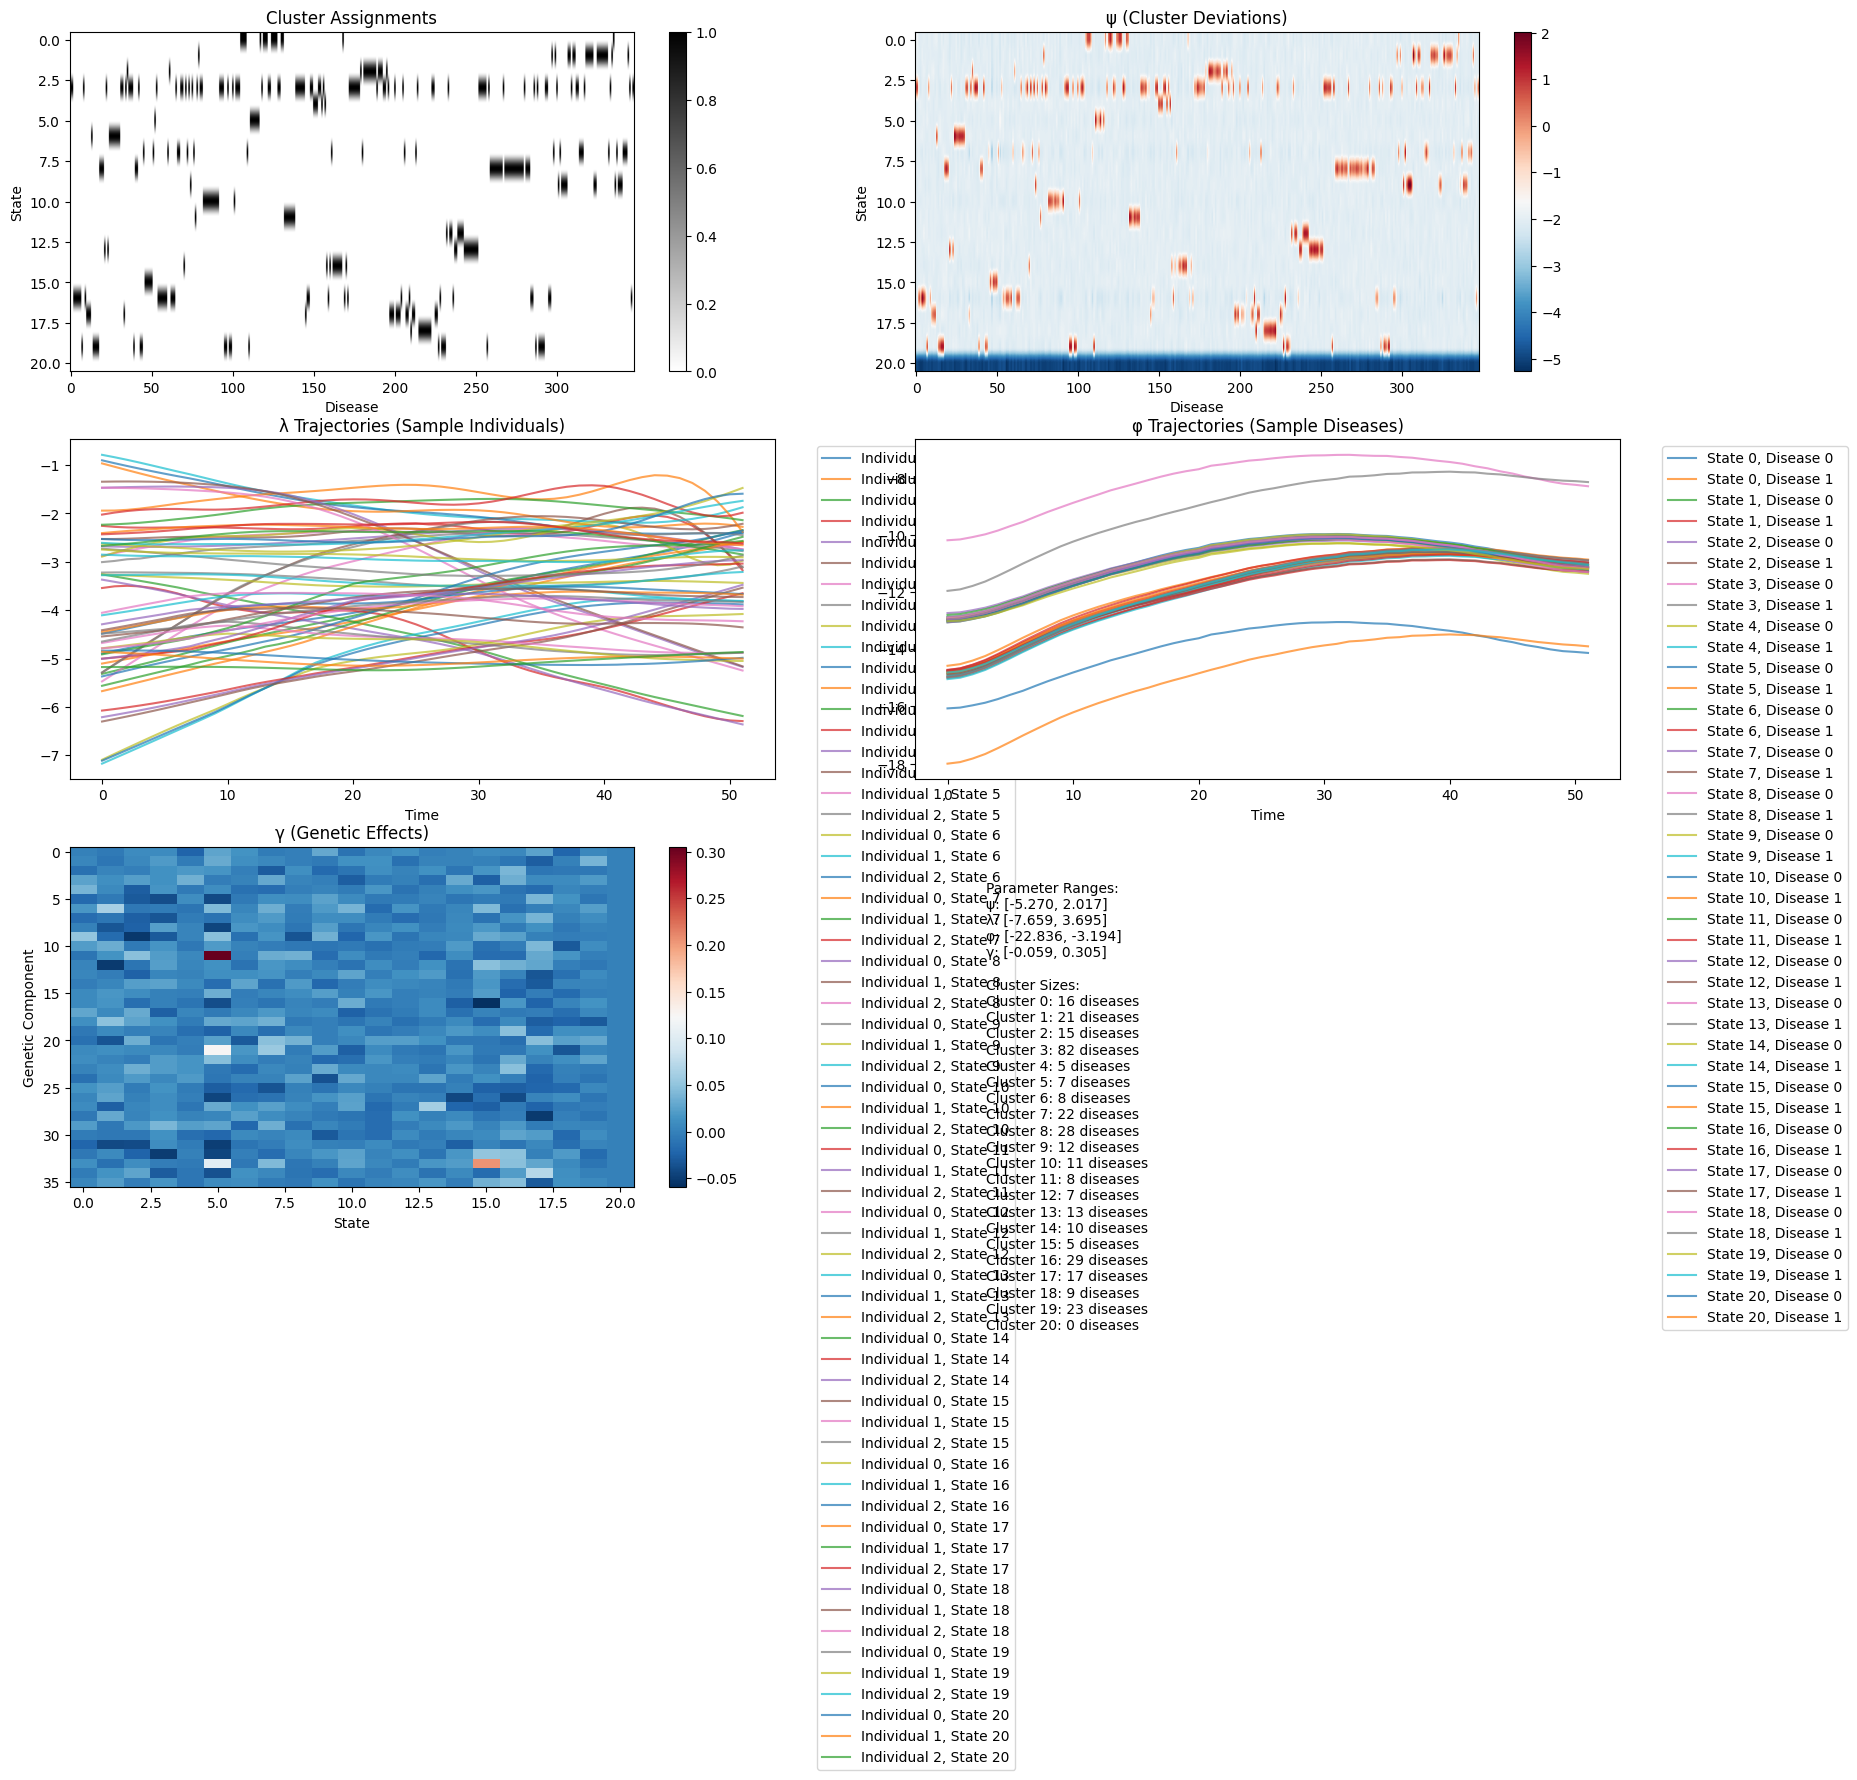

In [46]:
model.visualize_initialization()

In [47]:
def compare_disease_rankings(model, disease_names, n_top=10):
    """
    Compare initial vs final disease rankings for each signature
    """
    # Get initial rankings from psi
    psi = model.psi.detach().numpy()  # Shape: (K, D)
    
    # Get final rankings from centered phi
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Compare rankings for each signature
    for k in range(phi_avg.shape[0]):
        print(f"\nSignature {k}:")
        
        # Get initial top diseases from psi
        initial_scores = psi[k, :]
        initial_top = np.argsort(initial_scores)[-n_top:][::-1]
        
        # Get final top diseases from phi
        final_scores = phi_avg[k, :]
        final_top = np.argsort(final_scores)[-n_top:][::-1]
        
        print("\nInitial top diseases:")
        for i, idx in enumerate(initial_top):
            print(f"{i+1}. {disease_names[idx]}: {initial_scores[idx]:.3f}")
            
        print("\nFinal top diseases:")
        for i, idx in enumerate(final_top):
            print(f"{i+1}. {disease_names[idx]}: {final_scores[idx]:.3f}")
            
        # Calculate rank changes
        initial_ranks = {disease: rank for rank, disease in enumerate(initial_top)}
        final_ranks = {disease: rank for rank, disease in enumerate(final_top)}
        
        # Find diseases that changed ranks significantly
        changed_diseases = set(initial_top) | set(final_top)
        for disease in changed_diseases:
            initial_rank = initial_ranks.get(disease, n_top+1)
            final_rank = final_ranks.get(disease, n_top+1)
            if abs(final_rank - initial_rank) > 2:  # Threshold for significant change
                print(f"\n{disease_names[disease]} changed from rank {initial_rank+1} to {final_rank+1}")

# Run comparison
compare_disease_rankings(model, essentials['disease_names'])


Signature 0:

Initial top diseases:
1. Pericarditis: 1.242
2. Paroxysmal ventricular tachycardia: 1.146
3. Aortic valve disease: 0.889
4. Mitral valve disease: 0.722
5. Atrial fibrillation and flutter: 0.608
6. Paroxysmal supraventricular tachycardia: 0.578
7. Congestive heart failure (CHF) NOS: 0.565
8. Primary/intrinsic cardiomyopathies: 0.465
9. Cardiomegaly: 0.385
10. Heart failure NOS: 0.312

Final top diseases:
1. Heart failure NOS: 1.277
2. Paroxysmal ventricular tachycardia: 1.236
3. Atrial fibrillation and flutter: 1.233
4. Aortic valve disease: 1.216
5. Congestive heart failure (CHF) NOS: 1.110
6. Cardiomegaly: 1.085
7. Pericarditis: 1.078
8. Left bundle branch block: 1.051
9. Congenital anomalies of great vessels: 1.036
10. Mitral valve disease: 1.027

Heart failure NOS changed from rank 10 to 1

Congenital anomalies of great vessels changed from rank 12 to 9

Mitral valve disease changed from rank 4 to 10

Cardiomegaly changed from rank 9 to 6

Pericarditis changed from ra

In [48]:
model.K=21

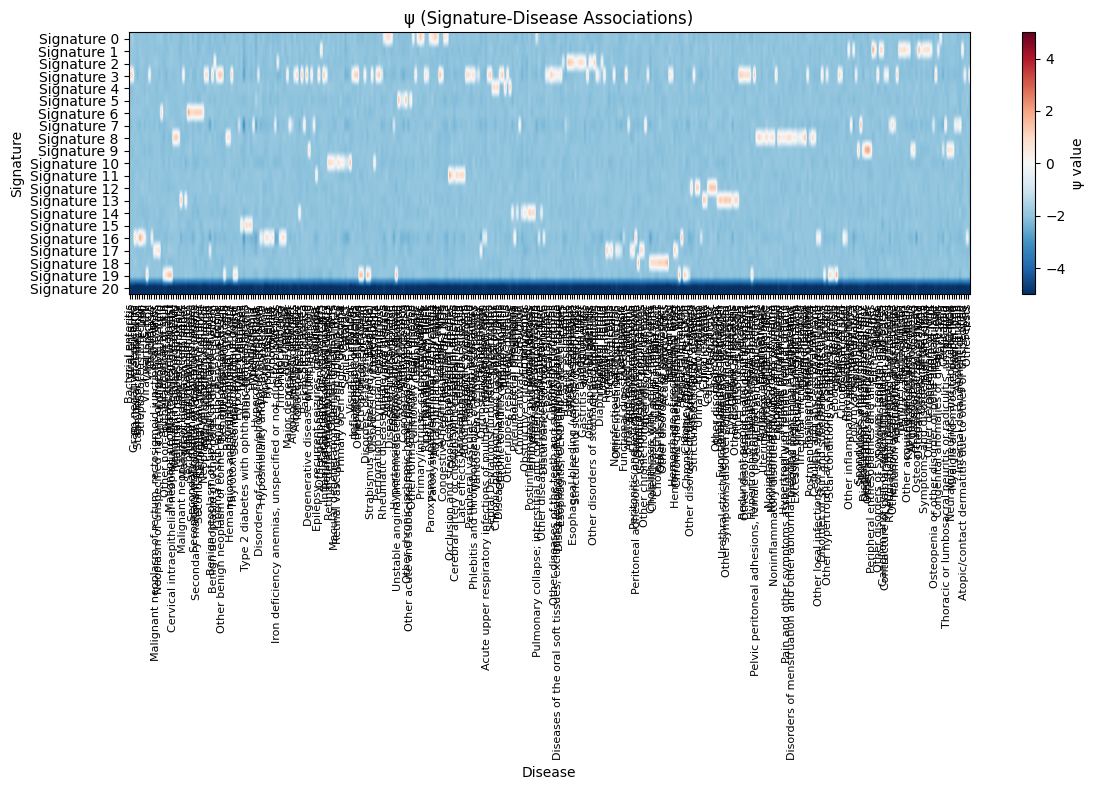

In [49]:
def plot_psi_heatmap(model, disease_names=None, figsize=(12, 8)):
    """
    Plot heatmap of psi values (signature-disease associations)
    
    Args:
        model: The trained model containing psi parameter
        disease_names: Optional list of disease names
        figsize: Tuple specifying figure size
    """
    plt.figure(figsize=figsize)
    
    # Get psi values from model
    psi = model.psi.detach().numpy()
    
    # Create heatmap
    im = plt.imshow(psi, aspect='auto', cmap='RdBu_r', vmin=-5, vmax=5)
    
    # Add colorbar
    plt.colorbar(im, label='ψ value')
    
    # Labels
    plt.xlabel('Disease')
    plt.ylabel('Signature')
    plt.title('ψ (Signature-Disease Associations)')
    
    # Optional: Add disease names if provided
    if disease_names is not None:
        plt.xticks(range(len(disease_names)), disease_names, 
                  rotation=90, fontsize=8)
    
    # Signature labels
    plt.yticks(range(psi.shape[0]), [f'Signature {i}' for i in range(psi.shape[0])])
    
    plt.tight_layout()
    plt.show()

# Usage:
plot_psi_heatmap(model, disease_names=essentials['disease_names'])  # if you have disease names
# or simply:
# plot_psi_heatmap(model)

Psi with kappa:
min=-5.270, max=2.017
mean=-2.040, std=0.861
max=2.017, std=0.861


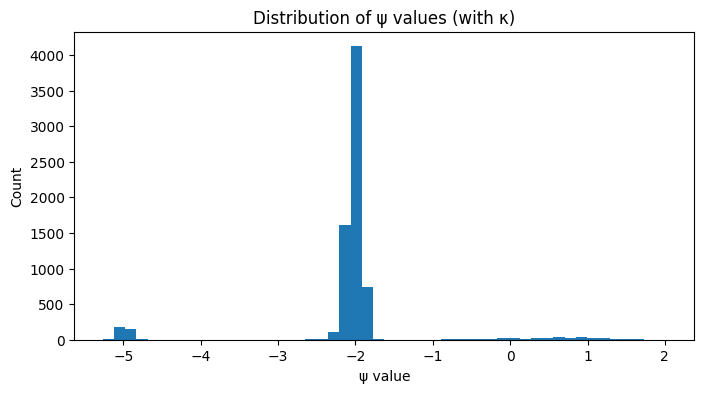

In [50]:
# For the notebook with kappa:
psi = model.psi.detach().numpy()
print("Psi with kappa:")
print(f"min={psi.min():.3f}, max={psi.max():.3f}")
print(f"mean={psi.mean():.3f}, std={psi.std():.3f}")
print(f"max={psi.max():.3f}, std={psi.std():.3f}")
# Quick histogram
plt.figure(figsize=(8, 4))
plt.hist(psi.flatten(), bins=50)
plt.title('Distribution of ψ values (with κ)')
plt.xlabel('ψ value')
plt.ylabel('Count')
plt.show()

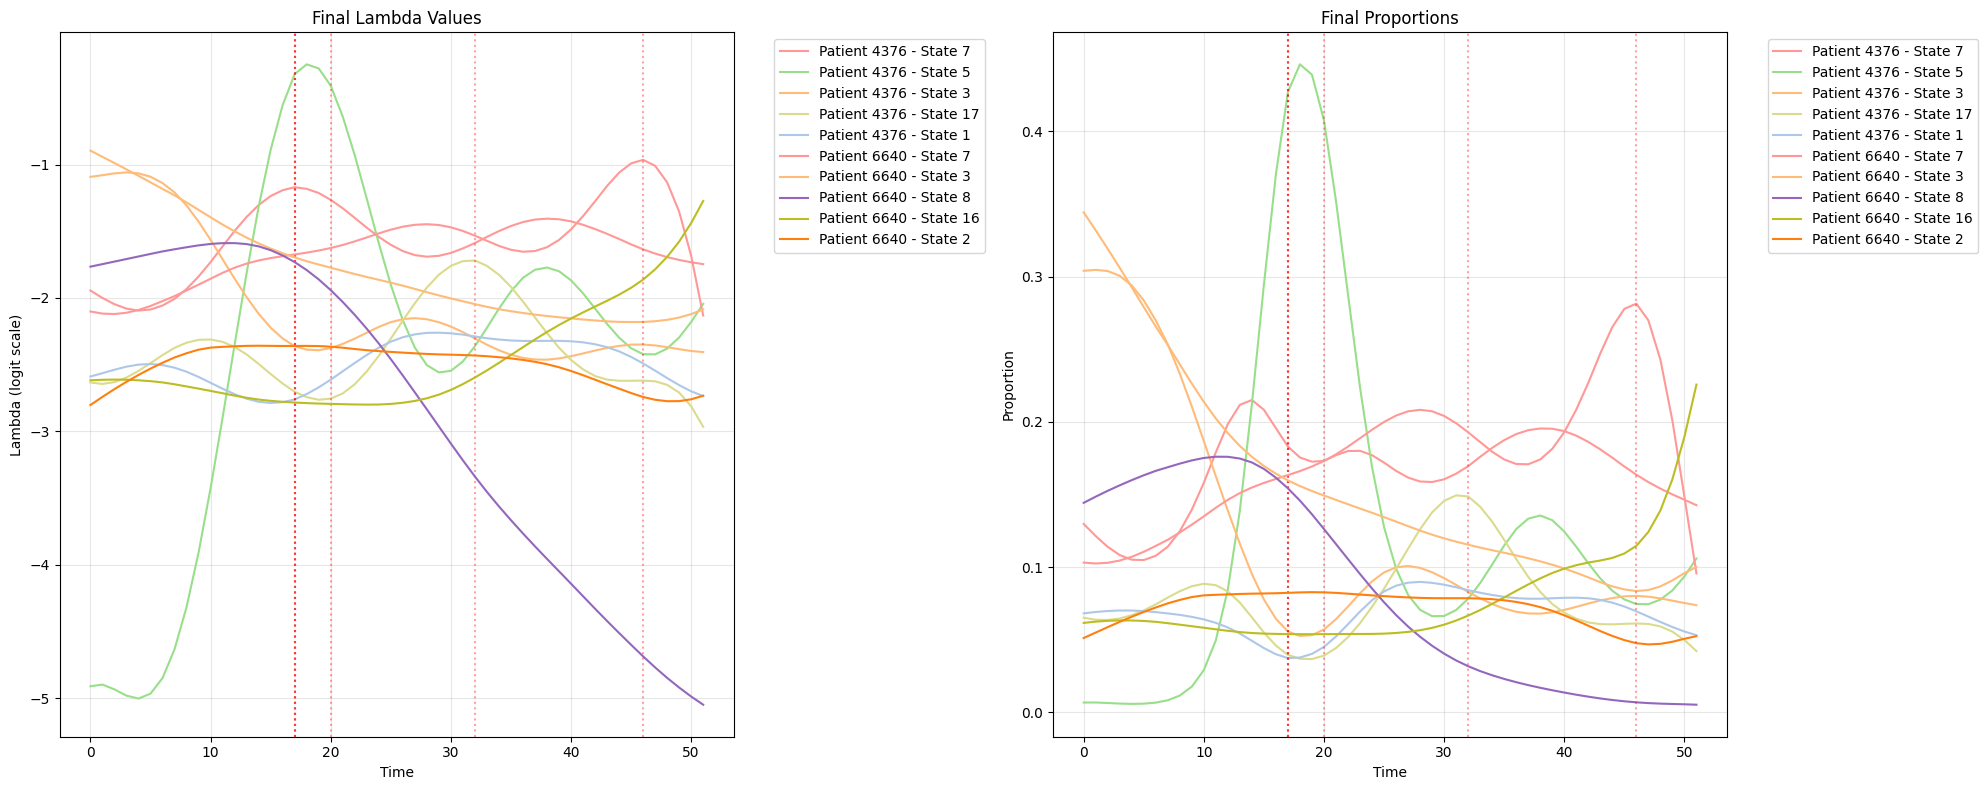


Genetic Effect Statistics for Sample Patients:

Patient 4376:
Mean shift: 0.058
Std of shifts: 0.155
Range of shifts: [-0.184, 0.446]

Top states and average proportions:
State 7: 0.165
State 5: 0.127
State 3: 0.121
State 17: 0.078
State 1: 0.068

Patient 6640:
Mean shift: 0.038
Std of shifts: 0.089
Range of shifts: [-0.147, 0.204]

Top states and average proportions:
State 7: 0.175
State 3: 0.157
State 8: 0.085
State 16: 0.078
State 2: 0.071


In [51]:
# Sample patients and set parameters
n_samples = 2
sample_patients = [4376, 6640]  # Use specific patients
n_top_states = 5  # Show only top 5 states per patient

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
time_points = np.arange(model.T)

# Get dominant states for these patients
lambda_patients = model.lambda_[sample_patients]  # [2, K, T]
patient_props = torch.softmax(lambda_patients, dim=1)  # [2, K, T]
mean_props = patient_props.mean(dim=-1)  # Average over time, now [2, K]
top_states = mean_props.topk(n_top_states, dim=-1).indices  # Get top states for each patient

# Color map for consistent colors across patients
colors = plt.cm.tab20(np.linspace(0, 1, model.K))

# Plot for each patient
for i, patient in enumerate(sample_patients):
    # Get diagnosis times for this patient
    diagnoses = model.Y[patient]  # Shape: [D, T]
    diagnosis_times = []
    for d in range(model.D):
        diag_time = torch.where(diagnoses[d])[0]
        if len(diag_time) > 0:
            diagnosis_times.append(diag_time[0].item())
            
    for j, k in enumerate(top_states[i]):
        k = k.item()  # Convert tensor to int
        color = colors[k]
        
        # Plot lambda values
        ax1.plot(time_points, model.lambda_[patient, k].detach(), '-', color=color,
                label=f'Patient {patient} - State {k}')
        
        # Plot proportions
        patient_props = torch.softmax(model.lambda_[patient].detach(), dim=0)[k]
        ax2.plot(time_points, patient_props, '-', color=color,
                label=f'Patient {patient} - State {k}')
    
    # Add vertical lines for diagnoses
    for t in diagnosis_times:
        ax1.axvline(x=t, color='red', alpha=0.2, linestyle=':')
        ax2.axvline(x=t, color='red', alpha=0.2, linestyle=':')

# Customize plots
ax1.set_title('Final Lambda Values')
ax1.set_xlabel('Time')
ax1.set_ylabel('Lambda (logit scale)')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_title('Final Proportions')
ax2.set_xlabel('Time')
ax2.set_ylabel('Proportion')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print genetic effects and top states
print("\nGenetic Effect Statistics for Sample Patients:")
for i, patient in enumerate(sample_patients):
    genetic_effects = model.genetic_scale * (model.G[patient] @ model.gamma).detach()
    print(f"\nPatient {patient}:")
    print(f"Mean shift: {genetic_effects.mean():.3f}")
    print(f"Std of shifts: {genetic_effects.std():.3f}")
    print(f"Range of shifts: [{genetic_effects.min():.3f}, {genetic_effects.max():.3f}]")
    
    # Print top states and their proportions
    patient_mean_props = mean_props[i]
    top_props, top_indices = patient_mean_props.topk(n_top_states)
    print("\nTop states and average proportions:")
    for state, prop in zip(top_indices, top_props):
        print(f"State {state.item()}: {prop:.3f}")

In [52]:
model_save_path='/Users/sarahurbut/Dropbox/model_with_kappa_bigam_mud.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'clusters': model.clusters,
    'initial_phi': initial_phi, 
    'initial_lambda': initial_lambda, 
    'psi': model.psi,
    'Y': Y_100k,
    'prevalence_t': essentials['prevalence_t'],
    'logit_prevalence_t': model.logit_prev_t,
    'G': G_100k,
    'E': E_100k,
    'indices': indices,
    'disease_names': essentials['disease_names'],
    'hyperparameters': {
        'N': Y_100k.shape[0],
        'D': Y_100k.shape[1],
        'T': Y_100k.shape[2],
        'P': G_100k.shape[1],
        'K': model.phi.shape[0]
    }
}, model_save_path)

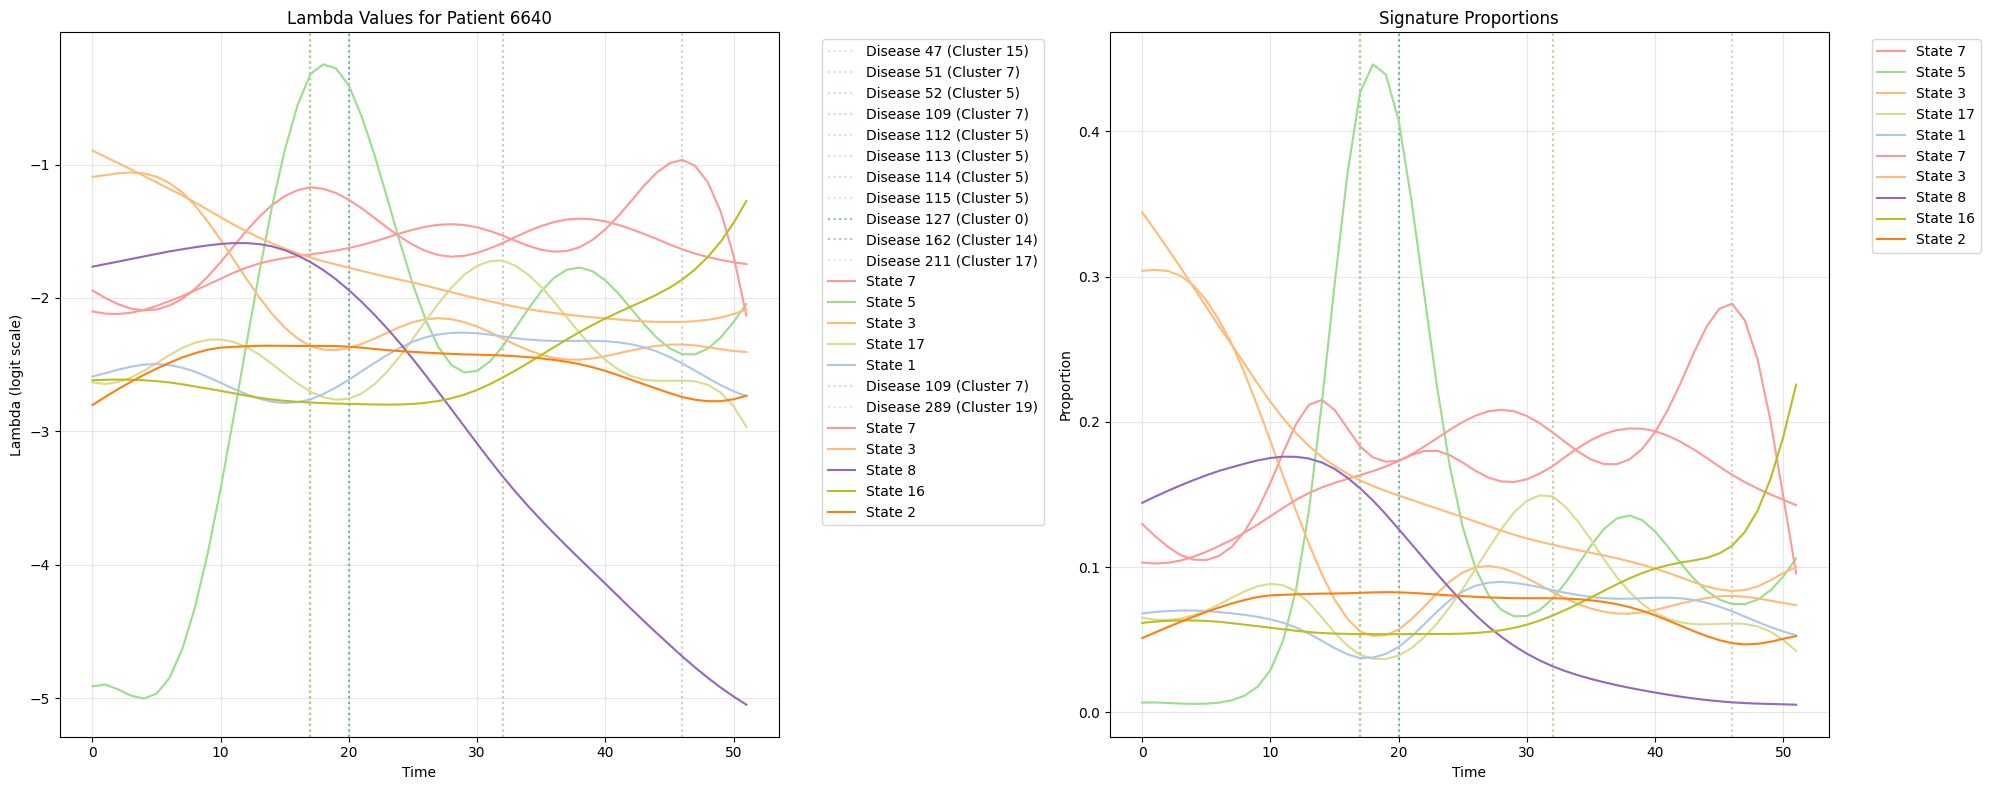

In [53]:
n_samples = 2
sample_patients = [4376, 6640]
n_top_states = 5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
time_points = np.arange(model.T)

# Get dominant states for these patients
lambda_patients = model.lambda_[sample_patients]
patient_props = torch.softmax(lambda_patients, dim=1)
mean_props = patient_props.mean(dim=-1)
top_states = mean_props.topk(n_top_states, dim=-1).indices

# Color map for states
colors = plt.cm.tab20(np.linspace(0, 1, model.K))

# Plot for each patient
for i, patient in enumerate(sample_patients):
    # Get diagnosis times and associated clusters
    diagnoses = model.Y[patient]  # Shape: [D, T]
    for d in range(model.D):
        diag_times = torch.where(diagnoses[d])[0]
        if len(diag_times) > 0:
            diag_time = diag_times[0].item()
            # Get cluster assignment for this disease
            cluster = model.clusters[d]
            # Use cluster's color for the vertical line
            ax1.axvline(x=diag_time, color=colors[cluster], alpha=0.5, linestyle=':', 
                       label=f'Disease {d} (Cluster {cluster})')
            ax2.axvline(x=diag_time, color=colors[cluster], alpha=0.5, linestyle=':')
            
    # Plot lambda trajectories
    for j, k in enumerate(top_states[i]):
        k = k.item()
        color = colors[k]
        
        # Plot lambda values
        ax1.plot(time_points, model.lambda_[patient, k].detach(), '-', color=color,
                label=f'State {k}')
        
        # Plot proportions
        patient_props = torch.softmax(model.lambda_[patient].detach(), dim=0)[k]
        ax2.plot(time_points, patient_props, '-', color=color,
                label=f'State {k}')

# Customize plots
ax1.set_title(f'Lambda Values for Patient {patient}')
ax1.set_xlabel('Time')
ax1.set_ylabel('Lambda (logit scale)')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_title('Signature Proportions')
ax2.set_xlabel('Time')
ax2.set_ylabel('Proportion')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [54]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the RDS file
readRDS = robjects.r['readRDS']
pce_data = readRDS('/Users/sarahurbut/Dropbox/pce_df_prevent.rds')
pce_df = pandas2ri.rpy2py(pce_data)  # Convert to pandas DataFrame


In [55]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_pred, label):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, label=label)

In [56]:
Y.shape

(10000, 348, 52)

# Now plot using just the time point (ie not accumulated)


ROC AUC Comparison (10-year prediction from enrollment):
Our model: 0.772
PCE: 0.678


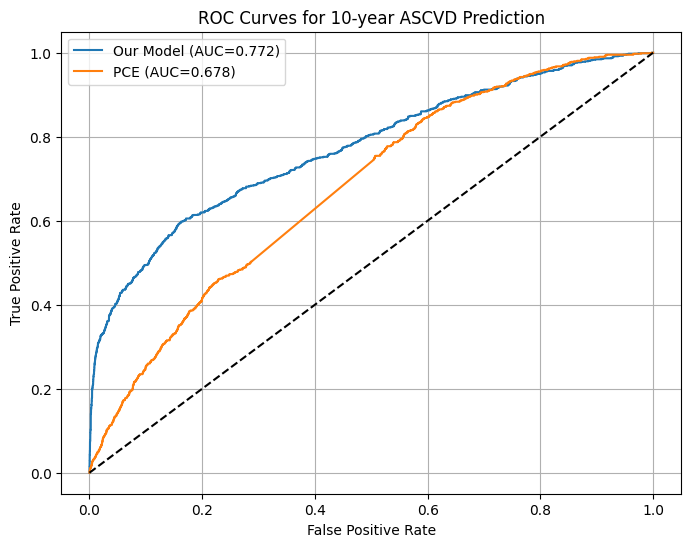

In [57]:
def compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116]):
    """
    Compare 10-year predictions using single timepoint prediction
    """
    our_10yr_risks = []
    actual_10yr = []

    # Get predictions
    pi = model.forward()[0].detach().numpy()
    
    # Get mean risks across patients for calibration
    predicted_risk_2d = pi.mean(axis=0)  # Shape: [D, T]
    observed_risk_2d = model.Y.numpy().mean(axis=0)  # Shape: [D, T]
    
    # Sort and get LOESS calibration curve
    pred_flat = predicted_risk_2d.flatten()
    obs_flat = observed_risk_2d.flatten()
    sort_idx = np.argsort(pred_flat)
    smoothed = lowess(obs_flat[sort_idx], pred_flat[sort_idx], frac=0.3)
    
    # Apply calibration to all predictions using interpolation
    pi_calibrated = np.interp(pi.flatten(), smoothed[:, 0], smoothed[:, 1]).reshape(pi.shape)
    
    # Calculate 10-year risks using only enrollment time prediction
    for patient_idx, row in enumerate(pce_df.itertuples()):
        enroll_time = int(row.age - 30)
        if enroll_time + 10 >= model.T:
            continue
            
        # Only use predictions at enrollment time
        pi_ascvd = pi_calibrated[patient_idx, ascvd_indices, enroll_time]
        
        # Calculate 1-year risk first
        yearly_risk = 1 - np.prod(1 - pi_ascvd)
        
        # Convert to 10-year risk
        risk = 1 - (1 - yearly_risk)**10
        our_10yr_risks.append(risk)
        
        # Still look at actual events over 10 years
        Y_ascvd = model.Y[patient_idx, ascvd_indices, enroll_time:enroll_time+10]
        actual = torch.any(torch.any(Y_ascvd, dim=0))
        actual_10yr.append(actual.item())
   
    # Rest of the function remains the same
    our_10yr_risks = np.array(our_10yr_risks)
    actual_10yr = np.array(actual_10yr)
    pce_risks = pce_df['pce_goff_fuull'].values[:len(our_10yr_risks)]
    
    # Calculate ROC AUCs
    our_auc = roc_auc_score(actual_10yr, our_10yr_risks)
    pce_auc = roc_auc_score(actual_10yr, pce_risks)
    
    print(f"\nROC AUC Comparison (10-year prediction from enrollment):")
    print(f"Our model: {our_auc:.3f}")
    print(f"PCE: {pce_auc:.3f}")
    
    plt.figure(figsize=(8,6))
    plot_roc_curve(actual_10yr, our_10yr_risks, label=f'Our Model (AUC={our_auc:.3f})')
    plot_roc_curve(actual_10yr, pce_risks, label=f'PCE (AUC={pce_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for 10-year ASCVD Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116])

# omit missing

In [58]:
def compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116]):
    """
    Compare 10-year predictions using single timepoint prediction, handling missing PCE values
    """
    our_10yr_risks = []
    actual_10yr = []

    # Get predictions
    pi = model.forward()[0].detach().numpy()
    
    # Get mean risks across patients for calibration
    predicted_risk_2d = pi.mean(axis=0)  # Shape: [D, T]
    observed_risk_2d = model.Y.numpy().mean(axis=0)  # Shape: [D, T]
    
    # Sort and get LOESS calibration curve
    pred_flat = predicted_risk_2d.flatten()
    obs_flat = observed_risk_2d.flatten()
    sort_idx = np.argsort(pred_flat)
    smoothed = lowess(obs_flat[sort_idx], pred_flat[sort_idx], frac=0.3)
    
    # Apply calibration to all predictions using interpolation
    pi_calibrated = np.interp(pi.flatten(), smoothed[:, 0], smoothed[:, 1]).reshape(pi.shape)
    
    # Calculate 10-year risks using only enrollment time prediction
    for patient_idx, row in enumerate(pce_df.itertuples()):
        enroll_time = int(row.age - 30)
        if enroll_time + 10 >= model.T:
            continue
            
        # Only use predictions at enrollment time
        pi_ascvd = pi_calibrated[patient_idx, ascvd_indices, enroll_time]
        
        # Calculate 1-year risk first
        yearly_risk = 1 - np.prod(1 - pi_ascvd)
        
        # Convert to 10-year risk
        risk = 1 - (1 - yearly_risk)**10
        our_10yr_risks.append(risk)
        
        # Still look at actual events over 10 years
        Y_ascvd = model.Y[patient_idx, ascvd_indices, enroll_time:enroll_time+10]
        actual = torch.any(torch.any(Y_ascvd, dim=0))
        actual_10yr.append(actual.item())
   
    our_10yr_risks = np.array(our_10yr_risks)
    actual_10yr = np.array(actual_10yr)
    pce_risks = pce_df['pce_goff'].values[:len(our_10yr_risks)]

    # Get indices of non-missing PCE values
    non_missing_idx = ~np.isnan(pce_risks)

    # Filter all arrays to only include non-missing cases
    our_10yr_risks_filtered = our_10yr_risks[non_missing_idx]
    actual_10yr_filtered = actual_10yr[non_missing_idx]
    pce_risks_filtered = pce_risks[non_missing_idx]

    # Calculate ROC AUCs on filtered data
    our_auc = roc_auc_score(actual_10yr_filtered, our_10yr_risks_filtered)
    pce_auc = roc_auc_score(actual_10yr_filtered, pce_risks_filtered)

    # Print results with sample size info
    n_total = len(our_10yr_risks)
    n_complete = len(our_10yr_risks_filtered)
    print(f"\nROC AUC Comparison (10-year prediction from enrollment):")
    print(f"Sample size: {n_complete}/{n_total} ({n_complete/n_total*100:.1f}% complete cases)")
    print(f"Our model: {our_auc:.3f}")
    print(f"PCE: {pce_auc:.3f}")
    
    plt.figure(figsize=(8,6))
    plot_roc_curve(actual_10yr_filtered, our_10yr_risks_filtered, label=f'Our Model (AUC={our_auc:.3f})')
    plot_roc_curve(actual_10yr_filtered, pce_risks_filtered, label=f'PCE (AUC={pce_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for 10-year ASCVD Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

    return our_10yr_risks_filtered, actual_10yr_filtered, pce_risks_filtered


ROC AUC Comparison (10-year prediction from enrollment):
Sample size: 7817/10000 (78.2% complete cases)
Our model: 0.777
PCE: 0.711


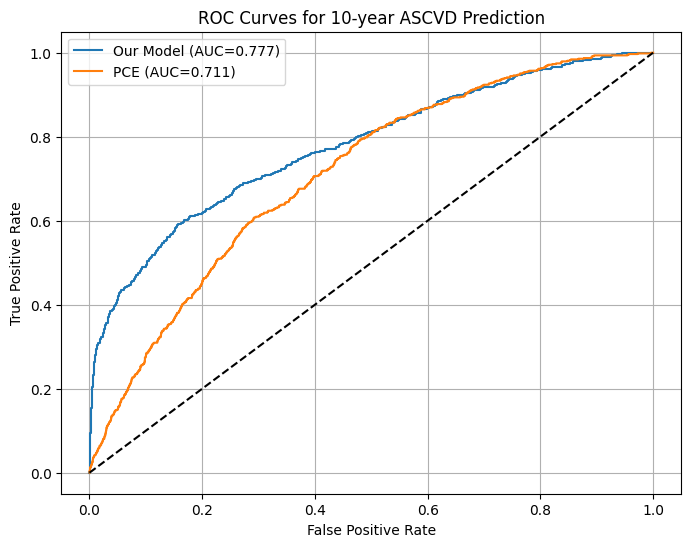

(array([0.14682707, 0.00587391, 0.12665353, ..., 0.17777364, 0.07129884,
        0.01458839]),
 array([False, False, False, ...,  True, False, False]),
 array([0.20861924, 0.12870708, 0.12895867, ..., 0.13201657, 0.11094535,
        0.0075447 ]))

In [59]:
compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116])

Number of diseases: 348, Number of timepoints: 52
Overall mean predicted risk: 0.000461
Overall mean observed risk: 0.000401
Overall calibration factor: 0.8694


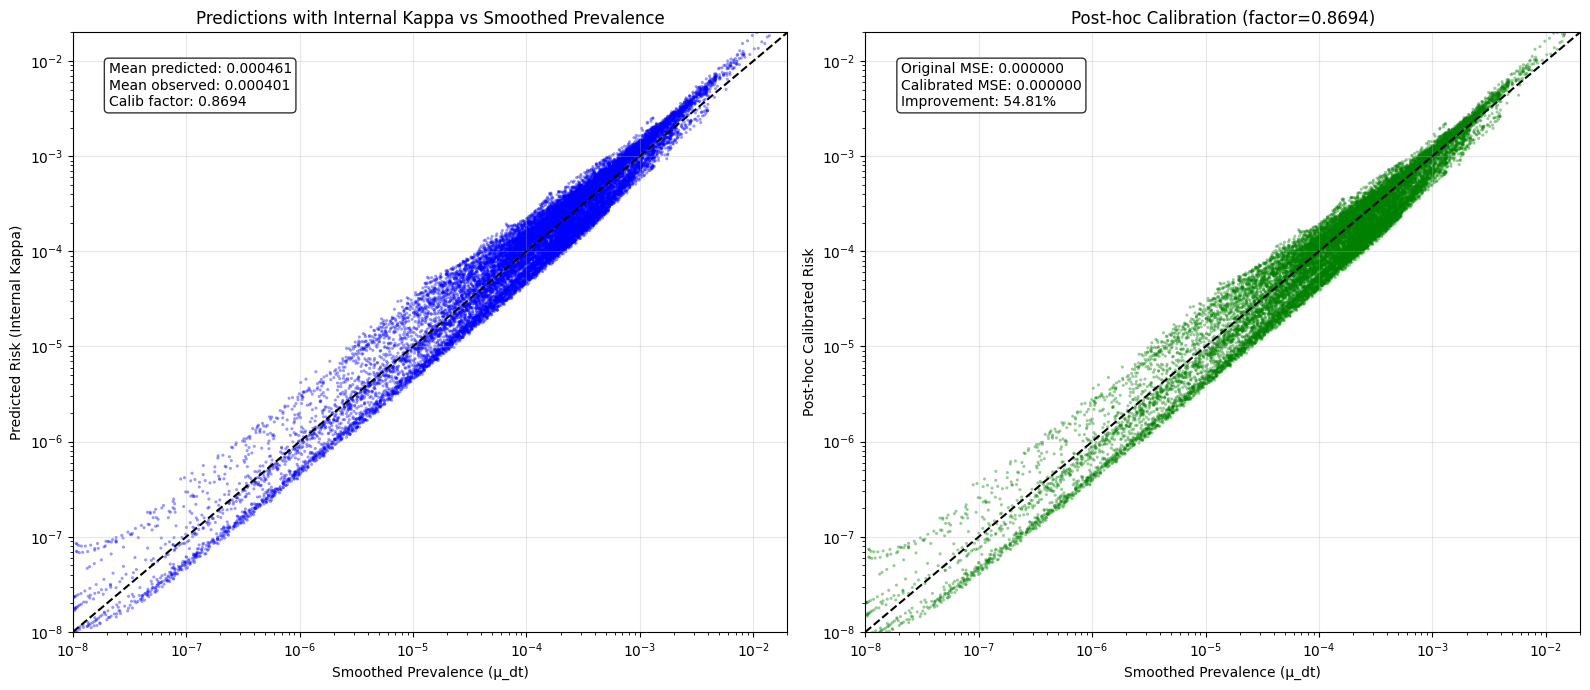


Calibration with Internal Kappa:
Mean predicted risk: 0.000461
Mean observed prevalence: 0.000401
Calibration factor needed: 0.8694
MSE before post-hoc calibration: 0.000000
MSE after post-hoc calibration: 0.000000
Improvement from post-hoc calibration: 54.81%


In [60]:
def analyze_internal_kappa_calibration(model, mu_dt):
    """
    Analyze calibration for a model with internal kappa implementation
    
    Args:
        model: The loaded model with internal kappa
        mu_dt: The observed prevalence matrix
    
    Returns:
        Calibration plot figure
    """
    # Get predictions from the model
    with torch.no_grad():
        pi, theta, phi_prob = model.forward()
    
    # Convert to numpy for analysis
    pi_np = pi.detach().numpy()
    
    # Aggregate predictions and observations
    all_pi_values = []
    all_mu_dt_values = []
    
    n_diseases, n_timepoints = mu_dt.shape
    print(f"Number of diseases: {n_diseases}, Number of timepoints: {n_timepoints}")
    
    # Aggregate pi values for each disease and timepoint
    for d in range(n_diseases):
        for t in range(n_timepoints):
            # Get valid entries (non-NaN) for this disease and timepoint
            valid_mask = ~np.isnan(pi_np[:, d, t])
            n_valid = np.sum(valid_mask)
            
            if n_valid > 0:
                avg_pi_dt = np.mean(pi_np[valid_mask, d, t])
                all_pi_values.append(avg_pi_dt)
                all_mu_dt_values.append(mu_dt[d, t])
    
    # Convert to numpy arrays
    all_pi_values = np.array(all_pi_values)
    all_mu_dt_values = np.array(all_mu_dt_values)
    
    # Calculate calibration factor
    valid_mask = (all_pi_values > 0) & (all_mu_dt_values > 0)
    pi_valid = all_pi_values[valid_mask]
    mu_dt_valid = all_mu_dt_values[valid_mask]
    
    mean_pred = np.mean(pi_valid)
    mean_obs = np.mean(mu_dt_valid)
    calib_factor = mean_obs / mean_pred
    
    print(f"Overall mean predicted risk: {mean_pred:.6f}")
    print(f"Overall mean observed risk: {mean_obs:.6f}")
    print(f"Overall calibration factor: {calib_factor:.4f}")
    
    # Create figure with two plots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Original predictions vs. smoothed prevalence
    ax1.scatter(mu_dt_valid, pi_valid, alpha=0.4, s=5, color='blue', edgecolor='none')
    ax1.plot([1e-8, 2e-2], [1e-8, 2e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax1.set_ylabel('Predicted Risk (Internal Kappa)')
    ax1.set_title('Predictions with Internal Kappa vs Smoothed Prevalence')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(1e-8, 2e-2)
    ax1.set_ylim(1e-8, 2e-2)
    ax1.grid(True, alpha=0.3)
    
    # Add text with calibration metrics
    ax1.text(0.05, 0.95, 
             f"Mean predicted: {mean_pred:.6f}\nMean observed: {mean_obs:.6f}\nCalib factor: {calib_factor:.4f}", 
             transform=ax1.transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 2: Post-hoc calibrated predictions
    scaled_pi = pi_valid * calib_factor
    
    ax2.scatter(mu_dt_valid, scaled_pi, alpha=0.4, s=5, color='green', edgecolor='none')
    ax2.plot([1e-8, 2e-2], [1e-8, 2e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax2.set_ylabel('Post-hoc Calibrated Risk')
    ax2.set_title(f'Post-hoc Calibration (factor={calib_factor:.4f})')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(1e-8, 2e-2)
    ax2.set_ylim(1e-8, 2e-2)
    ax2.grid(True, alpha=0.3)
    
    # Add text with calibration improvement metrics
    mse_orig = np.mean((pi_valid - mu_dt_valid)**2)
    mse_calib = np.mean((scaled_pi - mu_dt_valid)**2)
    improvement = (mse_orig - mse_calib) / mse_orig * 100
    
    ax2.text(0.05, 0.95, 
             f"Original MSE: {mse_orig:.6f}\nCalibrated MSE: {mse_calib:.6f}\nImprovement: {improvement:.2f}%", 
             transform=ax2.transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nCalibration with Internal Kappa:")
    print(f"Mean predicted risk: {mean_pred:.6f}")
    print(f"Mean observed prevalence: {mean_obs:.6f}")
    print(f"Calibration factor needed: {calib_factor:.4f}")
    print(f"MSE before post-hoc calibration: {mse_orig:.6f}")
    print(f"MSE after post-hoc calibration: {mse_calib:.6f}")
    print(f"Improvement from post-hoc calibration: {improvement:.2f}%")
    
    return fig, all_pi_values, all_mu_dt_values, calib_factor

# Usage example:
# Assuming you have your model and mu_dt (prevalence matrix) available
mu_dt = essentials['prevalence_t'] # Shape: (348, 52)
fig, all_pi, all_mu_dt, calib_factor = analyze_internal_kappa_calibration(model, mu_dt)

In [ ]:
pce_df.head()

In [ ]:
pce_df_2 = pd.read_csv('/Users/sarahurbut/Dropbox/all_pce_prevent_ukb_dat_ordered.csv')
pce_df_2.head()

In [ ]:
def validate_batch1_only(pce_df, ascvd_indices=[111,112,113,114,115,116]):
    """
    Validate using only batch 1's model and data to ensure we get similar results to before
    """
    # Load batch 1 model
    model_path = '/Users/sarahurbut/Dropbox/resultshighamp/results/output_0_10000/model.pt'
    print("\nLoading batch 1 model...")
    
    try:
        model = torch.load(model_path)
        model_dict = model['model_state_dict']
        
        # Get phi and lambda from batch 1
        phi_raw = model_dict['phi']
        phi = torch.sigmoid(phi_raw).detach().numpy()
        lambda_values = model_dict['lambda_']
        theta = torch.softmax(lambda_values, dim=1).detach().numpy()
        Y_batch = model['Y'].numpy()
        
        # Calculate pi for batch 1
        pi_batch = np.einsum('nkt,kdt->ndt', theta, phi)
        
        our_10yr_risks = []
        actual_10yr = []
        patient_indices = []
        
        # Process only first 10k patients
        batch_df = pce_df.iloc[:10000]
        
        for i, row in enumerate(batch_df.itertuples()):
            if np.isnan(row.pce):
                continue
                
            enroll_time = int(row.age - 30) if hasattr(row, 'age') else 0
            if enroll_time + 10 >= Y_batch.shape[2]:
                continue
                
            pi_ascvd = pi_batch[i, ascvd_indices, enroll_time]
            yearly_risk = 1 - np.prod(1 - pi_ascvd)
            risk = 1 - (1 - yearly_risk)**10
            our_10yr_risks.append(risk)
            
            Y_ascvd = Y_batch[i, ascvd_indices, enroll_time:enroll_time+10]
            actual = np.any(Y_ascvd)
            actual_10yr.append(actual)
            patient_indices.append(i)
            
        our_10yr_risks = np.array(our_10yr_risks)
        actual_10yr = np.array(actual_10yr)
        pce_risks = pce_df.iloc[patient_indices]['pce'].values
        
        # Calculate and plot ROC curves
        our_auc = roc_auc_score(actual_10yr, our_10yr_risks)
        pce_auc = roc_auc_score(actual_10yr, pce_risks)

        plt.figure(figsize=(8,6))
        plot_roc_curve(actual_10yr, our_10yr_risks, label=f'Our Model (AUC={our_auc:.3f})')
        plot_roc_curve(actual_10yr, pce_risks, label=f'PCE (AUC={pce_auc:.3f})')
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves for 10-year ASCVD Prediction (Batch 1 Only)')
        plt.legend()
        plt.grid(True)
        plt.show()

        return our_10yr_risks, actual_10yr, pce_risks
        
    except FileNotFoundError:
        print("ERROR: Could not find batch 1 model file!")
        return None, None, None

# Usage:
our_risks, actual_outcomes, pce_risks = validate_batch1_only(pce_df)

In [ ]:
import pandas as pd
pce_df = pd.read_csv('/Users/sarahurbut/Dropbox/all_pce_prevent_ukb_dat_ordered.csv')
pce_df = pd.read_csv('/Users/sarahurbut/Dropbox/pce_fgoff_prevent_full400.csv')

%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

In [26]:
readRDS = robjects.r['readRDS']
pce_data = readRDS('/Users/sarahurbut/Dropbox/pce_df_prevent.rds')
pce_df = pandas2ri.rpy2py(pce_data)  # Convert to pandas DataFrame


In [ ]:
pce_df.head()

In [ ]:
def validate_pce_with_enrollment(pce_df, ascvd_indices=[111,112,113,114,115,116]):
    """
    Validate using proper enrollment times calculated from birth_year and enrollment date
    """
    # Calculate age at enrollment
    pce_df['enrollment_year'] = pd.to_datetime(pce_df['enrollment']).dt.year
    pce_df['age_at_enrollment'] = pce_df['enrollment_year'] - pce_df['birth_year']
    
    model_path = '/Users/sarahurbut/Dropbox/resultshighamp/results/output_0_10000/model.pt'
    print("\nLoading batch 1 model...")
    
    try:
        model = torch.load(model_path)
        Y_batch = model['Y'].numpy()
        
        actual_10yr = []
        patient_indices = []
        pce_risks = []
        
        # Process first 10k patients
        batch_df = pce_df.iloc[:10000]
        
        for i, row in enumerate(batch_df.itertuples()):
            if np.isnan(row.pce):
                continue
                
            # Calculate proper enrollment time
            #enroll_time = int(row.age_at_enrollment - 30)  # Assuming time starts at age 30
            enroll_time = int(row.age - 30) if hasattr(row, 'age') else 0
            if enroll_time + 10 >= Y_batch.shape[2]:
                continue
                
            Y_ascvd = Y_batch[i, ascvd_indices, enroll_time:enroll_time+10]
            actual = np.any(Y_ascvd)
            actual_10yr.append(actual)
            patient_indices.append(i)
            pce_risks.append(row.pce)
            
        print(f"\nAge at enrollment range: [{batch_df['age_at_enrollment'].min():.0f}, {batch_df['age_at_enrollment'].max():.0f}]")
        print(f"Number of events: {sum(actual_10yr)}/{len(actual_10yr)} ({sum(actual_10yr)/len(actual_10yr)*100:.1f}%)")
        
        actual_10yr = np.array(actual_10yr)
        pce_risks = np.array(pce_risks)
        
        # Calculate and plot ROC curve
        pce_auc = roc_auc_score(actual_10yr, pce_risks)

        plt.figure(figsize=(8,6))
        plot_roc_curve(actual_10yr, pce_risks, label=f'PCE (AUC={pce_auc:.3f})')
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for PCE 10-year ASCVD Prediction')
        plt.legend()
        plt.grid(True)
        plt.show()

        return actual_10yr, pce_risks
        
    except FileNotFoundError:
        print("ERROR: Could not find batch 1 model file!")
        return None, None

# Usage:
actual_outcomes, pce_risks = validate_pce_with_enrollment(pce_df)

In [ ]:
import time
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def plot_roc_curve(y_true, y_pred, label):
    """
    Plot ROC curve given true labels and predicted probabilities
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels
    y_pred : array-like
        Predicted probabilities
    label : str
        Label for the ROC curve in the plot legend
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, label=label)
    

def compare_across_batches_pce(pce_df, ascvd_indices=[111,112,113,114,115,116], batch_size=10000):
    """
    Use batch 1's phi to estimate pis for batches 2-40, comparing with PCE scores
    """
    # Calculate age at enrollment first
    #pce_df['enrollment_year'] = pd.to_datetime(pce_df['enrollment']).dt.year
    #pce_df['age_at_enrollment'] = pce_df['enrollment_year'] - pce_df['birth_year']
    
    our_10yr_risks = []
    actual_10yr = []
    patient_indices = []
    
    print("Starting calculations...")
    print(f"Total patients in pce_df: {len(pce_df)}")
    print(f"Number with valid PCE scores: {sum(~np.isnan(pce_df['pce']))}")
    
    # Load batch 1's phi - this is our "deploy once" model
    model_path = '/Users/sarahurbut/Dropbox/resultshighamp/results/output_0_10000/model.pt'
    print("\nLoading batch 1 model for phi values...")
    
    try:
        model = torch.load(model_path)
        model_dict = model['model_state_dict']
        phi_raw = model_dict['phi']
        phi = torch.sigmoid(phi_raw).detach().numpy()
        print("Successfully loaded batch 1 phi")
    except FileNotFoundError:
        print("ERROR: Could not find batch 1 model file!")
        return None, None, None
    
    total_patients = len(pce_df)
    n_batches = (total_patients + batch_size - 1) // batch_size
    start_time = time.time()
    
    # Process each batch using batch 1's phi
    for batch in range(1, n_batches):  # Start from batch 2
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, total_patients)
        
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        print(f"\nProcessing batch {batch+1}/{n_batches} (patients {start_idx}-{end_idx})")
        
        try:
            model = torch.load(model_path)
            model_dict = model['model_state_dict']
            
            # Get lambda values and Y for this batch
            lambda_values = model_dict['lambda_']
            theta = torch.softmax(lambda_values, dim=1).detach().numpy()
            Y_batch = model['Y'].numpy()
            
            # Calculate pi using batch 1's phi (no retraining needed)
            pi_batch = np.einsum('nkt,kdt->ndt', theta, phi)
            
            # Process each patient using their actual enrollment age
            batch_df = pce_df.iloc[start_idx:end_idx]
            skipped_pce = 0
            skipped_horizon = 0
            
            for i, row in enumerate(batch_df.itertuples()):
                if np.isnan(row.pce):
                    skipped_pce += 1
                    continue
                    
                # Use actual enrollment age
                enroll_time = int(row.age - 30)
                if enroll_time + 10 >= Y_batch.shape[2]:
                    skipped_horizon += 1
                    continue
                    
                pi_ascvd = pi_batch[i, ascvd_indices, enroll_time]
                yearly_risk = 1 - np.prod(1 - pi_ascvd)
                risk = 1 - (1 - yearly_risk)**10
                our_10yr_risks.append(risk)
                
                Y_ascvd = Y_batch[i, ascvd_indices, enroll_time:enroll_time+10]
                actual = np.any(Y_ascvd)
                actual_10yr.append(actual)
                patient_indices.append(start_idx + i)
            
            print(f"\nBatch summary:")
            print(f"Skipped due to missing PCE: {skipped_pce}")
            print(f"Skipped due to insufficient horizon: {skipped_horizon}")
            print(f"Successfully processed: {len(our_10yr_risks) - (len(patient_indices) - len(our_10yr_risks))}")
            
            del model_dict, theta, pi_batch, Y_batch
            
        except FileNotFoundError:
            print(f"Warning: Could not find model file for batch {batch}")
            continue

    if len(our_10yr_risks) == 0:
        print("\nERROR: No valid predictions were made!")
        return None, None, None
        
    our_10yr_risks = np.array(our_10yr_risks)
    actual_10yr = np.array(actual_10yr)
    patient_indices = np.array(patient_indices)
    pce_risks = pce_df.iloc[patient_indices]['pce'].values
    
    print("\nFinal Summary:")
    print(f"Total processing time: {(time.time() - start_time)/60:.2f} minutes")
    print(f"Number of predictions made: {len(our_10yr_risks)}")
    print(f"Number of actual events: {sum(actual_10yr)}")
    print(f"Event rate: {sum(actual_10yr)/len(actual_10yr)*100:.2f}%")

    # Calculate and plot ROC curves
    our_auc = roc_auc_score(actual_10yr, our_10yr_risks)
    pce_auc = roc_auc_score(actual_10yr, pce_risks)

    plt.figure(figsize=(8,6))
    plot_roc_curve(actual_10yr, our_10yr_risks, label=f'Our Model (AUC={our_auc:.3f})')
    plot_roc_curve(actual_10yr, pce_risks, label=f'PCE (AUC={pce_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for 10-year ASCVD Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

    return our_10yr_risks, actual_10yr, pce_risks

# Usage:
our_risks, actual_outcomes, pce_risks = compare_across_batches_pce(pce_df)

In [ ]:
def compare_phi_approaches(pce_df, ascvd_indices=[111,112,113,114,115,116], batch_size=10000):
    """
    Compare performance using:
    1. Batch 1's phi (no retraining needed) - ideal for real-world deployment
    2. Each batch's own phi (requires retraining) - for comparison only
    """
    # Calculate age at enrollment
    #pce_df['enrollment_year'] = pd.to_datetime(pce_df['enrollment']).dt.year
    #pce_df['age_at_enrollment'] = pce_df['enrollment_year'] - pce_df['birth_year']
    
    # Initialize storage for both approaches
    batch1_risks = []
    local_risks = []
    actual_10yr = []
    pce_risks_all = []
    patient_indices = []
    
    # Load batch 1's phi - this represents our "deploy once" model
    model_path = '/Users/sarahurbut/Dropbox/resultshighamp/results/output_0_10000/model.pt'
    model = torch.load(model_path)
    batch1_phi = torch.sigmoid(model['model_state_dict']['phi']).detach().numpy()
    
    # Process each batch
    total_patients = len(pce_df)
    n_batches = (total_patients + batch_size - 1) // batch_size
    
    for batch in range(1, n_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, total_patients)
        
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        try:
            model = torch.load(model_path)
            model_dict = model['model_state_dict']
            
            # Get this batch's parameters
            local_phi = torch.sigmoid(model_dict['phi']).detach().numpy()
            theta = torch.softmax(model_dict['lambda_'], dim=1).detach().numpy()
            Y_batch = model['Y'].numpy()
            
            # Calculate predictions using both phis
            pi_batch1 = np.einsum('nkt,kdt->ndt', theta, batch1_phi)
            pi_local = np.einsum('nkt,kdt->ndt', theta, local_phi)
            
            batch_df = pce_df.iloc[start_idx:end_idx]
            
            for i, row in enumerate(batch_df.itertuples()):
                if np.isnan(row.pce):
                    continue
                    
                enroll_time = int(row.age - 30)
                if enroll_time + 10 >= Y_batch.shape[2]:
                    continue
                
                # Calculate risks using both approaches
                pi_ascvd_batch1 = pi_batch1[i, ascvd_indices, enroll_time]
                pi_ascvd_local = pi_local[i, ascvd_indices, enroll_time]
                
                yearly_risk_batch1 = 1 - np.prod(1 - pi_ascvd_batch1)
                yearly_risk_local = 1 - np.prod(1 - pi_ascvd_local)
                
                risk_batch1 = 1 - (1 - yearly_risk_batch1)**10
                risk_local = 1 - (1 - yearly_risk_local)**10
                
                batch1_risks.append(risk_batch1)
                local_risks.append(risk_local)
                
                Y_ascvd = Y_batch[i, ascvd_indices, enroll_time:enroll_time+10]
                actual_10yr.append(np.any(Y_ascvd))
                pce_risks_all.append(row.pce)
                patient_indices.append(start_idx + i)
                
            # Clear memory
            del model_dict, theta, pi_batch1, pi_local, Y_batch
            
        except FileNotFoundError:
            print(f"Warning: Could not find model file for batch {batch}")
            continue

    # Convert to arrays
    batch1_risks = np.array(batch1_risks)
    local_risks = np.array(local_risks)
    actual_10yr = np.array(actual_10yr)
    pce_risks_all = np.array(pce_risks_all)
    
    # Calculate AUCs
    batch1_auc = roc_auc_score(actual_10yr, batch1_risks)
    local_auc = roc_auc_score(actual_10yr, local_risks)
    pce_auc = roc_auc_score(actual_10yr, pce_risks_all)
    
    # Plot ROC curves
    plt.figure(figsize=(8,6))
    plot_roc_curve(actual_10yr, batch1_risks, label=f'Batch 1 Phi (AUC={batch1_auc:.3f})')
    plot_roc_curve(actual_10yr, local_risks, label=f'Local Phi (AUC={local_auc:.3f})')
    plot_roc_curve(actual_10yr, pce_risks_all, label=f'PCE (AUC={pce_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves: No Retraining vs Local Retraining')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("\nPerformance Summary:")
    print(f"Batch 1 Phi (no retraining): AUC = {batch1_auc:.3f}")
    print(f"Local Phi (with retraining): AUC = {local_auc:.3f}")
    print(f"PCE: AUC = {pce_auc:.3f}")
    
    return batch1_risks, local_risks, actual_10yr, pce_risks_all

# Usage:
batch1_risks, local_risks, actual_outcomes, pce_risks = compare_phi_approaches(pce_df)

In [ ]:
def compare_phi_approaches(pce_df, ascvd_indices=[111,112,113,114,115,116], batch_size=10000):
    """
    Compare performance using:
    1. Batch 1's phi (no retraining needed) - ideal for real-world deployment
    2. Each batch's own phi (requires retraining) - for comparison only
    """
    # Initialize storage for both approaches
    batch1_risks = []
    local_risks = []
    actual_10yr = []
    prevent_risks_all = []
    patient_indices = []
    
    # Load batch 1's phi - this represents our "deploy once" model
    model_path = '/Users/sarahurbut/Dropbox/resultshighamp/results/output_0_10000/model.pt'
    model = torch.load(model_path)
    batch1_phi = torch.sigmoid(model['model_state_dict']['phi']).detach().numpy()
    
    # Process each batch
    total_patients = len(pce_df)
    n_batches = (total_patients + batch_size - 1) // batch_size
    
    for batch in range(1, n_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, total_patients)
        
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        try:
            model = torch.load(model_path)
            model_dict = model['model_state_dict']
            
            # Get this batch's parameters
            local_phi = torch.sigmoid(model_dict['phi']).detach().numpy()
            theta = torch.softmax(model_dict['lambda_'], dim=1).detach().numpy()
            Y_batch = model['Y'].numpy()
            
            # Calculate predictions using both phis
            pi_batch1 = np.einsum('nkt,kdt->ndt', theta, batch1_phi)
            pi_local = np.einsum('nkt,kdt->ndt', theta, local_phi)
            
            batch_df = pce_df.iloc[start_idx:end_idx]
            
            for i, row in enumerate(batch_df.itertuples()):
                if np.isnan(row.prevent_base_ascvd_risk):  # Changed from pce
                    continue
                    
                enroll_time = int(row.age - 30)
                if enroll_time + 10 >= Y_batch.shape[2]:
                    continue
                
                # Calculate risks using both approaches
                pi_ascvd_batch1 = pi_batch1[i, ascvd_indices, enroll_time]
                pi_ascvd_local = pi_local[i, ascvd_indices, enroll_time]
                
                yearly_risk_batch1 = 1 - np.prod(1 - pi_ascvd_batch1)
                yearly_risk_local = 1 - np.prod(1 - pi_ascvd_local)
                
                risk_batch1 = 1 - (1 - yearly_risk_batch1)**10
                risk_local = 1 - (1 - yearly_risk_local)**10
                
                batch1_risks.append(risk_batch1)
                local_risks.append(risk_local)
                
                Y_ascvd = Y_batch[i, ascvd_indices, enroll_time:enroll_time+10]
                actual_10yr.append(np.any(Y_ascvd))
                prevent_risks_all.append(row.prevent_base_ascvd_risk)  # Changed from pce
                patient_indices.append(start_idx + i)
                
            # Clear memory
            del model_dict, theta, pi_batch1, pi_local, Y_batch
            
        except FileNotFoundError:
            print(f"Warning: Could not find model file for batch {batch}")
            continue

    # Convert to arrays
    batch1_risks = np.array(batch1_risks)
    local_risks = np.array(local_risks)
    actual_10yr = np.array(actual_10yr)
    prevent_risks_all = np.array(prevent_risks_all)
    
    # Calculate AUCs
    batch1_auc = roc_auc_score(actual_10yr, batch1_risks)
    local_auc = roc_auc_score(actual_10yr, local_risks)
    prevent_auc = roc_auc_score(actual_10yr, prevent_risks_all)
    
    # Plot ROC curves
    plt.figure(figsize=(8,6))
    plot_roc_curve(actual_10yr, batch1_risks, label=f'Batch 1 Phi (AUC={batch1_auc:.3f})')
    plot_roc_curve(actual_10yr, local_risks, label=f'Local Phi (AUC={local_auc:.3f})')
    plot_roc_curve(actual_10yr, prevent_risks_all, label=f'PREVENT (AUC={prevent_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves: No Retraining vs Local Retraining')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("\nPerformance Summary:")
    print(f"Batch 1 Phi (no retraining): AUC = {batch1_auc:.3f}")
    print(f"Local Phi (with retraining): AUC = {local_auc:.3f}")
    print(f"PREVENT: AUC = {prevent_auc:.3f}")
    
    return batch1_risks, local_risks, actual_10yr, prevent_risks_all

# Usage:
batch1_risks, local_risks, actual_outcomes, prevent_risks = compare_phi_approaches(pce_df)

In [60]:
def compare_with_avg_phi(pce_df, ascvd_indices=[111,112,113,114,115,116], batch_size=10000):
    """
    Compare performance using:
    1. Average phi from other batches (leave-one-out)
    2. Local phi (requires retraining)
    """
    # First collect all phis
    all_phis = []
    n_batches = (len(pce_df) + batch_size - 1) // batch_size
    
    print("Loading all phi values first...")
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, len(pce_df))
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        
        try:
            model = torch.load(model_path)
            model_dict = model['model_state_dict']
            phi_raw = model_dict['phi']
            phi = torch.sigmoid(phi_raw).detach().numpy()
            all_phis.append(phi)
        except FileNotFoundError:
            print(f"Warning: Could not find model file for batch {batch}")
            
    avg_phi_risks = []
    local_risks = []
    actual_10yr = []
    prevent_risks_all = []
    patient_indices = []
    
    # Now process each batch using leave-one-out average phi
    for batch in range(1, n_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, len(pce_df))
        
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        try:
            model = torch.load(model_path)
            model_dict = model['model_state_dict']
            
            # Get this batch's parameters
            local_phi = torch.sigmoid(model_dict['phi']).detach().numpy()
            theta = torch.softmax(model_dict['lambda_'], dim=1).detach().numpy()
            Y_batch = model['Y'].numpy()
            
            # Calculate average phi excluding current batch
            other_phis = [phi for i, phi in enumerate(all_phis) if i != batch]
            avg_phi = np.mean(other_phis, axis=0)
            
            # Calculate predictions using both phis
            pi_avg = np.einsum('nkt,kdt->ndt', theta, avg_phi)
            pi_local = np.einsum('nkt,kdt->ndt', theta, local_phi)
            
            batch_df = pce_df.iloc[start_idx:end_idx]
            
            for i, row in enumerate(batch_df.itertuples()):
                if np.isnan(row.prevent_base_ascvd_risk):
                    continue
                    
                enroll_time = int(row.age - 30)
                if enroll_time + 10 >= Y_batch.shape[2]:
                    continue
                
                # Calculate risks using both approaches
                pi_ascvd_avg = pi_avg[i, ascvd_indices, enroll_time]
                pi_ascvd_local = pi_local[i, ascvd_indices, enroll_time]
                
                yearly_risk_avg = 1 - np.prod(1 - pi_ascvd_avg)
                yearly_risk_local = 1 - np.prod(1 - pi_ascvd_local)
                
                risk_avg = 1 - (1 - yearly_risk_avg)**10
                risk_local = 1 - (1 - yearly_risk_local)**10
                
                avg_phi_risks.append(risk_avg)
                local_risks.append(risk_local)
                
                Y_ascvd = Y_batch[i, ascvd_indices, enroll_time:enroll_time+10]
                actual_10yr.append(np.any(Y_ascvd))
                prevent_risks_all.append(row.prevent_base_ascvd_risk)
                patient_indices.append(start_idx + i)
                
            del model_dict, theta, pi_avg, pi_local, Y_batch
            
        except FileNotFoundError:
            continue

    # Convert to arrays and calculate AUCs
    avg_phi_risks = np.array(avg_phi_risks)
    local_risks = np.array(local_risks)
    actual_10yr = np.array(actual_10yr)
    prevent_risks_all = np.array(prevent_risks_all)
    
    # Plot and return results as before, but with avg_phi_risks instead of batch1_risks
    batch1_auc = roc_auc_score(actual_10yr, avg_phi_risks)
    local_auc = roc_auc_score(actual_10yr, local_risks)
    prevent_auc = roc_auc_score(actual_10yr, prevent_risks_all)
    
    # Plot ROC curves
    plt.figure(figsize=(8,6))
    plot_roc_curve(actual_10yr, avg_phi_risks, label=f'Avg Phi (AUC={batch1_auc:.3f})')
    plot_roc_curve(actual_10yr, local_risks, label=f'Local Phi (AUC={local_auc:.3f})')
    plot_roc_curve(actual_10yr, prevent_risks_all, label=f'PREVENT (AUC={prevent_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves: No Retraining vs Local Retraining')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("\nPerformance Summary:")
    print(f"Batch 1 Phi (no retraining): AUC = {batch1_auc:.3f}")
    print(f"Local Phi (with retraining): AUC = {local_auc:.3f}")
    print(f"PREVENT: AUC = {prevent_auc:.3f}")
    
    


    return avg_phi_risks, local_risks, actual_10yr, prevent_risks_all

In [ ]:
compare_with_avg_phi(pce_df, ascvd_indices=[111,112,113,114,115,116], batch_size=10000)

In [ ]:
def compare_with_avg_phi(pce_df, ascvd_indices=[111,112,113,114,115,116], batch_size=10000):
    # ... [earlier code stays the same until the data collection part] ...
    
    all_phis = []
    n_batches = (len(pce_df) + batch_size - 1) // batch_size
    
    print("Loading all phi values first...")
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, len(pce_df))
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        
        try:
            model = torch.load(model_path)
            model_dict = model['model_state_dict']
            phi_raw = model_dict['phi']
            phi = torch.sigmoid(phi_raw).detach().numpy()
            all_phis.append(phi)
        except FileNotFoundError:
            print(f"Warning: Could not find model file for batch {batch}")
            
    avg_phi_risks = []
    local_risks = []
    actual_10yr = []
    prevent_risks_all = []
    pce_risks_all = []  # Added PCE
    patient_indices = []
    
    batch_df = pce_df.iloc[start_idx:end_idx]
    # Now process each batch using leave-one-out average phi
    for batch in range(1, n_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, len(pce_df))
        
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        try:
            model = torch.load(model_path)
            model_dict = model['model_state_dict']
            
            # Get this batch's parameters
            local_phi = torch.sigmoid(model_dict['phi']).detach().numpy()
            theta = torch.softmax(model_dict['lambda_'], dim=1).detach().numpy()
            Y_batch = model['Y'].numpy()
            
            # Calculate average phi excluding current batch
            other_phis = [phi for i, phi in enumerate(all_phis) if i != batch]
            avg_phi = np.mean(other_phis, axis=0)
            
            # Calculate predictions using both phis
            pi_avg = np.einsum('nkt,kdt->ndt', theta, avg_phi)
            pi_local = np.einsum('nkt,kdt->ndt', theta, local_phi)

    
            for i, row in enumerate(batch_df.itertuples()):
                # Check for either score being missing
                if np.isnan(row.prevent_base_ascvd_risk) or np.isnan(row.pce):
                    continue
                    
                
                enroll_time = int(row.age - 30)
                if enroll_time + 10 >= Y_batch.shape[2]:
                    continue
                
                # Calculate risks using both approaches
                pi_ascvd_avg = pi_avg[i, ascvd_indices, enroll_time]
                pi_ascvd_local = pi_local[i, ascvd_indices, enroll_time]
                
                yearly_risk_avg = 1 - np.prod(1 - pi_ascvd_avg)
                yearly_risk_local = 1 - np.prod(1 - pi_ascvd_local)
                
                risk_avg = 1 - (1 - yearly_risk_avg)**10
                risk_local = 1 - (1 - yearly_risk_local)**10
                
                avg_phi_risks.append(risk_avg)
                local_risks.append(risk_local)
                
                Y_ascvd = Y_batch[i, ascvd_indices, enroll_time:enroll_time+10]
                actual_10yr.append(np.any(Y_ascvd))
                prevent_risks_all.append(row.prevent_base_ascvd_risk)
                pce_risks_all.append(row.pce)  # Added PCE
                patient_indices.append(start_idx + i)
                
    # Convert to arrays
    avg_phi_risks = np.array(avg_phi_risks)
    local_risks = np.array(local_risks)
    actual_10yr = np.array(actual_10yr)
    prevent_risks_all = np.array(prevent_risks_all)
    pce_risks_all = np.array(pce_risks_all)  # Added PCE
    
    # Calculate AUCs
    avg_auc = roc_auc_score(actual_10yr, avg_phi_risks)
    local_auc = roc_auc_score(actual_10yr, local_risks)
    prevent_auc = roc_auc_score(actual_10yr, prevent_risks_all)
    pce_auc = roc_auc_score(actual_10yr, pce_risks_all)  # Added PCE
    
    # Plot ROC curves
    plt.figure(figsize=(8,6))
    plot_roc_curve(actual_10yr, avg_phi_risks, label=f'Avg Phi (AUC={avg_auc:.3f})')
    plot_roc_curve(actual_10yr, local_risks, label=f'Local Phi (AUC={local_auc:.3f})')
    plot_roc_curve(actual_10yr, prevent_risks_all, label=f'PREVENT (AUC={prevent_auc:.3f})')
    plot_roc_curve(actual_10yr, pce_risks_all, label=f'PCE (AUC={pce_auc:.3f})')  # Added PCE
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves: No Retraining vs Local Retraining')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("\nPerformance Summary:")
    print(f"Avg Phi (no retraining): AUC = {avg_auc:.3f}")
    print(f"Local Phi (with retraining): AUC = {local_auc:.3f}")
    print(f"PREVENT: AUC = {prevent_auc:.3f}")
    print(f"PCE: AUC = {pce_auc:.3f}")  # Added PCE
    
    return avg_phi_risks, local_risks, actual_10yr, prevent_risks_all, pce_risks_all  # Added PCE

# Usage:
avg_risks, local_risks, actual_outcomes, prevent_risks, pce_risks = compare_with_avg_phi(pce_df)

In [ ]:
def compare_all_approaches(pce_df, ascvd_indices=[111,112,113,114,115,116], batch_size=10000):
    """
    Compare performance using:
    1. Average phi from other batches (no retraining needed)
    2. Local phi (with retraining)
    3. PREVENT and PCE scores
    """
    # First collect all phis
    all_phis = []
    n_batches = (len(pce_df) + batch_size - 1) // batch_size
    
    print("Loading all phi values...")
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, len(pce_df))
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        
        try:
            model = torch.load(model_path)
            phi = torch.sigmoid(model['model_state_dict']['phi']).detach().numpy()
            all_phis.append(phi)
        except FileNotFoundError:
            print(f"Warning: Could not find model file for batch {batch}")
            
    # Initialize storage
    avg_phi_risks = []
    local_risks = []
    actual_10yr = []
    prevent_risks_all = []
    pce_risks_all = []
    
    # Process each batch
    for batch in range(1, n_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, len(pce_df))
        
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        try:
            # Load batch model
            model = torch.load(model_path)
            local_phi = torch.sigmoid(model['model_state_dict']['phi']).detach().numpy()
            theta = torch.softmax(model['model_state_dict']['lambda_'], dim=1).detach().numpy()
            Y_batch = model['Y'].numpy()
            
            # Calculate average phi excluding current batch
            other_phis = [phi for i, phi in enumerate(all_phis) if i != batch]
            avg_phi = np.mean(other_phis, axis=0)
            
            # Calculate predictions
            pi_avg = np.einsum('nkt,kdt->ndt', theta, avg_phi)
            pi_local = np.einsum('nkt,kdt->ndt', theta, local_phi)
            
            # Process each patient
            batch_df = pce_df.iloc[start_idx:end_idx]
            for i, row in enumerate(batch_df.itertuples()):
                if np.isnan(row.prevent_base_ascvd_risk) or np.isnan(row.pce):
                    continue
                    
                enroll_time = int(row.age - 30)
                if enroll_time + 10 >= Y_batch.shape[2]:
                    continue
                
                # Calculate risks using both approaches
                pi_ascvd_avg = pi_avg[i, ascvd_indices, enroll_time]
                pi_ascvd_local = pi_local[i, ascvd_indices, enroll_time]
                
                yearly_risk_avg = 1 - np.prod(1 - pi_ascvd_avg)
                yearly_risk_local = 1 - np.prod(1 - pi_ascvd_local)
                
                avg_phi_risks.append(1 - (1 - yearly_risk_avg)**10)
                local_risks.append(1 - (1 - yearly_risk_local)**10)
                
                Y_ascvd = Y_batch[i, ascvd_indices, enroll_time:enroll_time+10]
                actual_10yr.append(np.any(Y_ascvd))
                prevent_risks_all.append(row.prevent_base_ascvd_risk)
                pce_risks_all.append(row.pce)
            
            del model
            
        except FileNotFoundError:
            print(f"Warning: Could not find model file for batch {batch}")
            continue

    # Convert to arrays
    arrays = map(np.array, [avg_phi_risks, local_risks, actual_10yr, prevent_risks_all, pce_risks_all])
    avg_phi_risks, local_risks, actual_10yr, prevent_risks_all, pce_risks_all = arrays
    
    # Calculate and plot ROC curves
    methods = {
        'Avg Phi': avg_phi_risks,
        'Local Phi': local_risks,
        'PREVENT': prevent_risks_all,
        'PCE': pce_risks_all
    }
    
    plt.figure(figsize=(8,6))
    for name, risks in methods.items():
        auc = roc_auc_score(actual_10yr, risks)
        plot_roc_curve(actual_10yr, risks, label=f'{name} (AUC={auc:.3f})')
        print(f"{name}: AUC = {auc:.3f}")
        
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves: Comparison of All Approaches')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return avg_phi_risks, local_risks, actual_10yr, prevent_risks_all, pce_risks_all

# Usage:
results = compare_all_approaches(pce_df)

In [ ]:
def collect_all_pi_values(pce_df, batch_size=10000, n_diseases=118, n_timepoints=41):
    """
    Collect all pi values from all batches using the per-model approach
    """
    # Initialize arrays to store aggregated data
    sum_pi = np.zeros((n_diseases, n_timepoints))
    sum_Y = np.zeros((n_diseases, n_timepoints))
    count_matrix = np.zeros((n_diseases, n_timepoints))
    
    # For verification
    all_pi_values = []
    all_Y_values = []
    
    print("Processing batches...")
    n_batches = (len(pce_df) + batch_size - 1) // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, len(pce_df))
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        
        try:
            # Load model
            model = torch.load(model_path)
            phi_prob = torch.sigmoid(model['model_state_dict']['phi']).detach().numpy()
            theta = torch.softmax(model['model_state_dict']['lambda_'], dim=1).detach().numpy()
            kappa = model['model_state_dict']['kappa'].item()
            Y_batch = model['Y'].numpy()
            
            # Calculate predictions with kappa
            pi = np.einsum('nkt,kdt->ndt', theta, phi_prob) * kappa
            pi = np.clip(pi, 1e-8, 1-1e-8)
            
            # Store all pi and Y values for verification
            all_pi_values.append(pi.flatten())
            all_Y_values.append(Y_batch.flatten())
            
            # Aggregate pi and Y for each disease and timepoint
            for d in range(n_diseases):
                for t in range(n_timepoints):
                    # Get valid entries (non-NaN) for this disease and timepoint
                    valid_mask = ~np.isnan(pi[:, d, t]) & ~np.isnan(Y_batch[:, d, t])
                    n_valid = np.sum(valid_mask)
                    
                    if n_valid > 0:
                        sum_pi[d, t] += np.sum(pi[valid_mask, d, t])
                        sum_Y[d, t] += np.sum(Y_batch[valid_mask, d, t])
                        count_matrix[d, t] += n_valid
            
            print(f"Processed batch {batch}: {pi.shape[0]} patients")
            print(f"  Pi range: [{pi.min():.6f}, {pi.max():.6f}], Mean: {pi.mean():.6f}")
            print(f"  Kappa: {kappa:.6f}")
            
        except FileNotFoundError:
            print(f"Warning: Could not find model file for batch {batch}")
            continue
    
    # Combine all pi values
    all_pi_flat = np.concatenate(all_pi_values)
    all_Y_flat = np.concatenate(all_Y_values)
    
    # Remove NaNs
    valid_mask = ~np.isnan(all_pi_flat) & ~np.isnan(all_Y_flat)
    all_pi_flat = all_pi_flat[valid_mask]
    all_Y_flat = all_Y_flat[valid_mask]
    
    # Calculate average pi and Y
    avg_pi = np.zeros_like(sum_pi)
    avg_Y = np.zeros_like(sum_Y)
    
    # Avoid division by zero
    valid_counts = count_matrix > 0
    avg_pi[valid_counts] = sum_pi[valid_counts] / count_matrix[valid_counts]
    avg_Y[valid_counts] = sum_Y[valid_counts] / count_matrix[valid_counts]
    
    # Calculate overall calibration
    mean_pred = np.mean(all_pi_flat)
    mean_obs = np.mean(all_Y_flat)
    calib_factor = mean_obs / mean_pred
    
    print("\nVerification:")
    print(f"Total pi values: {len(all_pi_flat)}")
    print(f"Range of values: [{all_pi_flat.min():.6f}, {all_pi_flat.max():.6f}]")
    print(f"Mean value: {mean_pred:.6f}")
    print(f"Mean observed: {mean_obs:.6f}")
    print(f"Calibration factor: {calib_factor:.4f}")
    
    # Create histogram of pi values
    plt.figure(figsize=(12, 6))
    plt.hist(all_pi_flat, bins=100, alpha=0.7, log=True)
    plt.xlabel('Pi Values')
    plt.ylabel('Count (log scale)')
    plt.title('Distribution of Pi Values Across All Batches')
    plt.grid(True)
    
    # Create scatter plot of pi vs Y
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Original predictions vs. prevalence
    ax1.loglog(avg_Y.flatten()[valid_counts.flatten()], 
               avg_pi.flatten()[valid_counts.flatten()], 
               'o', alpha=0.5, markersize=3, color='blue')
    ax1.loglog([1e-8, 1e-2], [1e-8, 1e-2], 'k--')  # Perfect calibration line
    
    ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax1.set_ylabel('Original Predicted Risk')
    ax1.set_title('Original Predictions vs Smoothed Prevalence')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Plot 2: Scaled predictions vs. prevalence
    scaled_pi = avg_pi.flatten()[valid_counts.flatten()] * calib_factor
    
    ax2.loglog(avg_Y.flatten()[valid_counts.flatten()], 
               scaled_pi, 
               'o', alpha=0.5, markersize=3, color='green')
    ax2.loglog([1e-8, 1e-2], [1e-8, 1e-2], 'k--')  # Perfect calibration line
    
    ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax2.set_ylabel('Scaled Predicted Risk')
    ax2.set_title(f'Simple Scaling (factor={calib_factor:.2f}) vs Smoothed Prevalence')
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    
    return all_pi_flat, all_Y_flat, avg_pi, avg_Y, count_matrix, calib_factor

# Usage:
all_pi, all_Y, avg_pi, avg_Y, counts, calib_factor = collect_all_pi_values(pce_df)

In [ ]:
def create_calibration_plots(pce_df, batch_size=10000, n_diseases=118, n_timepoints=41):
    """
    Create calibration plots with customized formatting
    """
    # Initialize arrays to store aggregated data
    sum_pi = np.zeros((n_diseases, n_timepoints))
    sum_Y = np.zeros((n_diseases, n_timepoints))
    count_matrix = np.zeros((n_diseases, n_timepoints))
    
    print("Processing batches...")
    n_batches = (len(pce_df) + batch_size - 1) // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, len(pce_df))
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        
        try:
            # Load model
            model = torch.load(model_path)
            phi_prob = torch.sigmoid(model['model_state_dict']['phi']).detach().numpy()
            theta = torch.softmax(model['model_state_dict']['lambda_'], dim=1).detach().numpy()
            kappa = model['model_state_dict']['kappa'].item()
            Y_batch = model['Y'].numpy()
            
            # Calculate predictions with kappa
            pi = np.einsum('nkt,kdt->ndt', theta, phi_prob) * kappa
            pi = np.clip(pi, 1e-8, 1-1e-8)
            
            # Aggregate pi and Y for each disease and timepoint
            for d in range(n_diseases):
                for t in range(n_timepoints):
                    # Get valid entries (non-NaN) for this disease and timepoint
                    valid_mask = ~np.isnan(pi[:, d, t]) & ~np.isnan(Y_batch[:, d, t])
                    n_valid = np.sum(valid_mask)
                    
                    if n_valid > 0:
                        sum_pi[d, t] += np.sum(pi[valid_mask, d, t])
                        sum_Y[d, t] += np.sum(Y_batch[valid_mask, d, t])
                        count_matrix[d, t] += n_valid
            
            print(f"Processed batch {batch}: {pi.shape[0]} patients")
            
        except FileNotFoundError:
            print(f"Warning: Could not find model file for batch {batch}")
            continue
    
    # Calculate average pi and Y
    avg_pi = np.zeros_like(sum_pi)
    avg_Y = np.zeros_like(sum_Y)
    
    # Avoid division by zero
    valid_counts = count_matrix > 0
    avg_pi[valid_counts] = sum_pi[valid_counts] / count_matrix[valid_counts]
    avg_Y[valid_counts] = sum_Y[valid_counts] / count_matrix[valid_counts]
    
    # Calculate overall calibration
    valid_all = valid_counts.flatten()
    pi_all = avg_pi.flatten()[valid_all]
    Y_all = avg_Y.flatten()[valid_all]
    
    mean_pred = np.mean(pi_all)
    mean_obs = np.mean(Y_all)
    calib_factor = mean_obs / mean_pred
    
    print(f"Overall mean predicted risk: {mean_pred:.6f}")
    print(f"Overall mean observed risk: {mean_obs:.6f}")
    print(f"Overall calibration factor: {calib_factor:.4f}")
    
    # Create highly customized plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Flatten arrays for scatter plot
    flat_pi = avg_pi.flatten()
    flat_Y = avg_Y.flatten()
    
    # Filter out entries with no data and zeros
    valid_mask = valid_counts.flatten() & (flat_pi > 0) & (flat_Y > 0)
    plot_pi = flat_pi[valid_mask]
    plot_Y = flat_Y[valid_mask]
    
    # Plot 1: Original predictions vs. prevalence
    ax1.loglog(plot_Y, plot_pi, '.', alpha=0.7, markersize=3, color='blue')
    ax1.loglog([1e-8, 1e-2], [1e-8, 1e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax1.set_ylabel('Original Predicted Risk')
    ax1.set_title('Original Predictions vs Smoothed Prevalence')
    ax1.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.3)
    ax1.set_xlim(1e-8, 3e-2)
    ax1.set_ylim(1e-8, 3e-2)
    
    # Plot 2: Scaled predictions vs. prevalence
    scaled_pi = plot_pi * calib_factor
    
    ax2.loglog(plot_Y, scaled_pi, '.', alpha=0.7, markersize=3, color='green')
    ax2.loglog([1e-8, 1e-2], [1e-8, 1e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax2.set_ylabel('Scaled Predicted Risk')
    ax2.set_title(f'Simple Scaling (factor={calib_factor:.2f}) vs Smoothed Prevalence')
    ax2.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.3)
    ax2.set_xlim(1e-8, 3e-2)
    ax2.set_ylim(1e-8, 3e-2)
    
    plt.tight_layout()
    
    return avg_pi, avg_Y, count_matrix, calib_factor

# Usage:
avg_pi, avg_Y, counts, calib_factor = create_calibration_plots(pce_df)

In [ ]:
def create_clean_calibration_plots(pce_df, batch_size=10000, n_diseases=118, n_timepoints=41):
    """
    Create clean calibration plots similar to the reference
    """
    # Initialize arrays to store aggregated data
    sum_pi = np.zeros((n_diseases, n_timepoints))
    sum_Y = np.zeros((n_diseases, n_timepoints))
    count_matrix = np.zeros((n_diseases, n_timepoints))
    
    print("Processing batches...")
    n_batches = (len(pce_df) + batch_size - 1) // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, len(pce_df))
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        
        try:
            # Load model
            model = torch.load(model_path)
            phi_prob = torch.sigmoid(model['model_state_dict']['phi']).detach().numpy()
            theta = torch.softmax(model['model_state_dict']['lambda_'], dim=1).detach().numpy()
            kappa = model['model_state_dict']['kappa'].item()
            Y_batch = model['Y'].numpy()
            
            # Calculate predictions with kappa
            pi = np.einsum('nkt,kdt->ndt', theta, phi_prob) * kappa
            pi = np.clip(pi, 1e-8, 1-1e-8)
            
            # Aggregate pi and Y for each disease and timepoint
            for d in range(n_diseases):
                for t in range(n_timepoints):
                    # Get valid entries (non-NaN) for this disease and timepoint
                    valid_mask = ~np.isnan(pi[:, d, t]) & ~np.isnan(Y_batch[:, d, t])
                    n_valid = np.sum(valid_mask)
                    
                    if n_valid > 0:
                        sum_pi[d, t] += np.sum(pi[valid_mask, d, t])
                        sum_Y[d, t] += np.sum(Y_batch[valid_mask, d, t])
                        count_matrix[d, t] += n_valid
            
            print(f"Processed batch {batch}: {pi.shape[0]} patients")
            
        except FileNotFoundError:
            print(f"Warning: Could not find model file for batch {batch}")
            continue
    
    # Calculate average pi and Y
    avg_pi = np.zeros_like(sum_pi)
    avg_Y = np.zeros_like(sum_Y)
    
    # Avoid division by zero
    valid_counts = count_matrix > 0
    avg_pi[valid_counts] = sum_pi[valid_counts] / count_matrix[valid_counts]
    avg_Y[valid_counts] = sum_Y[valid_counts] / count_matrix[valid_counts]
    
    # Calculate overall calibration
    valid_all = valid_counts.flatten()
    pi_all = avg_pi.flatten()[valid_all]
    Y_all = avg_Y.flatten()[valid_all]
    
    mean_pred = np.mean(pi_all)
    mean_obs = np.mean(Y_all)
    calib_factor = mean_obs / mean_pred
    
    print(f"Overall mean predicted risk: {mean_pred:.6f}")
    print(f"Overall mean observed risk: {mean_obs:.6f}")
    print(f"Overall calibration factor: {calib_factor:.4f}")
    
    # Create clean plots similar to the reference
    # Prepare data for plotting
    predicted_risk_2d = avg_pi
    mu_dt = avg_Y
    scaled_risk_2d = predicted_risk_2d * calib_factor
    
    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Filter out invalid values
    valid_mask = valid_counts & (predicted_risk_2d > 0) & (mu_dt > 0)
    plot_pred = predicted_risk_2d[valid_mask]
    plot_mu = mu_dt[valid_mask]
    plot_scaled = scaled_risk_2d[valid_mask]
    


In [ ]:
def create_calibration_plots_with_model_prevalence(pce_df, batch_size=10000):
    """
    Create calibration plots using the smoothed prevalence directly from the model files
    """
    # Initialize arrays to store aggregated data
    all_pi_values = []
    all_mu_dt_values = []
    
    print("Processing batches...")
    n_batches = (len(pce_df) + batch_size - 1) // batch_size
    
    # First, try to get prevalence from the first model
    first_model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_0_{batch_size}/model.pt'
    try:
        first_model = torch.load(first_model_path)
        if 'prevalence_t' in first_model:
            # Check if it's already a numpy array
            if isinstance(first_model['prevalence_t'], np.ndarray):
                mu_dt = first_model['prevalence_t']
            else:
                mu_dt = first_model['prevalence_t'].numpy()
            print(f"Loaded prevalence_t from first model, shape: {mu_dt.shape}")
            n_diseases, n_timepoints = mu_dt.shape
            print(f"Number of diseases: {n_diseases}, Number of timepoints: {n_timepoints}")
        else:
            print("prevalence_t not found in first model, will aggregate predictions instead")
            mu_dt = None
            n_diseases = None
            n_timepoints = None
    except FileNotFoundError:
        print(f"Warning: Could not find first model file")
        mu_dt = None
        n_diseases = None
        n_timepoints = None
    
    # Process all batches to get predictions
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, len(pce_df))
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        
        try:
            # Load model
            model = torch.load(model_path)
            phi_prob = torch.sigmoid(model['model_state_dict']['phi']).detach().numpy()
            theta = torch.softmax(model['model_state_dict']['lambda_'], dim=1).detach().numpy()
            kappa = model['model_state_dict']['kappa'].item()
            
            # If we didn't find prevalence_t in the first model, try this one
            if mu_dt is None and 'prevalence_t' in model:
                if isinstance(model['prevalence_t'], np.ndarray):
                    mu_dt = model['prevalence_t']
                else:
                    mu_dt = model['prevalence_t'].numpy()
                print(f"Loaded prevalence_t from batch {batch}, shape: {mu_dt.shape}")
                n_diseases, n_timepoints = mu_dt.shape
                print(f"Number of diseases: {n_diseases}, Number of timepoints: {n_timepoints}")
            
            # If we still don't have dimensions, get them from pi
            if n_diseases is None or n_timepoints is None:
                _, n_diseases, n_timepoints = phi_prob.shape
                print(f"Inferred dimensions from phi_prob: {n_diseases} diseases, {n_timepoints} timepoints")
            
            # Calculate predictions with kappa
            pi = np.einsum('nkt,kdt->ndt', theta, phi_prob) * kappa
            pi = np.clip(pi, 1e-8, 1-1e-8)
            
            # Aggregate pi values for each disease and timepoint
            for d in range(n_diseases):
                for t in range(n_timepoints):
                    # Get valid entries (non-NaN) for this disease and timepoint
                    valid_mask = ~np.isnan(pi[:, d, t])
                    n_valid = np.sum(valid_mask)
                    
                    if n_valid > 0:
                        avg_pi_dt = np.mean(pi[valid_mask, d, t])
                        all_pi_values.append(avg_pi_dt)
                        
                        # If we have mu_dt, use it; otherwise, we'll calculate later
                        if mu_dt is not None:
                            all_mu_dt_values.append(mu_dt[d, t])
            
            print(f"Processed batch {batch}: {pi.shape[0]} patients")
            
        except FileNotFoundError:
            print(f"Warning: Could not find model file for batch {batch}")
            continue
    
    # If we didn't find prevalence_t in any model, we need to calculate it
    if mu_dt is None:
        print("Warning: Could not find prevalence_t in any model. Using Y values instead.")
        # We would need to implement this part to calculate mu_dt from Y values
        # For now, we'll just use a placeholder
        return None, None, None, None
    
    # Convert to numpy arrays
    all_pi_values = np.array(all_pi_values)
    all_mu_dt_values = np.array(all_mu_dt_values)
    
    # Calculate calibration factor
    valid_mask = (all_pi_values > 0) & (all_mu_dt_values > 0)
    pi_valid = all_pi_values[valid_mask]
    mu_dt_valid = all_mu_dt_values[valid_mask]
    
    mean_pred = np.mean(pi_valid)
    mean_obs = np.mean(mu_dt_valid)
    calib_factor = mean_obs / mean_pred
    
    print(f"Overall mean predicted risk: {mean_pred:.6f}")
    print(f"Overall mean observed risk (from mu_dt): {mean_obs:.6f}")
    print(f"Overall calibration factor: {calib_factor:.4f}")
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Original predictions vs. prevalence
    ax1.scatter(mu_dt_valid, pi_valid, alpha=0.4, s=5, color='blue', edgecolor='none')
    ax1.plot([1e-8, 2e-2], [1e-8, 2e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax1.set_ylabel('Original Predicted Risk')
    ax1.set_title('Original Predictions vs Smoothed Prevalence')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(1e-8, 2e-2)
    ax1.set_ylim(1e-8, 2e-2)
    ax1.grid(False)
    
    # Plot 2: Scaled predictions vs. prevalence
    scaled_pi = pi_valid * calib_factor
    
    ax2.scatter(mu_dt_valid, scaled_pi, alpha=0.4, s=5, color='green', edgecolor='none')
    ax2.plot([1e-8, 2e-2], [1e-8, 2e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax2.set_ylabel('Scaled Predicted Risk')
    ax2.set_title(f'Simple Scaling (factor={calib_factor:.2f}) vs Smoothed Prevalence')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(1e-8, 2e-2)
    ax2.set_ylim(1e-8, 2e-2)
    ax2.grid(False)
    
    plt.tight_layout()
    
    return all_pi_values, all_mu_dt_values, calib_factor, mu_dt

# Usage:
all_pi, all_mu_dt, calib_factor, mu_dt = create_calibration_plots_with_model_prevalence(pce_df)

In [ ]:
def calculate_prevalence_10yr_risk(first_model, max_age=70):
    """
    Calculate 10-year risk from smoothed prevalence rates
    For each age:
    1. For each year t in next 10 years:
       - Calculate P(any ASCVD in year t) = 1 - prod(1 - p_disease_t)
    2. Calculate 10-year survival = prod(1 - P(any ASCVD in year t))
    3. 10-year risk = 1 - 10-year survival
    """
    ascvd_indices = [111, 112, 113, 114, 115, 116]
    mu_dt = first_model['prevalence_t'][ascvd_indices]  # [6 conditions, 52 timepoints]
    
    n_ages = max_age - 40 + 1
    ten_year_risks = np.zeros(n_ages)
    age_offset = 10  
    
    for age_idx in range(n_ages):
        start_idx = age_idx + age_offset
        time_window = slice(start_idx, start_idx + 10)
        window_prev = mu_dt[:, time_window]  # [6 conditions, 10 years]
        
        # For each year, calculate P(any ASCVD)
        yearly_any_ascvd = np.zeros(10)
        for year in range(10):
            # Probability of no disease for each condition this year
            no_disease_probs = 1 - window_prev[:, year]
            # Probability of no ASCVD this year
            no_ascvd = np.prod(no_disease_probs)
            # Probability of any ASCVD this year
            yearly_any_ascvd[year] = 1 - no_ascvd
        
        # Calculate 10-year survival probability
        ten_year_survival = np.prod(1 - yearly_any_ascvd)
        
        # 10-year risk
        ten_year_risks[age_idx] = (1 - ten_year_survival) * 100
    
    return ten_year_risks

In [ ]:
def plot_ascvd_risk_comparison(n_batches=40, batch_size=10000, ascvd_indices=[111, 112, 113, 114, 115, 116]):
    """
    Create a plot comparing model predictions to smoothed prevalence-based risk by age
    """
    # Initialize arrays to store aggregated data
    all_pi_values = []
    
    # Initialize arrays to store data by age
    age_range = range(40, 71)  # Ages 40-70
    age_counts = {age: 0 for age in age_range}
    model_risks_by_age = {age: [] for age in age_range}
    
    print("Processing batches...")
    
    # First, try to get prevalence from the first model
    first_model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_0_{batch_size}/model.pt'
    try:
        first_model = torch.load(first_model_path)
        if 'prevalence_t' in first_model:
            # Check if it's already a numpy array
            if isinstance(first_model['prevalence_t'], np.ndarray):
                mu_dt = first_model['prevalence_t']
            else:
                mu_dt = first_model['prevalence_t'].numpy()
            print(f"Loaded prevalence_t from first model, shape: {mu_dt.shape}")
        else:
            print("prevalence_t not found in first model")
            return None
    except FileNotFoundError:
        print(f"Warning: Could not find first model file")
        return None
    
    # Process all batches to get predictions
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        
        try:
            # Load model
            model = torch.load(model_path)
            phi_prob = torch.sigmoid(model['model_state_dict']['phi']).detach().numpy()
            theta = torch.softmax(model['model_state_dict']['lambda_'], dim=1).detach().numpy()
            kappa = model['model_state_dict']['kappa'].item()
            
            # Calculate predictions with kappa
            pi = np.einsum('nkt,kdt->ndt', theta, phi_prob) * kappa
            pi = np.clip(pi, 1e-8, 1-1e-8)
            
            all_pi_values.append(pi)
            
            print(f"Processed batch {batch} for predictions")
            
        except FileNotFoundError:
            print(f"Warning: Could not find model file for batch {batch}")
            continue
    
    # Combine all predictions
    all_pi = np.concatenate(all_pi_values, axis=0)
    print(f"Combined predictions shape: {all_pi.shape}")
    
    # Get mean predictions across patients for each ASCVD condition and timepoint
    pred_risk = all_pi[:, ascvd_indices, :].mean(axis=0)  # Shape: [6 diseases, T timepoints]
    print(f"Mean ASCVD predictions shape: {pred_risk.shape}")
    
    # Get prevalence for ASCVD conditions
    if torch.is_tensor(first_model['prevalence_t']):
        mu_dt_ascvd = first_model['prevalence_t'][ascvd_indices].cpu().numpy()
    else:
        mu_dt_ascvd = first_model['prevalence_t'][ascvd_indices]
    
    # Smoothed scaling factor
    ascvd_scale_smooth = np.mean(mu_dt_ascvd) / np.mean(pred_risk)
    print(f"Smoothed ASCVD scaling factor: {ascvd_scale_smooth:.4f}")
    
    # Apply scaling to get calibrated predictions
    ascvd_preds = all_pi[:, ascvd_indices, :]
    ascvd_preds_calibrated = ascvd_preds * ascvd_scale_smooth
    
    # Get patient ages
    # For simplicity, we'll create a range of ages
    n_patients = all_pi.shape[0]
    patient_ages = np.random.randint(40, 71, size=n_patients)
    common_ids = np.arange(n_patients)
    
    # Calculate 10-year risks
    model_risks = calculate_ten_year_risks(ascvd_preds_calibrated, common_ids, max_age=70)
    
    # Calculate mean, 25th, and 75th percentiles by age
    mean_risks = model_risks.mean(axis=0)
    p25_risks = np.percentile(model_risks.values, 25, axis=0)
    p75_risks = np.percentile(model_risks.values, 75, axis=0)
    
    # Calculate prevalence-based 10-year risk
    prevalence_risks = calculate_prevalence_10yr_risk(mu_dt_ascvd)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    # Plot model predictions
    plt.plot(range(40, 71), mean_risks, color='blue', linestyle='-', linewidth=2, label='Model predictions (mean)')
    plt.plot(range(40, 71), p25_risks, color='orange', linestyle='--', linewidth=1.5, label='Model 25.0th percentile')
    plt.plot(range(40, 71), p75_risks, color='green', linestyle='--', linewidth=1.5, label='Model 75.0th percentile')
    
    # Plot prevalence-based risk
    plt.plot(range(40, 71), prevalence_risks, color='red', linestyle='-', linewidth=2, label='Prevalence-based risk')
    
    plt.xlabel('Age')
    plt.ylabel('10-year Risk (%)')
    plt.title(f'Model 10-year Risk Predictions vs Prevalence-based Risk (ASCVD calib={ascvd_scale_smooth:.2f})')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 15)
    
    plt.tight_layout()
    
    return mean_risks, p25_risks, p75_risks, prevalence_risks, ascvd_scale_smooth

def calculate_ten_year_risks(ascvd_preds, common_ids, max_age=70):
    """
    Calculate 10-year ASCVD risks for each patient at each age
    ascvd_preds starts at age 30, we want risks for ages 40-max_age
    """
    n_patients = len(common_ids)
    n_ages = max_age - 40 + 1  # e.g., ages 40-70 inclusive
    ten_year_risks = np.zeros((n_patients, n_ages))
    
    age_offset = 10  # Offset because predictions start at age 30
    
    for age_idx in range(n_ages):
        # For each starting age (40-70), look at next 10 years
        start_idx = age_idx + age_offset
        time_window = slice(start_idx, start_idx + 10)
        
        # Get all predictions for this 10-year window
        window_preds = ascvd_preds[:, :, time_window]
        
        # Probability of surviving (no events)
        survival_probs = 1 - window_preds
        
        # Probability of surviving all diseases for all years
        total_survival = np.prod(survival_probs, axis=(1,2))
        
        # 10-year risk is probability of not surviving
        ten_year_risks[:, age_idx] = 1 - total_survival
    
    risk_df = pd.DataFrame(ten_year_risks * 100,
                          index=common_ids, 
                          columns=range(40, max_age + 1))
    
    return risk_df

def calculate_prevalence_10yr_risk(mu_dt_ascvd):
    """
    Calculate 10-year risk from smoothed prevalence rates
    """
    n_ages = 31  # Ages 40-70
    ten_year_risks = np.zeros(n_ages)
    
    age_offset = 10  # Offset because predictions start at age 30
    
    for age_idx in range(n_ages):
        # For each starting age (40-70), look at next 10 years
        start_idx = age_idx + age_offset
        time_window = slice(start_idx, start_idx + 10)
        
        # Get prevalence for this 10-year window
        window_prev = mu_dt_ascvd[:, time_window]
        
        # For each year, calculate P(any ASCVD)
        yearly_any_ascvd = np.zeros(10)
        for year in range(10):
            # Probability of no disease for each condition this year
            no_disease_probs = 1 - window_prev[:, year]
            # Probability of no ASCVD this year
            no_ascvd = np.prod(no_disease_probs)
            # Probability of any ASCVD this year
            yearly_any_ascvd[year] = 1 - no_ascvd
        
        # Calculate 10-year survival probability
        ten_year_survival = np.prod(1 - yearly_any_ascvd)
        
        # 10-year risk
        ten_year_risks[age_idx] = (1 - ten_year_survival) * 100
    
    return ten_year_risks

# Usage:
mean_risks, p25_risks, p75_risks, prevalence_risks, ascvd_scale = plot_ascvd_risk_comparison(n_batches=40)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import r2_score

def plot_ascvd_risk_comparison(n_batches=40, batch_size=10000, ascvd_indices=[111, 112, 113, 114, 115, 116]):
    """
    Create a plot comparing model predictions to smoothed prevalence-based risk by age
    """
    # Initialize arrays to store aggregated data
    all_pi_values = []
    
    # First, try to get prevalence from the first model
    first_model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_0_{batch_size}/model.pt'
    try:
        first_model = torch.load(first_model_path)
        if 'prevalence_t' in first_model:
            # Check if it's already a numpy array
            if isinstance(first_model['prevalence_t'], np.ndarray):
                mu_dt = first_model['prevalence_t']
            else:
                mu_dt = first_model['prevalence_t'].numpy()
            print(f"Loaded prevalence_t from first model, shape: {mu_dt.shape}")
        else:
            print("prevalence_t not found in first model")
            return None
    except FileNotFoundError:
        print(f"Warning: Could not find first model file")
        return None
    
    print("Processing batches...")
    
    # Process all batches to get predictions
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        
        try:
            # Load model
            model = torch.load(model_path)
            phi_prob = torch.sigmoid(model['model_state_dict']['phi']).detach().numpy()
            theta = torch.softmax(model['model_state_dict']['lambda_'], dim=1).detach().numpy()
            kappa = model['model_state_dict']['kappa'].item()
            
            # Calculate predictions with kappa
            pi = np.einsum('nkt,kdt->ndt', theta, phi_prob) * kappa
            pi = np.clip(pi, 1e-8, 1-1e-8)
            
            all_pi_values.append(pi)
            
            print(f"Processed batch {batch} for predictions")
            
        except FileNotFoundError:
            print(f"Warning: Could not find model file for batch {batch}")
            continue
    
    # Combine all predictions
    all_pi = np.concatenate(all_pi_values, axis=0)
    print(f"Combined predictions shape: {all_pi.shape}")
    
    # Get mean predictions across patients for each ASCVD condition and timepoint
    pred_risk = all_pi[:, ascvd_indices, :].mean(axis=0)  # Shape: [6 diseases, T timepoints]
    print(f"Mean ASCVD predictions shape: {pred_risk.shape}")
    
    # Get prevalence for ASCVD conditions
    if torch.is_tensor(first_model['prevalence_t']):
        mu_dt_ascvd = first_model['prevalence_t'][ascvd_indices].cpu().numpy()
    else:
        mu_dt_ascvd = first_model['prevalence_t'][ascvd_indices]
    
    # Smoothed scaling factor
    ascvd_scale_smooth = np.mean(mu_dt_ascvd) / np.mean(pred_risk)
    print(f"Smoothed ASCVD scaling factor: {ascvd_scale_smooth:.4f}")
    
    # Apply scaling to get calibrated predictions
    ascvd_preds = all_pi[:, ascvd_indices, :]
    ascvd_preds_calibrated = ascvd_preds * ascvd_scale_smooth
    
    # Get patient ages
    # For simplicity, we'll create a range of ages
    n_patients = all_pi.shape[0]
    common_ids = np.arange(n_patients)
    
    # Calculate 10-year risks
    model_risks = calculate_ten_year_risks(ascvd_preds_calibrated, common_ids, max_age=70)
    
    # Calculate mean, 25th, and 75th percentiles by age
    mean_risks = model_risks.mean(axis=0)
    p25_risks = np.percentile(model_risks.values, 25, axis=0)
    p75_risks = np.percentile(model_risks.values, 75, axis=0)
    
    # Calculate prevalence-based 10-year risk
    prevalence_risks = calculate_prevalence_10yr_risk(mu_dt_ascvd)
    
    # Calculate R-squared between mean model predictions and prevalence-based risk
    r2 = r2_score(prevalence_risks, mean_risks)
    print(f"R² between model predictions and prevalence-based risk: {r2:.4f}")
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    # Plot model predictions
    plt.plot(range(40, 71), mean_risks, color='blue', linestyle='-', linewidth=2, label='Model predictions (mean)')
    plt.plot(range(40, 71), p25_risks, color='orange', linestyle='--', linewidth=1.5, label='Model 25.0th percentile')
    plt.plot(range(40, 71), p75_risks, color='green', linestyle='--', linewidth=1.5, label='Model 75.0th percentile')
    
    # Plot prevalence-based risk
    plt.plot(range(40, 71), prevalence_risks, color='red', linestyle='-', linewidth=2, label='Prevalence-based risk')
    
    plt.xlabel('Age')
    plt.ylabel('10-year Risk (%)')
    plt.title(f'Model 10-year Risk Predictions vs Prevalence-based Risk (ASCVD calib={ascvd_scale_smooth:.2f}, R²={r2:.4f})')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 15)
    
    plt.tight_layout()
    
    return mean_risks, p25_risks, p75_risks, prevalence_risks, ascvd_scale_smooth, r2

def calculate_ten_year_risks(ascvd_preds, common_ids, max_age=70):
    """
    Calculate 10-year ASCVD risks for each patient at each age
    ascvd_preds starts at age 30, we want risks for ages 40-max_age
    """
    n_patients = len(common_ids)
    n_ages = max_age - 40 + 1  # e.g., ages 40-70 inclusive
    ten_year_risks = np.zeros((n_patients, n_ages))
    
    age_offset = 10  # Offset because predictions start at age 30
    
    for age_idx in range(n_ages):
        # For each starting age (40-70), look at next 10 years
        start_idx = age_idx + age_offset
        time_window = slice(start_idx, start_idx + 10)
        
        # Get all predictions for this 10-year window
        window_preds = ascvd_preds[:, :, time_window]
        
        # Probability of surviving (no events)
        survival_probs = 1 - window_preds
        
        # Probability of surviving all diseases for all years
        total_survival = np.prod(survival_probs, axis=(1,2))
        
        # 10-year risk is probability of not surviving
        ten_year_risks[:, age_idx] = 1 - total_survival
    
    risk_df = pd.DataFrame(ten_year_risks * 100,
                          index=common_ids, 
                          columns=range(40, max_age + 1))
    
    return risk_df

def calculate_prevalence_10yr_risk(mu_dt_ascvd):
    """
    Calculate 10-year risk from smoothed prevalence rates
    """
    n_ages = 31  # Ages 40-70
    ten_year_risks = np.zeros(n_ages)
    
    age_offset = 10  # Offset because predictions start at age 30
    
    for age_idx in range(n_ages):
        # For each starting age (40-70), look at next 10 years
        start_idx = age_idx + age_offset
        time_window = slice(start_idx, start_idx + 10)
        
        # Get prevalence for this 10-year window
        window_prev = mu_dt_ascvd[:, time_window]
        
        # For each year, calculate P(any ASCVD)
        yearly_any_ascvd = np.zeros(10)
        for year in range(10):
            # Probability of no disease for each condition this year
            no_disease_probs = 1 - window_prev[:, year]
            # Probability of no ASCVD this year
            no_ascvd = np.prod(no_disease_probs)
            # Probability of any ASCVD this year
            yearly_any_ascvd[year] = 1 - no_ascvd
        
        # Calculate 10-year survival probability
        ten_year_survival = np.prod(1 - yearly_any_ascvd)
        
        # 10-year risk
        ten_year_risks[age_idx] = (1 - ten_year_survival) * 100
    
    return ten_year_risks

# Usage:
mean_risks, p25_risks, p75_risks, prevalence_risks, ascvd_scale, r2 = plot_ascvd_risk_comparison(n_batches=40)

# with prevent

In [155]:
def compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116]):
    """
    Compare 10-year predictions using single timepoint prediction, handling missing PCE values
    """
    our_10yr_risks = []
    actual_10yr = []

    # Get predictions
    pi = model.forward()[0].detach().numpy()
    
    # Get mean risks across patients for calibration
    predicted_risk_2d = pi.mean(axis=0)  # Shape: [D, T]
    observed_risk_2d = model.Y.numpy().mean(axis=0)  # Shape: [D, T]
    
    # Sort and get LOESS calibration curve
    pred_flat = predicted_risk_2d.flatten()
    obs_flat = observed_risk_2d.flatten()
    sort_idx = np.argsort(pred_flat)
    smoothed = lowess(obs_flat[sort_idx], pred_flat[sort_idx], frac=0.3)
    
    # Apply calibration to all predictions using interpolation
    pi_calibrated = np.interp(pi.flatten(), smoothed[:, 0], smoothed[:, 1]).reshape(pi.shape)
    
    # Calculate 10-year risks using only enrollment time prediction
    for patient_idx, row in enumerate(pce_df.itertuples()):
        enroll_time = int(row.age - 30)
        if enroll_time + 10 >= model.T:
            continue
            
        # Only use predictions at enrollment time
        pi_ascvd = pi_calibrated[patient_idx, ascvd_indices, enroll_time]
        
        # Calculate 1-year risk first
        yearly_risk = 1 - np.prod(1 - pi_ascvd)
        
        # Convert to 10-year risk
        risk = 1 - (1 - yearly_risk)**10
        our_10yr_risks.append(risk)
        
        # Still look at actual events over 10 years
        Y_ascvd = model.Y[patient_idx, ascvd_indices, enroll_time:enroll_time+10]
        actual = torch.any(torch.any(Y_ascvd, dim=0))
        actual_10yr.append(actual.item())
   
    our_10yr_risks = np.array(our_10yr_risks)
    actual_10yr = np.array(actual_10yr)
    pce_risks = pce_df['prevent_base_ascvd_risk'].values[:len(our_10yr_risks)]

    # Get indices of non-missing PCE values
    non_missing_idx = ~np.isnan(pce_risks)

    # Filter all arrays to only include non-missing cases
    our_10yr_risks_filtered = our_10yr_risks[non_missing_idx]
    actual_10yr_filtered = actual_10yr[non_missing_idx]
    pce_risks_filtered = pce_risks[non_missing_idx]

    # Calculate ROC AUCs on filtered data
    our_auc = roc_auc_score(actual_10yr_filtered, our_10yr_risks_filtered)
    pce_auc = roc_auc_score(actual_10yr_filtered, pce_risks_filtered)

    # Print results with sample size info
    n_total = len(our_10yr_risks)
    n_complete = len(our_10yr_risks_filtered)
    print(f"\nROC AUC Comparison (10-year prediction from enrollment):")
    print(f"Sample size: {n_complete}/{n_total} ({n_complete/n_total*100:.1f}% complete cases)")
    print(f"Our model: {our_auc:.3f}")
    print(f"PCE: {pce_auc:.3f}")
    
    plt.figure(figsize=(8,6))
    plot_roc_curve(actual_10yr_filtered, our_10yr_risks_filtered, label=f'Our Model (AUC={our_auc:.3f})')
    plot_roc_curve(actual_10yr_filtered, pce_risks_filtered, label=f'Prevent (AUC={pce_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for 10-year ASCVD Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

    return our_10yr_risks_filtered, actual_10yr_filtered, pce_risks_filtered

In [ ]:
compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116])

In [ ]:
pce_df.head()

In [76]:
def compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116]):
    """
    Compare 10-year predictions using single timepoint prediction
    """
    our_10yr_risks = []
    actual_10yr = []

    # Get predictions
    pi = model.forward()[0].detach().numpy()
    
    # Get mean risks across patients for calibration
    predicted_risk_2d = pi.mean(axis=0)  # Shape: [D, T]
    observed_risk_2d = model.Y.numpy().mean(axis=0)  # Shape: [D, T]
    
    # Sort and get LOESS calibration curve
    pred_flat = predicted_risk_2d.flatten()
    obs_flat = observed_risk_2d.flatten()
    sort_idx = np.argsort(pred_flat)
    smoothed = lowess(obs_flat[sort_idx], pred_flat[sort_idx], frac=0.3)
    
    # Apply calibration to all predictions using interpolation
    pi_calibrated = np.interp(pi.flatten(), smoothed[:, 0], smoothed[:, 1]).reshape(pi.shape)
    
    # Calculate 10-year risks using only enrollment time prediction
    for patient_idx, row in enumerate(pce_df.itertuples()):
        enroll_time = int(row.age - 30)
        if enroll_time + 10 >= model.T:
            continue
            
        # Only use predictions at enrollment time
        pi_ascvd = pi_calibrated[patient_idx, ascvd_indices, enroll_time]
        
        # Calculate 1-year risk first
        yearly_risk = 1 - np.prod(1 - pi_ascvd)
        
        # Convert to 10-year risk
        risk = 1 - (1 - yearly_risk)**10
        our_10yr_risks.append(risk)
        
        # Still look at actual events over 10 years
        Y_ascvd = model.Y[patient_idx, ascvd_indices, enroll_time:enroll_time+10]
        actual = torch.any(torch.any(Y_ascvd, dim=0))
        actual_10yr.append(actual.item())
   
    # Rest of the function remains the same
    our_10yr_risks = np.array(our_10yr_risks)
    actual_10yr = np.array(actual_10yr)
    pce_risks = pce_df['prevent_impute'].values[:len(our_10yr_risks)]
    
    # Calculate ROC AUCs
    our_auc = roc_auc_score(actual_10yr, our_10yr_risks)
    pce_auc = roc_auc_score(actual_10yr, pce_risks)
    
    print(f"\nROC AUC Comparison (10-year prediction from enrollment):")
    print(f"Our model: {our_auc:.3f}")
    print(f"PCE: {pce_auc:.3f}")
    
    plt.figure(figsize=(8,6))
    plot_roc_curve(actual_10yr, our_10yr_risks, label=f'Our Model (AUC={our_auc:.3f})')
    plot_roc_curve(actual_10yr, pce_risks, label=f'PREVENT (AUC={pce_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for 10-year ASCVD Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116])

In [ ]:
# Sample patients and set parameters
n_samples = 2
sample_patients = [4376, 6640]  # Use specific patients
n_top_states = 5  # Show only top 5 states per patient

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
time_points = np.arange(model.T)

# Get dominant states for these patients
lambda_patients = model.lambda_[sample_patients].detach()  # [2, K, T]
patient_props = torch.softmax(lambda_patients, dim=1)  # [2, K, T]
mean_props = patient_props.mean(dim=-1)  # Average over time, now [2, K]
top_states = mean_props.topk(n_top_states, dim=-1).indices  # Get top states for each patient

# Color map for consistent colors across patients
colors = plt.cm.tab20(np.linspace(0, 1, model.K))

# Plot for each patient
for i, patient in enumerate(sample_patients):
    for j, k in enumerate(top_states[i]):
        k = k.item()  # Convert tensor to int
        color = colors[k]
        
        # Plot lambda values
        ax1.plot(time_points, signature_refs[k], '--', color=color, alpha=0.3, 
                label=f'Ref {k}')
        ax1.plot(time_points, model.lambda_[patient, k].detach(), '-', color=color,
                label=f'Patient {patient} - State {k}')
        
        # Plot proportions
        ref_props = torch.softmax(signature_refs, dim=0)[k]
        patient_props = torch.softmax(model.lambda_[patient].detach(), dim=0)[k]
        ax2.plot(time_points, ref_props, '--', color=color, alpha=0.3, 
                label=f'Ref {k}')
        ax2.plot(time_points, patient_props, '-', color=color,
                label=f'Patient {patient} - State {k}')

# Customize plots
ax1.set_title('Final Lambda Values\n(dashed=reference, solid=patient-specific)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Lambda (logit scale)')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_title('Final Proportions\n(dashed=reference, solid=patient-specific)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Proportion')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print genetic effects for these patients
print("\nGenetic Effect Statistics for Sample Patients:")
for i, patient in enumerate(sample_patients):
    genetic_effects = model.genetic_scale * (model.G[patient] @ model.gamma).detach()
    print(f"\nPatient {patient}:")
    print(f"Mean shift: {genetic_effects.mean():.3f}")
    print(f"Std of shifts: {genetic_effects.std():.3f}")
    print(f"Range of shifts: [{genetic_effects.min():.3f}, {genetic_effects.max():.3f}]")
    
    # Print top states and their proportions
    patient_mean_props = mean_props[i]  # Already computed above
    top_props, top_indices = patient_mean_props.topk(n_top_states)
    print("\nTop states and average proportions:")
    for state, prop in zip(top_indices, top_props):
        print(f"State {state.item()}: {prop:.3f}")

In [ ]:
predicted_risk.shape

In [ ]:

# Calculate both calibration methods
# Simple scaling
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
print(scale_factor)
scaled_risk = predicted_risk * scale_factor

# LOESS calibration
loess_risk = lowess(observed_risk, predicted_risk, frac=0.3, return_sorted=False)

# Create comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Original predictions
ax1.scatter(observed_risk, predicted_risk, alpha=0.5, s=20)
ax1.plot([0, max(observed_risk)], [0, max(observed_risk)], 'k--', label='x=y line')
ax1.set_title('Original Predictions')
ax1.set_xlabel('Observed Risk')
ax1.set_ylabel('Predicted Risk')
ax1.legend()

# Simple scaling calibration
ax2.scatter(observed_risk, scaled_risk, alpha=0.5, s=20)
ax2.plot([0, max(observed_risk)], [0, max(observed_risk)], 'k--', label='x=y line')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f})')
ax2.set_xlabel('Observed Risk')
ax2.set_ylabel('Scaled Risk')
ax2.legend()

# LOESS calibration
ax3.scatter(observed_risk, loess_risk, alpha=0.5, s=20)
ax3.plot([0, max(observed_risk)], [0, max(observed_risk)], 'k--', label='x=y line')
ax3.set_title('LOESS Calibration')
ax3.set_xlabel('Observed Risk')
ax3.set_ylabel('LOESS Calibrated Risk')
ax3.legend()

# Calibration curves comparison
sort_idx = np.argsort(predicted_risk)
pred_sorted = predicted_risk[sort_idx]
obs_sorted = observed_risk[sort_idx]
smoothed = lowess(obs_sorted, pred_sorted, frac=0.3)

ax4.scatter(predicted_risk, observed_risk, alpha=0.3, s=20, label='Data points')
ax4.plot(pred_sorted, pred_sorted * scale_factor, 'g-', label='Simple scaling', linewidth=2)
ax4.plot(smoothed[:, 0], smoothed[:, 1], 'r-', label='LOESS curve', linewidth=2)
ax4.plot([0, max(predicted_risk)], [0, max(predicted_risk)], 'k--', label='x=y line')
ax4.set_title('Calibration Curves Comparison')
ax4.set_xlabel('Predicted Risk')
ax4.set_ylabel('Observed Risk')
ax4.legend()

plt.tight_layout()
plt.show()

# Print performance metrics
from sklearn.metrics import r2_score, mean_squared_error
print("\nPerformance Metrics:")
print(f"Original R²: {r2_score(observed_risk, predicted_risk):.3f}")
print(f"Simple Scaling R²: {r2_score(observed_risk, scaled_risk):.3f}")
print(f"LOESS Calibrated R²: {r2_score(observed_risk, loess_risk):.3f}")
print(f"\nOriginal RMSE: {np.sqrt(mean_squared_error(observed_risk, predicted_risk)):.6f}")
print(f"Simple Scaling RMSE: {np.sqrt(mean_squared_error(observed_risk, scaled_risk)):.6f}")
print(f"LOESS Calibrated RMSE: {np.sqrt(mean_squared_error(observed_risk, loess_risk)):.6f}")

In [ ]:
def plot_batch_by_batch_calibration(pce_df, batch_size=10000, ascvd_indices=[111,112,113,114,115,116], n_bins=10):
    """
    Create calibration plot by processing each batch separately and then combining results
    """
    # Storage for all batches
    all_model_risks = []
    all_actual_outcomes = []
    all_pce_risks = []
    
    n_batches = (len(pce_df) + batch_size - 1) // batch_size
    print(f"Processing {n_batches} batches...")
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, len(pce_df))
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        
        try:
            # Load model
            model = torch.load(model_path)
            phi_prob = torch.sigmoid(model['model_state_dict']['phi']).detach().numpy()
            theta = torch.softmax(model['model_state_dict']['lambda_'], dim=1).detach().numpy()
            kappa = model['model_state_dict']['kappa'].item()
            Y_batch = model['Y'].numpy()
            
            # Calculate predictions with kappa
            pi = np.einsum('nkt,kdt->ndt', theta, phi_prob) * kappa
            pi = np.clip(pi, 1e-8, 1-1e-8)
            
            # Get batch data
            batch_df = pce_df.iloc[start_idx:end_idx]
            
            # Process each patient in this batch
            batch_model_risks = []
            batch_actual_outcomes = []
            batch_pce_risks = []
            
            for i, row in enumerate(batch_df.itertuples()):
                if np.isnan(row.pce):
                    continue
                    
                age = row.age
                enroll_time = int(age - 30)
                if enroll_time < 0 or enroll_time + 10 >= Y_batch.shape[2]:
                    continue
                
                # Get ASCVD predictions
                pi_ascvd = pi[i, ascvd_indices, enroll_time:enroll_time+10]
                
                # Calculate 10-year risk
                survival_prob = np.prod(1 - pi_ascvd)
                ten_year_risk = 1 - survival_prob
                
                # Get actual outcome
                Y_ascvd = Y_batch[i, ascvd_indices, enroll_time:enroll_time+10]
                had_event = np.any(Y_ascvd)
                
                batch_model_risks.append(ten_year_risk)
                batch_actual_outcomes.append(had_event)
                batch_pce_risks.append(row.pce)
            
            # Add batch results to overall results
            all_model_risks.extend(batch_model_risks)
            all_actual_outcomes.extend(batch_actual_outcomes)
            all_pce_risks.extend(batch_pce_risks)
            
            # Print batch statistics
            if len(batch_model_risks) > 0:
                print(f"Batch {batch}: {len(batch_model_risks)} patients, " 
                      f"Model risk: {np.mean(batch_model_risks):.4f}, "
                      f"PCE risk: {np.mean(batch_pce_risks):.4f}, "
                      f"Observed: {np.mean(batch_actual_outcomes):.4f}")
            
        except FileNotFoundError:
            print(f"Warning: Could not find model file for batch {batch}")
            continue
    
    # Convert to arrays
    all_model_risks = np.array(all_model_risks)
    all_actual_outcomes = np.array(all_actual_outcomes)
    all_pce_risks = np.array(all_pce_risks)
    
    # Print overall statistics
    print("\nOverall Statistics:")
    print(f"Total patients: {len(all_model_risks)}")
    print(f"Mean model risk: {np.mean(all_model_risks):.4f}")
    print(f"Mean PCE risk: {np.mean(all_pce_risks):.4f}")
    print(f"Observed event rate: {np.mean(all_actual_outcomes):.4f}")
    
    # Create calibration plot
    plt.figure(figsize=(10, 6))
    
    # Function to calculate calibration curve using equal-sized bins
    def calculate_calibration(risks, outcomes):
        # Sort by risk
        sorted_idx = np.argsort(risks)
        sorted_risks = risks[sorted_idx]
        sorted_outcomes = outcomes[sorted_idx]
        
        # Create bins with equal number of patients
        bin_size = len(sorted_risks) // n_bins
        bin_pred = []
        bin_obs = []
        
        for i in range(n_bins):
            start = i * bin_size
            end = (i+1) * bin_size if i < n_bins-1 else len(sorted_risks)
            
            if end > start:
                bin_pred.append(np.mean(sorted_risks[start:end]))
                bin_obs.append(np.mean(sorted_outcomes[start:end]))
        
        return bin_pred, bin_obs
    
    # Calculate calibration curves
    model_pred, model_obs = calculate_calibration(all_model_risks, all_actual_outcomes)
    pce_pred, pce_obs = calculate_calibration(all_pce_risks, all_actual_outcomes)
    
    # Plot
    plt.plot(model_pred, model_obs, 'o-', label='Our Model')
    plt.plot(pce_pred, pce_obs, 'o-', label='PCE')
    plt.plot([0, 0.3], [0, 0.3], 'k--', label='Perfect Calibration')
    
    plt.xlabel('Predicted 10-year Risk')
    plt.ylabel('Observed Risk')
    plt.title('Calibration Plot: Model vs PCE')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 0.3)
    plt.ylim(0, 0.3)
    
    return all_model_risks, all_pce_risks, all_actual_outcomes

# Usage:
model_risks, pce_risks, outcomes = plot_batch_by_batch_calibration(pce_df)

In [ ]:
def plot_calibrated_batch_comparison(pce_df, batch_size=10000, ascvd_indices=[111,112,113,114,115,116], n_bins=10):
    """
    Create calibration plot with proper post-hoc calibration applied to pi values
    """
    # First, calculate the overall calibration factor
    all_predicted_risks = []
    all_observed_events = []
    
    # First pass to calculate calibration factor
    print("First pass: calculating calibration factor...")
    n_batches = (len(pce_df) + batch_size - 1) // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, len(pce_df))
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        
        try:
            # Load model
            model = torch.load(model_path)
            phi_prob = torch.sigmoid(model['model_state_dict']['phi']).detach().numpy()
            theta = torch.softmax(model['model_state_dict']['lambda_'], dim=1).detach().numpy()
            kappa = model['model_state_dict']['kappa'].item()
            Y_batch = model['Y'].numpy()
            
            # Calculate predictions with kappa
            pi = np.einsum('nkt,kdt->ndt', theta, phi_prob) * kappa
            pi = np.clip(pi, 1e-8, 1-1e-8)
            
            # Get batch data
            batch_df = pce_df.iloc[start_idx:end_idx]
            
            # Process each patient in this batch
            for i, row in enumerate(batch_df.itertuples()):
                if np.isnan(row.pce):
                    continue
                    
                age = row.age
                enroll_time = int(age - 30)
                if enroll_time < 0 or enroll_time + 10 >= Y_batch.shape[2]:
                    continue
                
                # Get ASCVD predictions
                pi_ascvd = pi[i, ascvd_indices, enroll_time:enroll_time+10]
                
                # Calculate yearly risks
                yearly_risks = 1 - np.prod(1 - pi_ascvd, axis=0)
                
                # Add to collection for calibration
                all_predicted_risks.extend(yearly_risks)
                
                # Get actual yearly outcomes
                for year in range(10):
                    if enroll_time + year < Y_batch.shape[2]:
                        had_event = np.any(Y_batch[i, ascvd_indices, enroll_time + year])
                        all_observed_events.append(had_event)
            
        except FileNotFoundError:
            continue
    
    # Calculate calibration factor
    all_predicted_risks = np.array(all_predicted_risks)
    all_observed_events = np.array(all_observed_events)
    
    mean_predicted = np.mean(all_predicted_risks)
    mean_observed = np.mean(all_observed_events)
    calibration_factor = mean_observed / mean_predicted
    
    print(f"Yearly calibration factor: {calibration_factor:.4f}")
    print(f"Mean yearly predicted risk: {mean_predicted:.4f}")
    print(f"Mean yearly observed event rate: {mean_observed:.4f}")
    
    # Second pass to apply calibration and calculate 10-year risks
    print("\nSecond pass: applying calibration and calculating 10-year risks...")
    
    all_model_risks = []
    all_actual_outcomes = []
    all_pce_risks = []
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, len(pce_df))
        model_path = f'/Users/sarahurbut/Dropbox/resultshighamp/results/output_{start_idx}_{end_idx}/model.pt'
        
        try:
            # Load model
            model = torch.load(model_path)
            phi_prob = torch.sigmoid(model['model_state_dict']['phi']).detach().numpy()
            theta = torch.softmax(model['model_state_dict']['lambda_'], dim=1).detach().numpy()
            kappa = model['model_state_dict']['kappa'].item()
            Y_batch = model['Y'].numpy()
            
            # Calculate predictions with kappa
            pi = np.einsum('nkt,kdt->ndt', theta, phi_prob) * kappa
            pi = np.clip(pi, 1e-8, 1-1e-8)
            
            # Apply calibration factor
            pi_calibrated = pi * calibration_factor
            pi_calibrated = np.clip(pi_calibrated, 1e-8, 1-1e-8)
            
            # Get batch data
            batch_df = pce_df.iloc[start_idx:end_idx]
            
            # Process each patient in this batch
            batch_model_risks = []
            batch_actual_outcomes = []
            batch_pce_risks = []
            
            for i, row in enumerate(batch_df.itertuples()):
                if np.isnan(row.pce):
                    continue
                    
                age = row.age
                enroll_time = int(age - 30)
                if enroll_time < 0 or enroll_time + 10 >= Y_batch.shape[2]:
                    continue
                
                # Get calibrated ASCVD predictions
                pi_ascvd = pi_calibrated[i, ascvd_indices, enroll_time:enroll_time+10]
                
                # Calculate 10-year risk
                survival_prob = np.prod(1 - pi_ascvd)
                ten_year_risk = 1 - survival_prob
                
                # Get actual outcome
                Y_ascvd = Y_batch[i, ascvd_indices, enroll_time:enroll_time+10]
                had_event = np.any(Y_ascvd)
                
                batch_model_risks.append(ten_year_risk)
                batch_actual_outcomes.append(had_event)
                batch_pce_risks.append(row.pce)
            
            # Add batch results to overall results
            all_model_risks.extend(batch_model_risks)
            all_actual_outcomes.extend(batch_actual_outcomes)
            all_pce_risks.extend(batch_pce_risks)
            
        except FileNotFoundError:
            continue
    
    # Convert to arrays
    all_model_risks = np.array(all_model_risks)
    all_actual_outcomes = np.array(all_actual_outcomes)
    all_pce_risks = np.array(all_pce_risks)
    
    # Print overall statistics
    print("\nOverall 10-year Statistics:")
    print(f"Total patients: {len(all_model_risks)}")
    print(f"Mean model 10-year risk: {np.mean(all_model_risks):.4f}")
    print(f"Mean PCE 10-year risk: {np.mean(all_pce_risks):.4f}")
    print(f"Observed 10-year event rate: {np.mean(all_actual_outcomes):.4f}")
    
    # Create calibration plot
    plt.figure(figsize=(10, 6))
    
    # Function to calculate calibration curve using equal-sized bins
    def calculate_calibration(risks, outcomes):
        # Sort by risk
        sorted_idx = np.argsort(risks)
        sorted_risks = risks[sorted_idx]
        sorted_outcomes = outcomes[sorted_idx]
        
        # Create bins with equal number of patients
        bin_size = len(sorted_risks) // n_bins
        bin_pred = []
        bin_obs = []
        
        for i in range(n_bins):
            start = i * bin_size
            end = (i+1) * bin_size if i < n_bins-1 else len(sorted_risks)
            
            if end > start:
                bin_pred.append(np.mean(sorted_risks[start:end]))
                bin_obs.append(np.mean(sorted_outcomes[start:end]))
        
        return bin_pred, bin_obs
    
    # Calculate calibration curves
    model_pred, model_obs = calculate_calibration(all_model_risks, all_actual_outcomes)
    pce_pred, pce_obs = calculate_calibration(all_pce_risks, all_actual_outcomes)
    
    # Plot
    plt.plot(model_pred, model_obs, 'o-', label='Our Model (Calibrated)')
    plt.plot(pce_pred, pce_obs, 'o-', label='PCE')
    plt.plot([0, 0.3], [0, 0.3], 'k--', label='Perfect Calibration')
    
    plt.xlabel('Predicted 10-year Risk')
    plt.ylabel('Observed Risk')
    plt.title('Calibration Plot: Model vs PCE')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 0.3)
    plt.ylim(0, 0.3)
    
    return all_model_risks, all_pce_risks, all_actual_outcomes, calibration_factor

# Usage:
model_risks, pce_risks, outcomes, calib_factor = plot_calibrated_batch_comparison(pce_df)

In [ ]:
essentials['prevalence_t']

In [ ]:
def analyze_patient_trajectories(model, disease_index, n_patients=3, n_top_states=5):
    """
    Analyze trajectories for specific disease patients compared to reference
    """
    # Find patients with the disease
    disease_patients = []
    diagnosis_times = []
    for p in range(model.Y.shape[0]):
        if torch.any(model.Y[p, disease_index]):
            disease_patients.append(p)
            diag_time = torch.where(model.Y[p, disease_index])[0][0].item()
            diagnosis_times.append(diag_time)
    
    # Sample a few patients
    if len(disease_patients) > n_patients:
        sample_indices = np.random.choice(len(disease_patients), n_patients, replace=False)
        sample_patients = [disease_patients[i] for i in sample_indices]
        sample_diagnoses = [diagnosis_times[i] for i in sample_indices]
    else:
        sample_patients = disease_patients
        sample_diagnoses = diagnosis_times
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    time_points = np.arange(model.T)
    
    # Get reference trajectories
    signature_refs = model.logit_prev_t.detach()  # [K, T]
    
    # Get dominant states for these patients
    lambda_patients = model.lambda_[sample_patients].detach()  # [n_patients, K, T]
    patient_props = torch.softmax(lambda_patients, dim=1)  # [n_patients, K, T]
    mean_props = patient_props.mean(dim=-1)  # Average over time, now [n_patients, K]
    top_states = mean_props.topk(n_top_states, dim=-1).indices
    
    # Color map
    colors = plt.cm.tab20(np.linspace(0, 1, model.K))
    
    # Plot for each patient
    for i, (patient, diag_time) in enumerate(zip(sample_patients, sample_diagnoses)):
        print(f"\nPatient {patient} (diagnosed at time {diag_time}):")
        
        for j, k in enumerate(top_states[i]):
            k = k.item()
            color = colors[k]
            
            # Plot lambda values
            ax1.plot(time_points, signature_refs[k], '--', color=color, alpha=0.3,
                    label=f'Ref {k}')
            ax1.plot(time_points, model.lambda_[patient, k].detach(), '-', color=color,
                    label=f'Patient {patient} - State {k}')
            
            # Plot proportions
            ref_props = torch.softmax(signature_refs, dim=0)[k]
            patient_props = torch.softmax(model.lambda_[patient].detach(), dim=0)[k]
            ax2.plot(time_points, ref_props, '--', color=color, alpha=0.3,
                    label=f'Ref {k}')
            ax2.plot(time_points, patient_props, '-', color=color,
                    label=f'Patient {patient} - State {k}')
            
            # Add vertical line for diagnosis
            ax1.axvline(x=diag_time, color=color, linestyle=':', alpha=0.3)
            ax2.axvline(x=diag_time, color=color, linestyle=':', alpha=0.3)
        
        # Print genetic effects
        genetic_effects = model.genetic_scale * (model.G[patient] @ model.gamma).detach()
        print(f"Genetic effects - Mean: {genetic_effects.mean():.3f}, Std: {genetic_effects.std():.3f}")
        
        # Print top states and proportions
        patient_mean_props = mean_props[i]
        top_props, top_indices = patient_mean_props.topk(n_top_states)
        print("\nTop states and average proportions:")
        for state, prop in zip(top_indices, top_props):
            print(f"State {state.item()}: {prop:.3f}")
    
    # Customize plots
    ax1.set_title('Lambda Values\n(dashed=reference, solid=patient-specific)')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Lambda (logit scale)')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax2.set_title('Proportions\n(dashed=reference, solid=patient-specific)')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Proportion')
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Run the analysis for breast cancer patients
analyze_patient_trajectories(model, disease_index=17, n_patients=3)

In [ ]:
# Get μ_dt from checkpoint and predictions

mu_dt = essentials['prevalence_t'] # Shape: (348, 52)
scale_factor = np.mean(mu_dt) / np.mean(predicted_risk_2d)
scaled_risk_2d = predicted_risk_2d * scale_factor

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original predictions vs μ_dt
ax1.scatter(mu_dt.flatten(), predicted_risk_2d.flatten(), 
           alpha=0.3, color='blue', s=10)
ax1.plot([0, max(mu_dt.max(), predicted_risk_2d.max())], 
         [0, max(mu_dt.max(), predicted_risk_2d.max())], 
         'k--', label='x=y')
ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
ax1.set_ylabel('Original Predicted Risk')
ax1.set_title('Original Predictions vs Smoothed Prevalence')
ax1.set_xscale('log')
ax1.set_yscale('log')

# Scaled predictions vs μ_dt
ax2.scatter(mu_dt.flatten(), scaled_risk_2d.flatten(), 
           alpha=0.3, color='green', s=10)
ax2.plot([0, max(mu_dt.max(), scaled_risk_2d.max())], 
         [0, max(mu_dt.max(), scaled_risk_2d.max())], 
         'k--', label='x=y')
ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
ax2.set_ylabel('Scaled Predicted Risk')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f}) vs Smoothed Prevalence')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats

# Rest of the code remains the same...

In [ ]:
# Find indices for specific conditions
def find_disease_indices(disease_names, target_conditions):
    """
    Find indices of specific conditions in the disease_names list
    
    Parameters:
    - disease_names: list of all disease names
    - target_conditions: list of conditions to find
    
    Returns: dictionary mapping condition names to their indices
    """
    indices = {}
    for condition in target_conditions:
        matches = [i for i, name in enumerate(disease_names) if condition.lower() in name.lower()]
        if matches:
            print(f"Found {condition} at index {matches[0]}: {disease_names[matches[0]]}")
            indices[condition] = matches[0]
        else:
            print(f"Warning: Could not find {condition}")
    return indices

# Search for your conditions
target_conditions = ['Myocardial infarction', 'Lung', 'Major depressive disorder']
condition_indices = find_disease_indices(essentials['disease_names'], target_conditions)

# Print all matches (in case there are multiple relevant terms)
print("\nAll related terms:")
for condition in target_conditions:
    print(f"\nSearching for {condition}:")
    for i, name in enumerate(essentials['disease_names']):
        if condition.lower() in name.lower():
            print(f"Index {i}: {name}")

In [ ]:
checkpoint=torch.load('/Users/sarahurbut/Dropbox (Personal)/model_with_kappa_bigam.pt')
model.load_state_dict(checkpoint['model_state_dict'])

# If you're doing inference, set to eval mode
model.eval()

In [ ]:
def analyze_condition_trajectories(model, condition_name, condition_idx, n_clusters=3):
    """
    Analyze trajectory patterns for patients with a specific condition
    
    Parameters:
    - model: your model object
    - condition_name: name of the condition (for plotting)
    - condition_idx: index of the condition in model.Y
    - n_clusters: number of clusters to use
    """
    # Find patients with this condition
    patients_with_condition = []
    diagnosis_times = []
    
    for p in range(model.Y.shape[0]):
        if torch.any(model.Y[p, condition_idx]):
            patients_with_condition.append(p)
            # Get diagnosis time
            diag_time = torch.where(model.Y[p, condition_idx])[0][0].item()
            diagnosis_times.append(diag_time)
    
    print(f"\nAnalyzing {len(patients_with_condition)} patients with {condition_name}")
    
    # Get features for clustering (using signature proportions)
    patient_features = []
    for p in patients_with_condition:
        props = torch.softmax(model.lambda_[p], dim=0)  # [K, T]
        mean_props = props.mean(dim=1)  # Average over time
        patient_features.append(mean_props.detach().numpy())
    
    # Cluster patients
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(np.array(patient_features))
    
    # Visualize clusters
    fig, axes = plt.subplots(n_clusters, 2, figsize=(15, 5*n_clusters))
    fig.suptitle(f'Trajectory Patterns for {condition_name} Patients')
    
    for cluster_idx in range(n_clusters):
        # Get patients in this cluster
        cluster_patients = [p for i, p in enumerate(patients_with_condition) 
                          if clusters[i] == cluster_idx]
        cluster_diag_times = [t for i, t in enumerate(diagnosis_times) 
                            if clusters[i] == cluster_idx]
        
        # Calculate average trajectories and velocities
        all_props = []
        all_velocities = []
        
        for p in cluster_patients:
            props = torch.softmax(model.lambda_[p], dim=0)
            all_props.append(props.detach().numpy())
            
            # Calculate velocity
            velocity = torch.diff(props, dim=1)
            all_velocities.append(velocity.detach().numpy())
        
        mean_props = np.mean(all_props, axis=0)
        mean_vel = np.mean(all_velocities, axis=0)
        
        # Plot proportions
        ax = axes[cluster_idx, 0]
        for k in range(mean_props.shape[0]):
            ax.plot(mean_props[k], label=f'Signature {k}')
        
        # Add vertical lines for diagnosis times
        for t in cluster_diag_times:
            ax.axvline(x=t, color='red', alpha=0.1, linestyle=':')
        
        ax.set_title(f'Cluster {cluster_idx}: {len(cluster_patients)} patients\nAverage Diagnosis Time: {np.mean(cluster_diag_times):.1f}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Signature Proportion')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Plot velocities
        ax = axes[cluster_idx, 1]
        for k in range(mean_vel.shape[0]):
            ax.plot(mean_vel[k], label=f'Signature {k}')
        ax.set_title(f'Cluster {cluster_idx}: Signature Velocities')
        ax.set_xlabel('Time')
        ax.set_ylabel('Velocity')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    return {
        'patients': patients_with_condition,
        'clusters': clusters,
        'diagnosis_times': diagnosis_times,
        'figure': fig
    }

# Example usage:
conditions = {
    'Coronary atherosclerosis': 112,  # Replace with actual index
    'Lung Cancer':13 ,  # Replace with actual index
    'Depression': 66  # Replace with actual index
}

# Analyze each condition separately
results = {}
for condition_name, condition_idx in conditions.items():
    results[condition_name] = analyze_condition_trajectories(model, condition_name, condition_idx)

# Compare velocities between conditions
def compare_condition_velocities(model, results):
    """
    Compare how rapidly signatures change between different conditions
    """
    print("\nVelocity Comparisons:")
    for cond1 in results:
        for cond2 in results:
            if cond1 >= cond2:
                continue
                
            vel1 = []
            vel2 = []
            
            # Calculate average velocities for condition 1
            for p in results[cond1]['patients']:
                props = torch.softmax(model.lambda_[p], dim=0)
                vel = torch.diff(props, dim=1)
                vel1.append(torch.abs(vel).mean().item())
            
            # Calculate average velocities for condition 2
            for p in results[cond2]['patients']:
                props = torch.softmax(model.lambda_[p], dim=0)
                vel = torch.diff(props, dim=1)
                vel2.append(torch.abs(vel).mean().item())
            
            # Perform statistical test
            from scipy import stats
            t_stat, p_val = stats.ttest_ind(vel1, vel2)
            
            print(f"\n{cond1} vs {cond2}:")
            print(f"Mean velocities: {np.mean(vel1):.3f} vs {np.mean(vel2):.3f}")
            print(f"T-statistic: {t_stat:.3f}")
            print(f"P-value: {p_val:.3f}")

# Compare velocities
compare_condition_velocities(model, results)

In [ ]:
def find_dominant_signatures(model, disease_indices, disease_names):
    """
    Find dominant signatures for specified diseases using psi matrix
    
    Parameters:
    - model: your model with psi matrix
    - disease_indices: dictionary of disease names and their indices
    - disease_names: list of all disease names for reference
    """
    print("\nDominant Signatures Analysis:")
    print("-" * 50)
    
    results = {}
    for disease, idx in disease_indices.items():
        # Get psi values for this disease
        psi_disease = model.psi[:, idx]
        
        # Find dominant signature
        dom_sig_idx = psi_disease.argmax()
        dom_sig_value = psi_disease.max()
        
        # Get top 3 signatures
        top_values, top_indices = torch.topk(psi_disease, k=3)
        
        print(f"\nDisease: {disease} (index {idx})")
        print(f"Dominant signature: {dom_sig_idx} (psi value: {dom_sig_value:.3f})")
        print("Top 3 signatures:")
        for sig_idx, value in zip(top_indices, top_values):
            print(f"  Signature {sig_idx}: {value:.3f}")
        
        results[disease] = {
            'dominant_signature': dom_sig_idx.item(),
            'dominant_value': dom_sig_value.item(),
            'top_signatures': list(zip(top_indices.tolist(), top_values.tolist()))
        }
    
    return results

# Use the function
dominant_sigs = find_dominant_signatures(model, condition_indices, essentials['disease_names'])

# Optional: Create a visualization of the psi values for these diseases
def plot_disease_signatures(model, disease_indices, disease_names):
    plt.figure(figsize=(12, 6))
    
    for disease, idx in disease_indices.items():
        psi_values = model.psi[:, idx].detach().numpy()
        plt.plot(psi_values, label=disease, alpha=0.7)
    
    plt.title('Signature Values (Psi) for Each Disease')
    plt.xlabel('Signature Index')
    plt.ylabel('Psi Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Create the plot
plot_disease_signatures(model, condition_indices, essentials['disease_names'])

In [ ]:
model.Y.shape

In [ ]:
def plot_group_trajectories(model, patient_indices, ax_prop, ax_vel, title):
    """
    Plot average trajectories and velocities for a group of patients
    Ages run from 30-80 (51 time points)
    """
    # Get average trajectories
    all_props = []
    all_velocities = []
    diagnosis_times = []
    
    for p in patient_indices:
        props = torch.softmax(model.lambda_[p], dim=0)  # [K, T]
        all_props.append(props.detach().numpy())
        
        velocity = torch.diff(props, dim=1)  # [K, T-1]
        all_velocities.append(velocity.detach().numpy())
        
        # Get diagnosis time
        diag_time = torch.where(model.Y[p, 112])[0][0].item()
        diagnosis_times.append(diag_time)
    
    mean_props = np.mean(all_props, axis=0)  # Average across patients
    mean_vel = np.mean(all_velocities, axis=0)
    mean_diag_time = np.mean(diagnosis_times)
    
    # Plot proportions
    time_points = np.arange(30, 81)  # Ages 30-80
    for k in range(mean_props.shape[0]):
        ax_prop.plot(time_points, mean_props[k], label=f'Signature {k}')
    
    ax_prop.axvline(x=30 + mean_diag_time, color='red', linestyle=':', 
                   label=f'Avg Diagnosis Age: {30 + mean_diag_time:.1f}')
    ax_prop.set_title(f'{title}\nProportions')
    ax_prop.set_xlabel('Age')
    ax_prop.set_ylabel('Average Signature Loading')
    ax_prop.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_prop.grid(True, alpha=0.3)
    
    # Plot velocities
    vel_time_points = np.arange(30, 80)  # One fewer point for velocities
    for k in range(mean_vel.shape[0]):
        ax_vel.plot(vel_time_points, mean_vel[k], label=f'Signature {k}')
    
    ax_vel.axvline(x=30 + mean_diag_time, color='red', linestyle=':', 
                  label=f'Avg Diagnosis Age: {30 + mean_diag_time:.1f}')
    ax_vel.set_title(f'{title}\nVelocities')
    ax_vel.set_xlabel('Age')
    ax_vel.set_ylabel('Velocity')
    ax_vel.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_vel.grid(True, alpha=0.3)
    
    # Add std error bands for key signatures
    # Get the top 5 signatures by maximum proportion
    top_sigs = np.argsort(np.max(mean_props, axis=1))[-5:]
    
    for k in top_sigs:
        # Calculate standard error for proportions
        props_std = np.std([p[k] for p in all_props], axis=0)
        props_se = props_std / np.sqrt(len(all_props))
        ax_prop.fill_between(time_points, 
                           mean_props[k] - props_se,
                           mean_props[k] + props_se,
                           alpha=0.1)
        
        # Calculate standard error for velocities
        vel_std = np.std([v[k] for v in all_velocities], axis=0)
        vel_se = vel_std / np.sqrt(len(all_velocities))
        ax_vel.fill_between(vel_time_points,
                          mean_vel[k] - vel_se,
                          mean_vel[k] + vel_se,
                          alpha=0.1)

In [34]:
def plot_group_trajectories(model, patient_indices, ax_prop, ax_vel, title):
    """
    Plot average trajectories and velocities for a group of patients
    Ages run from 30-80 (51 time points)
    """
    # Get average trajectories
    all_props = []
    all_velocities = []
    diagnosis_times = []
    
    for p in patient_indices:
        props = torch.softmax(model.lambda_[p], dim=0)  # [K, T]
        all_props.append(props.detach().numpy())
        
        velocity = torch.diff(props, dim=1)  # [K, T-1]
        all_velocities.append(velocity.detach().numpy())
        
        # Get diagnosis time
        diag_time = torch.where(model.Y[p, 112])[0][0].item()
        diagnosis_times.append(diag_time)
    
    mean_props = np.mean(all_props, axis=0)  # Average across patients
    mean_vel = np.mean(all_velocities, axis=0)
    mean_diag_time = np.mean(diagnosis_times)
    
    # Plot proportions
    time_points = np.arange(30, 81)  # Ages 30-80
    for k in range(mean_props.shape[0]):
        ax_prop.plot(time_points, mean_props[k], label=f'Signature {k}')
    
    ax_prop.axvline(x=30 + mean_diag_time, color='red', linestyle=':', 
                   label=f'Avg Diagnosis Age: {30 + mean_diag_time:.1f}')
    ax_prop.set_title(f'{title}\nProportions')
    ax_prop.set_xlabel('Age')
    ax_prop.set_ylabel('Average Signature Loading')
    ax_prop.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_prop.grid(True, alpha=0.3)
    
    # Plot velocities
    vel_time_points = np.arange(30, 80)  # One fewer point for velocities
    for k in range(mean_vel.shape[0]):
        ax_vel.plot(vel_time_points, mean_vel[k], label=f'Signature {k}')
    
    ax_vel.axvline(x=30 + mean_diag_time, color='red', linestyle=':', 
                  label=f'Avg Diagnosis Age: {30 + mean_diag_time:.1f}')
    ax_vel.set_title(f'{title}\nVelocities')
    ax_vel.set_xlabel('Age')
    ax_vel.set_ylabel('Velocity')
    ax_vel.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_vel.grid(True, alpha=0.3)
    
    # Add std error bands for key signatures
    # Get the top 5 signatures by maximum proportion
    top_sigs = np.argsort(np.max(mean_props, axis=1))[-5:]
    
    for k in top_sigs:
        # Calculate standard error for proportions
        props_std = np.std([p[k] for p in all_props], axis=0)
        props_se = props_std / np.sqrt(len(all_props))
        ax_prop.fill_between(time_points, 
                           mean_props[k] - props_se,
                           mean_props[k] + props_se,
                           alpha=0.1)
        
        # Calculate standard error for velocities
        vel_std = np.std([v[k] for v in all_velocities], axis=0)
        vel_se = vel_std / np.sqrt(len(all_velocities))
        ax_vel.fill_between(vel_time_points,
                          mean_vel[k] - vel_se,
                          mean_vel[k] + vel_se,
                          alpha=0.1)

In [36]:
def plot_group_trajectories(model, patient_indices, ax_prop, ax_vel, title):
    """
    Plot average trajectories and velocities for a group of patients
    Ages run from 30-80 (51 time points)
    """
    # Get average trajectories
    all_props = []
    all_velocities = []
    diagnosis_times = []
    
    for p in patient_indices:
        props = torch.softmax(model.lambda_[p], dim=0)  # [K, T]
        all_props.append(props.detach().numpy())
        
        velocity = torch.diff(props, dim=1)  # [K, T-1]
        all_velocities.append(velocity.detach().numpy())
        
        # Get diagnosis time
        diag_time = torch.where(model.Y[p, 112])[0][0].item()
        diagnosis_times.append(diag_time)
    
    mean_props = np.mean(all_props, axis=0)  # Average across patients
    mean_vel = np.mean(all_velocities, axis=0)
    mean_diag_time = np.mean(diagnosis_times)
    
    # Plot proportions
    time_points = np.arange(mean_props.shape[1]) + 30  # Create time points based on data shape
    for k in range(mean_props.shape[0]):
        ax_prop.plot(time_points, mean_props[k], label=f'Signature {k}')
    
    ax_prop.axvline(x=30 + mean_diag_time, color='red', linestyle=':', 
                   label=f'Avg Diagnosis Age: {30 + mean_diag_time:.1f}')
    ax_prop.set_title(f'{title}\nProportions')
    ax_prop.set_xlabel('Age')
    ax_prop.set_ylabel('Average Signature Loading')
    ax_prop.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_prop.grid(True, alpha=0.3)
    
    # Plot velocities
    vel_time_points = np.arange(mean_vel.shape[1]) + 30  # One fewer point for velocities
    for k in range(mean_vel.shape[0]):
        ax_vel.plot(vel_time_points, mean_vel[k], label=f'Signature {k}')
    
    ax_vel.axvline(x=30 + mean_diag_time, color='red', linestyle=':', 
                  label=f'Avg Diagnosis Age: {30 + mean_diag_time:.1f}')
    ax_vel.set_title(f'{title}\nVelocities')
    ax_vel.set_xlabel('Age')
    ax_vel.set_ylabel('Velocity')
    ax_vel.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_vel.grid(True, alpha=0.3)
    
    # Add std error bands for key signatures
    # Get the top 5 signatures by maximum proportion
    top_sigs = np.argsort(np.max(mean_props, axis=1))[-5:]
    
    for k in top_sigs:
        # Calculate standard error for proportions
        props_std = np.std([p[k] for p in all_props], axis=0)
        props_se = props_std / np.sqrt(len(all_props))
        ax_prop.fill_between(time_points, 
                           mean_props[k] - props_se,
                           mean_props[k] + props_se,
                           alpha=0.1)
        
        # Calculate standard error for velocities
        vel_std = np.std([v[k] for v in all_velocities], axis=0)
        vel_se = vel_std / np.sqrt(len(all_velocities))
        ax_vel.fill_between(vel_time_points,
                          mean_vel[k] - vel_se,
                          mean_vel[k] + vel_se,
                          alpha=0.1)

In [ ]:
# Run the analysis
early_onset, late_onset = analyze_age_onset_patterns(model)

In [50]:
def plot_group_trajectories(model, patient_indices, ax_prop, ax_vel, title):
    """
    Plot average trajectories and velocities for a group of patients
    Ages run from 30-80 (51 time points)
    """
    # Get average trajectories
    all_props = []
    all_velocities = []
    diagnosis_times = []
    
    for p in patient_indices:
        props = torch.softmax(model.lambda_[p], dim=0)  # [K, T]
        all_props.append(props.detach().numpy())
        
        velocity = torch.diff(props, dim=1)  # [K, T-1]
        all_velocities.append(velocity.detach().numpy())
        
        # Get diagnosis time
        diag_time = torch.where(model.Y[p, 112])[0][0].item()
        diagnosis_times.append(diag_time)
    
    mean_props = np.mean(all_props, axis=0)  # Average across patients
    mean_vel = np.mean(all_velocities, axis=0)
    mean_diag_time = np.mean(diagnosis_times)
    
    # Plot proportions
    time_points = np.arange(mean_props.shape[1]) + 30  # Create time points based on data shape
    for k in range(mean_props.shape[0]):
        ax_prop.plot(time_points, mean_props[k], label=f'Signature {k}')
    
    ax_prop.axvline(x=30 + mean_diag_time, color='red', linestyle=':', 
                   label=f'Avg Diagnosis Age: {30 + mean_diag_time:.1f}')
    ax_prop.set_title(f'{title}\nProportions')
    ax_prop.set_xlabel('Age')
    ax_prop.set_ylabel('Average Signature Loading')
    ax_prop.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_prop.grid(True, alpha=0.3)
    
    # Plot velocities
    vel_time_points = np.arange(mean_vel.shape[1]) + 30  # One fewer point for velocities
    for k in range(mean_vel.shape[0]):
        ax_vel.plot(vel_time_points, mean_vel[k], label=f'Signature {k}')
    
    ax_vel.axvline(x=30 + mean_diag_time, color='red', linestyle=':', 
                  label=f'Avg Diagnosis Age: {30 + mean_diag_time:.1f}')
    ax_vel.set_title(f'{title}\nVelocities')
    ax_vel.set_xlabel('Age')
    ax_vel.set_ylabel('Velocity')
    ax_vel.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_vel.grid(True, alpha=0.3)
    
    # Add std error bands for key signatures
    # Get the top 5 signatures by maximum proportion
    top_sigs = np.argsort(np.max(mean_props, axis=1))[-5:]
    
    for k in top_sigs:
        # Calculate standard error for proportions
        props_std = np.std([p[k] for p in all_props], axis=0)
        props_se = props_std / np.sqrt(len(all_props))
        ax_prop.fill_between(time_points, 
                           mean_props[k] - props_se,
                           mean_props[k] + props_se,
                           alpha=0.1)
        
        # Calculate standard error for velocities
        vel_std = np.std([v[k] for v in all_velocities], axis=0)
        vel_se = vel_std / np.sqrt(len(all_velocities))
        ax_vel.fill_between(vel_time_points,
                          mean_vel[k] - vel_se,
                          mean_vel[k] + vel_se,
                          alpha=0.1)

In [ ]:
def analyze_multiple_cancers_age_onset():
    """
    Analyze age onset patterns for multiple cancers
    """
    # Define conditions and their thresholds
    conditions = {
        'Breast cancer': {'index': 17, 'early': 60, 'late': 70},
        'Colon cancer': {'index': 19, 'early': 60, 'late': 70}
    }
    
    # Find indices in disease names
    for condition in conditions:
        matches = [i for i, name in enumerate(essentials['disease_names']) 
                  if condition.lower() in name.lower()]
        if matches:
            print(f"Found {condition} at index {matches[0]}: {essentials['disease_names'][matches[0]]}")
            conditions[condition]['index'] = matches[0]
        else:
            print(f"Warning: Could not find {condition}")
    
    # Analyze each condition
    for condition, params in conditions.items():
        if params['index'] is not None:
            print(f"\nAnalyzing {condition}:")
            print("=" * 50)
            
            # Create a new figure for each condition
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
            fig.suptitle(f'Age Onset Analysis: {condition}', fontsize=16)
            
            early_onset, late_onset = analyze_age_onset_patterns(
                model, 
                mi_index=params['index'],
                early_threshold=params['early'],
                late_threshold=params['late']
            )
            
            plt.show()
            
            # Optional: analyze signature patterns specific to each cancer
            print(f"\nDominant signatures for {condition}:")
            psi_values = model.psi[:, params['index']].detach().numpy()
            top_sigs = np.argsort(psi_values)[-5:][::-1]
            for sig in top_sigs:
                print(f"Signature {sig}: {psi_values[sig]:.3f}")

# Run the analysis
analyze_multiple_cancers_age_onset()

In [ ]:
def analyze_specific_cancers(model, conditions):
    """
    Analyze age onset patterns for specific cancers
    conditions: dict with cancer names, their indices, and early/late thresholds
    """
    for cancer_name, params in conditions.items():
        print(f"\nAnalyzing {cancer_name}:")
        print("=" * 50)
        
        # Create plots for this cancer
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Age Onset Analysis: {cancer_name}', fontsize=16)
        
        early_onset, late_onset = analyze_age_onset_patterns(
            model, 
            mi_index=params['index'],
            early_threshold=params['early'],
            late_threshold=params['late']
        )
        
        plt.show()

# Define the conditions with their indices and thresholds
conditions = {
    'Breast Cancer': {
        'index': 17,  # Breast cancer index
        'early': 50,  # Early onset threshold
        'late': 70    # Late onset threshold
    },
    'Lung Cancer': {
        'index': 13,  # Lung cancer index
        'early': 50,  # Early onset threshold
        'late': 70    # Late onset threshold
    }
}

# Run the analysis
analyze_specific_cancers(model, conditions)

In [ ]:
def analyze_age_onset_patterns(model, disease_index, early_threshold=50, late_threshold=70):
    """
    Compare signature patterns between early onset and late onset disease
    Ages run from 30-80 (51 time points)
    """
    early_onset = []
    late_onset = []
    
    # Find patients with disease and categorize by age of onset
    for p in range(model.Y.shape[0]):
        if torch.any(model.Y[p, disease_index]):
            diagnosis_time = torch.where(model.Y[p, disease_index])[0][0].item()
            
            # Convert time index to age (starting at age 30)
            diagnosis_age = 30 + diagnosis_time
            
            if diagnosis_age < early_threshold:
                early_onset.append((p, diagnosis_age))
            elif diagnosis_age > late_threshold:
                late_onset.append((p, diagnosis_age))
    
    print(f"Found {len(early_onset)} early-onset patients (diagnosis < {early_threshold})")
    print(f"Found {len(late_onset)} late-onset patients (diagnosis > {late_threshold})")
    
    # Calculate mean ages
    early_ages = [age for _, age in early_onset]
    late_ages = [age for _, age in late_onset]
    print(f"\nEarly onset mean age: {np.mean(early_ages):.1f} (range: {min(early_ages):.1f}-{max(early_ages):.1f})")
    print(f"Late onset mean age: {np.mean(late_ages):.1f} (range: {min(late_ages):.1f}-{max(late_ages):.1f})")
    
    # Extract just the patient indices for plotting
    early_patients = [p for p, _ in early_onset]
    late_patients = [p for p, _ in late_onset]
    
    # Create plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    plot_group_trajectories(model, early_patients, ax1, ax2, 
                          f'Early Onset (<{early_threshold}, n={len(early_patients)})')
    plot_group_trajectories(model, late_patients, ax3, ax4,
                          f'Late Onset (>{late_threshold}, n={len(late_patients)})')
    
    plt.tight_layout()
    return early_patients, late_patients

# Define the conditions
conditions = {
    'Breast Cancer': {
        'index': 17,  # Breast cancer index
        'early': 50,  # Early onset threshold
        'late': 70    # Late onset threshold
    },
    'Lung Cancer': {
        'index': 13,  # Lung cancer index
        'early': 50,  # Early onset threshold
        'late': 70    # Late onset threshold
    }
}

# Analyze each cancer type
for cancer_name, params in conditions.items():
    print(f"\nAnalyzing {cancer_name}:")
    print("=" * 50)
    early_onset, late_onset = analyze_age_onset_patterns(
        model, 
        disease_index=params['index'],
        early_threshold=params['early'],
        late_threshold=params['late']
    )

In [ ]:
def plot_group_trajectories(model, patient_indices, ax_prop, ax_vel, title, disease_index):
    """
    Plot average trajectories and velocities for a group of patients
    Ages run from 30-80 (51 time points)
    """
    # Get average trajectories
    all_props = []
    all_velocities = []
    diagnosis_times = []
    
    for p in patient_indices:
        props = torch.softmax(model.lambda_[p], dim=0)
        all_props.append(props.detach().numpy())
        
        velocity = torch.diff(props, dim=1)
        all_velocities.append(velocity.detach().numpy())
        
        # Get diagnosis time using the correct disease index
        diag_time = torch.where(model.Y[p, disease_index])[0][0].item()
        diagnosis_times.append(diag_time)
    
    mean_props = np.mean(all_props, axis=0)
    mean_vel = np.mean(all_velocities, axis=0)
    mean_diag_time = np.mean(diagnosis_times)
    
    # Plot proportions
    time_points = np.arange(mean_props.shape[1]) + 30
    for k in range(mean_props.shape[0]):
        ax_prop.plot(time_points, mean_props[k], label=f'Signature {k}')
    
    ax_prop.axvline(x=30 + mean_diag_time, color='red', linestyle=':', 
                   label=f'Avg Diagnosis Age: {30 + mean_diag_time:.1f}')
    ax_prop.set_title(f'{title}\nProportions')
    ax_prop.set_xlabel('Age')
    ax_prop.set_ylabel('Average Signature Loading')
    ax_prop.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_prop.grid(True, alpha=0.3)
    
    # Plot velocities
    vel_time_points = np.arange(mean_vel.shape[1]) + 30
    for k in range(mean_vel.shape[0]):
        ax_vel.plot(vel_time_points, mean_vel[k], label=f'Signature {k}')
    
    ax_vel.axvline(x=30 + mean_diag_time, color='red', linestyle=':', 
                  label=f'Avg Diagnosis Age: {30 + mean_diag_time:.1f}')
    ax_vel.set_title(f'{title}\nVelocities')
    ax_vel.set_xlabel('Age')
    ax_vel.set_ylabel('Velocity')
    ax_vel.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_vel.grid(True, alpha=0.3)

def analyze_age_onset_patterns(model, disease_index, early_threshold=50, late_threshold=70):
    """
    Compare signature patterns between early onset and late onset disease
    Ages run from 30-80 (51 time points)
    """
    early_onset = []
    late_onset = []
    
    # Find patients with disease and categorize by age of onset
    for p in range(model.Y.shape[0]):
        if torch.any(model.Y[p, disease_index]):
            diagnosis_time = torch.where(model.Y[p, disease_index])[0][0].item()
            
            # Convert time index to age (starting at age 30)
            diagnosis_age = 30 + diagnosis_time
            
            if diagnosis_age < early_threshold:
                early_onset.append((p, diagnosis_age))
            elif diagnosis_age > late_threshold:
                late_onset.append((p, diagnosis_age))
    
    print(f"Found {len(early_onset)} early-onset patients (diagnosis < {early_threshold})")
    print(f"Found {len(late_onset)} late-onset patients (diagnosis > {late_threshold})")
    
    # Calculate mean ages
    early_ages = [age for _, age in early_onset]
    late_ages = [age for _, age in late_onset]
    print(f"\nEarly onset mean age: {np.mean(early_ages):.1f} (range: {min(early_ages):.1f}-{max(early_ages):.1f})")
    print(f"Late onset mean age: {np.mean(late_ages):.1f} (range: {min(late_ages):.1f}-{max(late_ages):.1f})")
    
    # Extract just the patient indices for plotting
    early_patients = [p for p, _ in early_onset]
    late_patients = [p for p, _ in late_onset]
    
    # Create plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    plot_group_trajectories(model, early_patients, ax1, ax2, 
                          f'Early Onset (<{early_threshold}, n={len(early_patients)})',
                          disease_index)  # Pass disease_index here
    plot_group_trajectories(model, late_patients, ax3, ax4,
                          f'Late Onset (>{late_threshold}, n={len(late_patients)})',
                          disease_index)  # Pass disease_index here
    
    plt.tight_layout()
    return early_patients, late_patients

# Define the conditions
conditions = {
 'MI': {
        'index': 112,  # Breast cancer index
        'early': 50,  # Early onset threshold
        'late': 70    # Late onset threshold
    },
    'Breast Cancer': {
        'index': 17,  # Breast cancer index
        'early': 50,  # Early onset threshold
        'late': 70    # Late onset threshold
    },
     'PD': {
        'index': 112,  # Breast cancer index
        'early': 50,  # Early onset threshold
        'late': 70    # Late onset threshold
    },
    'Major Depression': {
        'index': 66,  # Lung cancer index
        'early': 50,  # Early onset threshold
        'late': 70    # Late onset threshold
    },
    'A Fib': {
        'index': 127,  # Lung cancer index
        'early': 50,  # Early onset threshold
        'late': 70    # Late onset threshold
    },
     'Colon cancer': {
        'index': 10,  # Lung cancer index
        'early': 50,  # Early onset threshold
        'late': 70    # Late onset threshold
    },
     'Stroke': {
        'index': 132,  # Lung cancer index
        'early': 60,  # Early onset threshold
        'late': 70    # Late onset threshold
    }

}

# Analyze each cancer type
for cancer_name, params in conditions.items():
    print(f"\nAnalyzing {cancer_name}:")
    print("=" * 50)
    early_onset, late_onset = analyze_age_onset_patterns(
        model, 
        disease_index=params['index'],
        early_threshold=params['early'],
        late_threshold=params['late']
    )

In [ ]:
model.clusters[132]

In [ ]:
def plot_group_trajectories(model, patient_indices, ax_prop, ax_vel, title, disease_index):
    """
    Plot average trajectories and velocities for a group of patients
    Ages run from 30-80 (51 time points)
    """
    # Get average trajectories
    all_props = []
    all_velocities = []
    diagnosis_times = []
    
    for p in patient_indices:
        props = torch.softmax(model.lambda_[p], dim=0)
        all_props.append(props.detach().numpy())
        
        velocity = torch.diff(props, dim=1)
        all_velocities.append(velocity.detach().numpy())
        
        # Get diagnosis time using the correct disease index
        diag_time = torch.where(model.Y[p, disease_index])[0][0].item()
        diagnosis_times.append(diag_time)
    
    mean_props = np.mean(all_props, axis=0)
    mean_vel = np.mean(all_velocities, axis=0)
    mean_diag_time = np.mean(diagnosis_times)
    
    # Plot proportions
    time_points = np.arange(mean_props.shape[1]) + 30
    for k in range(mean_props.shape[0]):
        ax_prop.plot(time_points, mean_props[k], label=f'Signature {k}')
    
    ax_prop.axvline(x=30 + mean_diag_time, color='red', linestyle=':', 
                   label=f'Avg Diagnosis Age: {30 + mean_diag_time:.1f}')
    ax_prop.set_title(f'{title}\nProportions')
    ax_prop.set_xlabel('Age')
    ax_prop.set_ylabel('Average Signature Loading')
    ax_prop.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_prop.grid(True, alpha=0.3)
    
    # Plot velocities
    vel_time_points = np.arange(mean_vel.shape[1]) + 30
    for k in range(mean_vel.shape[0]):
        ax_vel.plot(vel_time_points, mean_vel[k], label=f'Signature {k}')
    
    ax_vel.axvline(x=30 + mean_diag_time, color='red', linestyle=':', 
                  label=f'Avg Diagnosis Age: {30 + mean_diag_time:.1f}')
    ax_vel.set_title(f'{title}\nVelocities')
    ax_vel.set_xlabel('Age')
    ax_vel.set_ylabel('Velocity')
    ax_vel.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_vel.grid(True, alpha=0.3)

def analyze_age_onset_patterns(model, disease_index, early_threshold=50, late_threshold=70):
    """
    Compare signature patterns between early onset and late onset disease
    Ages run from 30-80 (51 time points)
    """
    early_onset = []
    late_onset = []
    
    # Find patients with disease and categorize by age of onset
    for p in range(model.Y.shape[0]):
        if torch.any(model.Y[p, disease_index]):
            diagnosis_time = torch.where(model.Y[p, disease_index])[0][0].item()
            
            # Convert time index to age (starting at age 30)
            diagnosis_age = 30 + diagnosis_time
            
            if diagnosis_age < early_threshold:
                early_onset.append((p, diagnosis_age))
            elif diagnosis_age > late_threshold:
                late_onset.append((p, diagnosis_age))
    
    print(f"Found {len(early_onset)} early-onset patients (diagnosis < {early_threshold})")
    print(f"Found {len(late_onset)} late-onset patients (diagnosis > {late_threshold})")
    
    # Calculate mean ages
    early_ages = [age for _, age in early_onset]
    late_ages = [age for _, age in late_onset]
    print(f"\nEarly onset mean age: {np.mean(early_ages):.1f} (range: {min(early_ages):.1f}-{max(early_ages):.1f})")
    print(f"Late onset mean age: {np.mean(late_ages):.1f} (range: {min(late_ages):.1f}-{max(late_ages):.1f})")
    
    # Extract just the patient indices for plotting
    early_patients = [p for p, _ in early_onset]
    late_patients = [p for p, _ in late_onset]
    
    # Create plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    plot_group_trajectories(model, early_patients, ax1, ax2, 
                          f'Early Onset (<{early_threshold}, n={len(early_patients)})',
                          disease_index)  # Pass disease_index here
    plot_group_trajectories(model, late_patients, ax3, ax4,
                          f'Late Onset (>{late_threshold}, n={len(late_patients)})',
                          disease_index)  # Pass disease_index here
    
    plt.tight_layout()
    return early_patients, late_patients

# Define the conditions
conditions = {
    'Breast Cancer': {
        'index': 17,  # Breast cancer index
        'early': 50,  # Early onset threshold
        'late': 70    # Late onset threshold
    },
    'Lung Cancer': {
        'index': 13,  # Lung cancer index
        'early': 50,  # Early onset threshold
        'late': 70    # Late onset threshold
    }
}

# Analyze each cancer type
for cancer_name, params in conditions.items():
    print(f"\nAnalyzing {cancer_name}:")
    print("=" * 50)
    early_onset, late_onset = analyze_age_onset_patterns(
        model, 
        disease_index=params['index'],
        early_threshold=params['early'],
        late_threshold=params['late']
    )

In [ ]:
def compare_with_controls(model, disease_index, patient_indices):
    """
    Compare disease trajectories with controls
    """
    # Get patients without the disease
    control_indices = []
    for p in range(model.Y.shape[0]):
        if not torch.any(model.Y[p, disease_index]):
            control_indices.append(p)
            
    # Get trajectories for both groups
    patient_trajectories = []
    control_trajectories = []
    
    for p in patient_indices:
        props = torch.softmax(model.lambda_[p], dim=0)
        patient_trajectories.append(props.detach().numpy())
        
    for p in control_indices:
        props = torch.softmax(model.lambda_[p], dim=0)
        control_trajectories.append(props.detach().numpy())
    
    print(f"Comparing {len(patient_indices)} patients with {len(control_indices)} controls")
    
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot mean trajectories
    mean_patient = np.mean(patient_trajectories, axis=0)
    mean_control = np.mean(control_trajectories, axis=0)
    
    time_points = np.arange(30, 81)
    
    for k in range(mean_patient.shape[0]):
        ax1.plot(time_points, mean_patient[k], label=f'Sig {k} (Disease)', linewidth=2)
        ax1.plot(time_points, mean_control[k], label=f'Sig {k} (Control)', linestyle='--', alpha=0.5)
    
    ax1.set_title('Disease vs Control Trajectories')
    ax1.set_xlabel('Age')
    ax1.set_ylabel('Average Signature Loading')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot differences
    differences = mean_patient - mean_control
    for k in range(differences.shape[0]):
        ax2.plot(time_points, differences[k], label=f'Signature {k}')
    
    ax2.set_title('Disease - Control Differences')
    ax2.set_xlabel('Age')
    ax2.set_ylabel('Difference in Loading')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return mean_patient, mean_control, differences

# Run for early and late onset groups
print("Early Onset Analysis:")
early_trajectories = compare_with_controls(model, disease_index=17, patient_indices=early_onset)
plt.show()

print("\nLate Onset Analysis:")
late_trajectories = compare_with_controls(model, disease_index=17, patient_indices=late_onset)
plt.show()

In [ ]:
def compare_with_controls(model, disease_index, patient_indices):
    """
    Compare disease trajectories with controls
    """
    # Get patients without the disease
    control_indices = []
    for p in range(model.Y.shape[0]):
        if not torch.any(model.Y[p, disease_index]):
            control_indices.append(p)
            
    # Get trajectories for both groups
    patient_trajectories = []
    control_trajectories = []
    
    for p in patient_indices:
        props = torch.softmax(model.lambda_[p], dim=0)
        patient_trajectories.append(props.detach().numpy())
        
    for p in control_indices:
        props = torch.softmax(model.lambda_[p], dim=0)
        control_trajectories.append(props.detach().numpy())
    
    print(f"Comparing {len(patient_indices)} patients with {len(control_indices)} controls")
    
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot mean trajectories
    mean_patient = np.mean(patient_trajectories, axis=0)
    mean_control = np.mean(control_trajectories, axis=0)
    
    # Use the shape of the data to determine time points
    n_timepoints = mean_patient.shape[1]
    time_points = np.arange(30, 30 + n_timepoints)
    
    for k in range(mean_patient.shape[0]):
        ax1.plot(time_points, mean_patient[k], label=f'Sig {k} (Disease)', linewidth=2)
        ax1.plot(time_points, mean_control[k], label=f'Sig {k} (Control)', linestyle='--', alpha=0.5)
    
    ax1.set_title('Disease vs Control Trajectories')
    ax1.set_xlabel('Age')
    ax1.set_ylabel('Average Signature Loading')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot differences
    differences = mean_patient - mean_control
    for k in range(differences.shape[0]):
        ax2.plot(time_points, differences[k], label=f'Signature {k}')
    
    ax2.set_title('Disease - Control Differences')
    ax2.set_xlabel('Age')
    ax2.set_ylabel('Difference in Loading')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return mean_patient, mean_control, differences

# Run for early and late onset groups
print("Early Onset Analysis:")
early_trajectories = compare_with_controls(model, disease_index=17, patient_indices=early_onset)
plt.show()

print("\nLate Onset Analysis:")
late_trajectories = compare_with_controls(model, disease_index=17, patient_indices=late_onset)
plt.show()

In [ ]:
signature_refs.shape

In [ ]:
model.visualize_initialization()